# Analysis Tool Blackheap

In [1]:
from build_models import *

In [2]:
# Load stuff...
SCRIPT_DIR = "."
ALL_MEASUREMENTS = [load_benchmark_folder(x) for x in get_benchmark_dirs(SCRIPT_DIR)]

## All KDEs

In [3]:
def plot_kde_with_clusters(ax, kde_function, min_val, max_val, clusters: List[Cluster], num_points=1000, full_background=True):
    x_grid = np.linspace(min_val, max_val, num_points)
    densities = kde_function(x_grid)
    ax.plot(x_grid, densities, zorder=2)
    ax.set_xlabel('seconds')
    ax.set_ylabel('Density')

    # Plot each cluster with a different color
    colors = plt.cm.viridis(np.linspace(0, 1, len(clusters)))
    for cluster, color in zip(clusters, colors):
        if full_background:
            ax.axvspan(cluster.left_boundary, cluster.right_boundary, color=color, alpha=0.3, ymin=0, ymax=1, zorder=1)
        else:
            ax.fill_between(x_grid, 0, densities, where=(x_grid >= cluster.left_boundary) & (x_grid <= cluster.right_boundary), color=color, alpha=0.3, zorder=1)

def scatter_plot_cluster(ax, values: List[float], clusters: List[Cluster]):
    x_values = np.arange(len(values))
    
    # Assign colors based on the cluster
    all_colors = ["red", "green", "blue", "orange", "purple", "violet"]
    colors = np.array(['black'] * len(values))
    for i in range(len(clusters)):
        cluster = clusters[i]
        cluster_indices = np.where((values >= cluster.left_boundary) & (values <= cluster.right_boundary))
        colors[cluster_indices] = all_colors[i]
            
    ax.scatter(x_values, values, c=colors, s=10) 
    ax.set_xlabel('Index')
    ax.set_ylabel('Time')

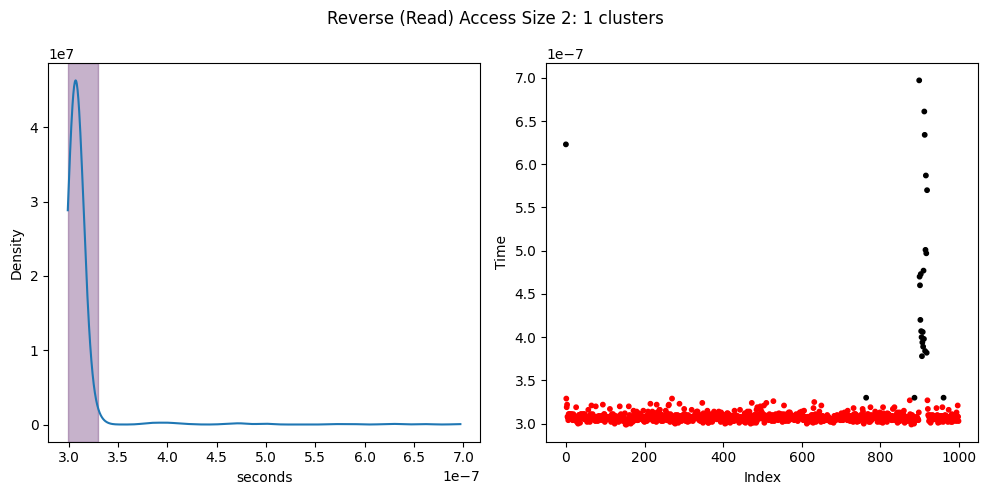

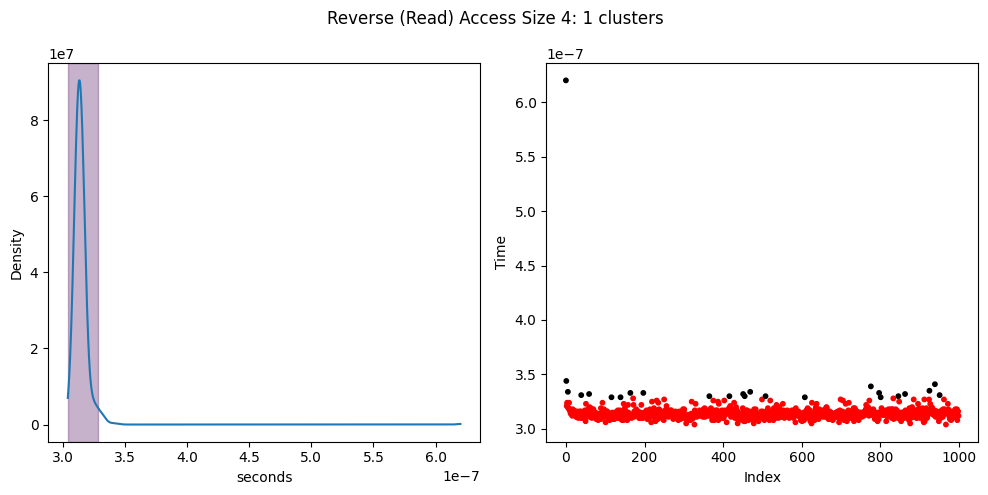

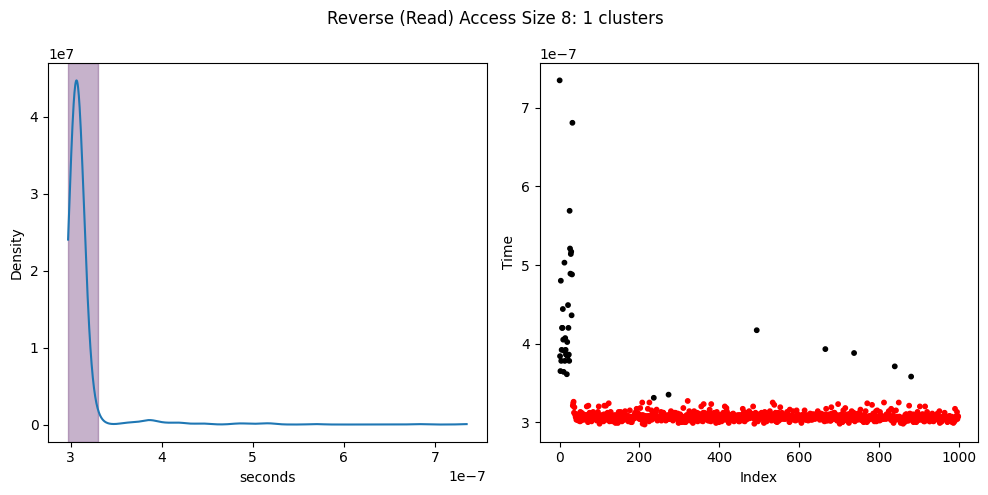

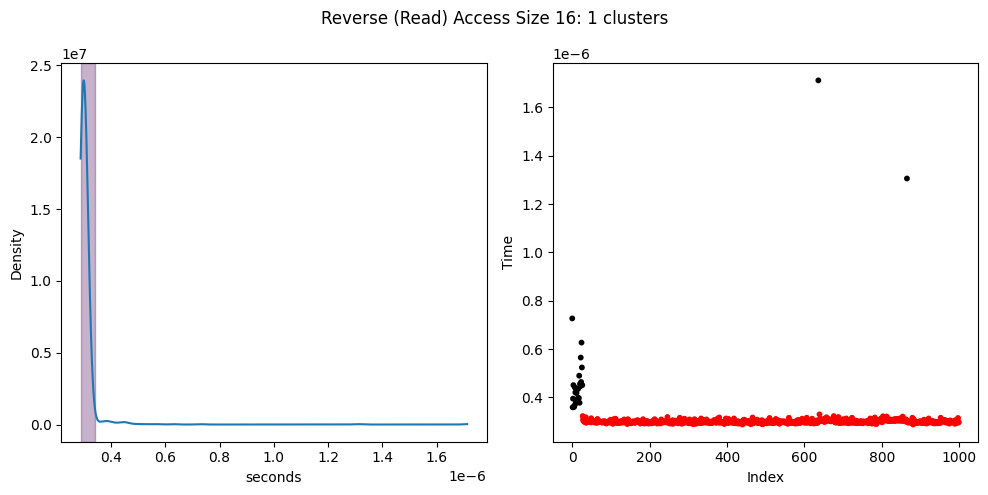

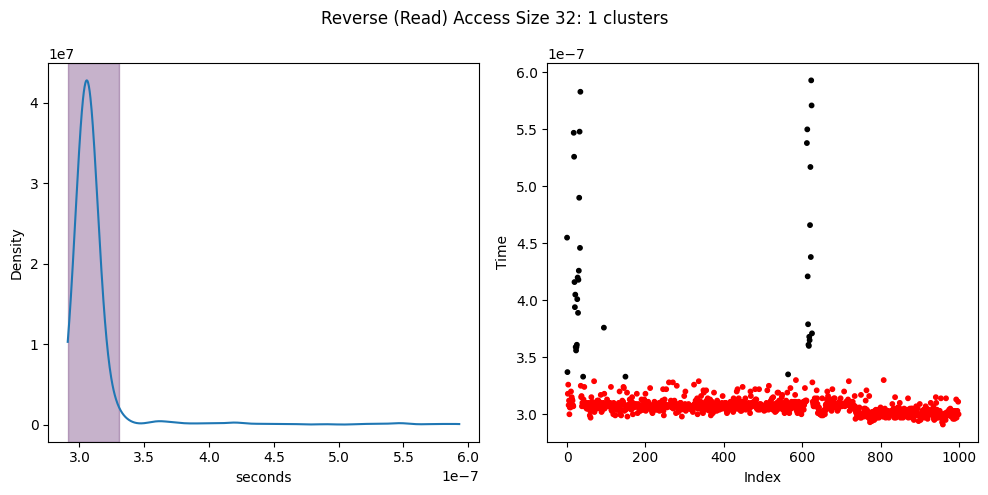

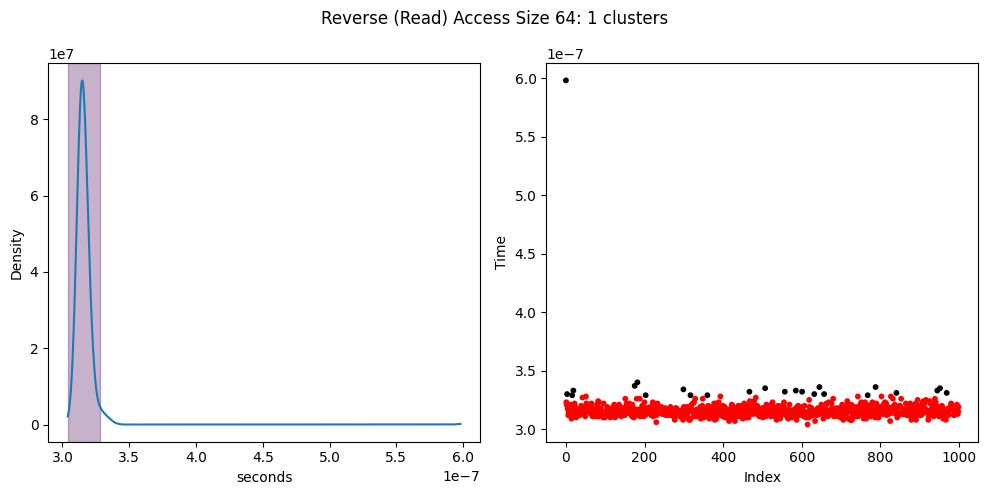

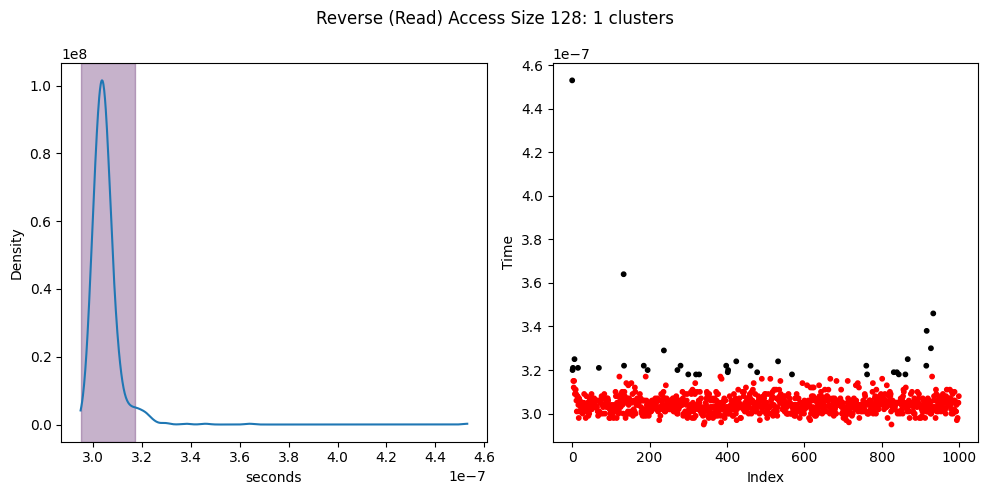

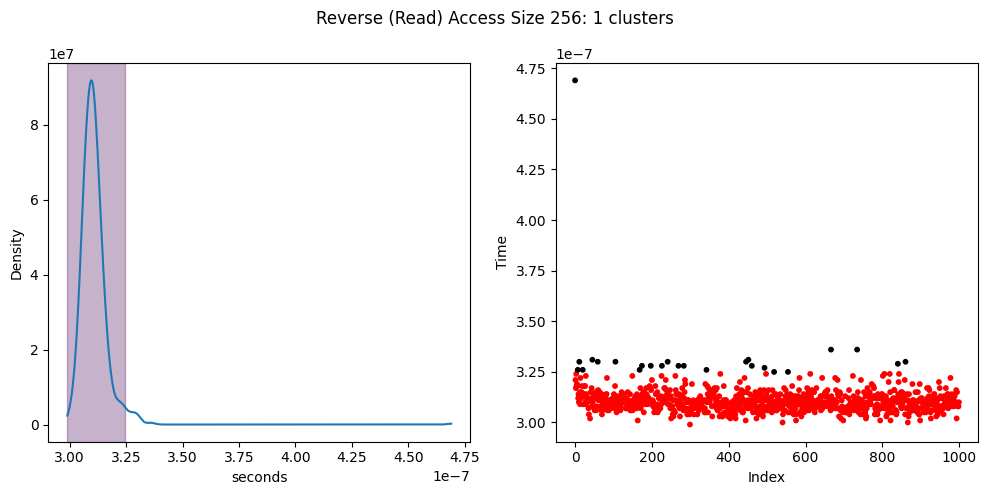

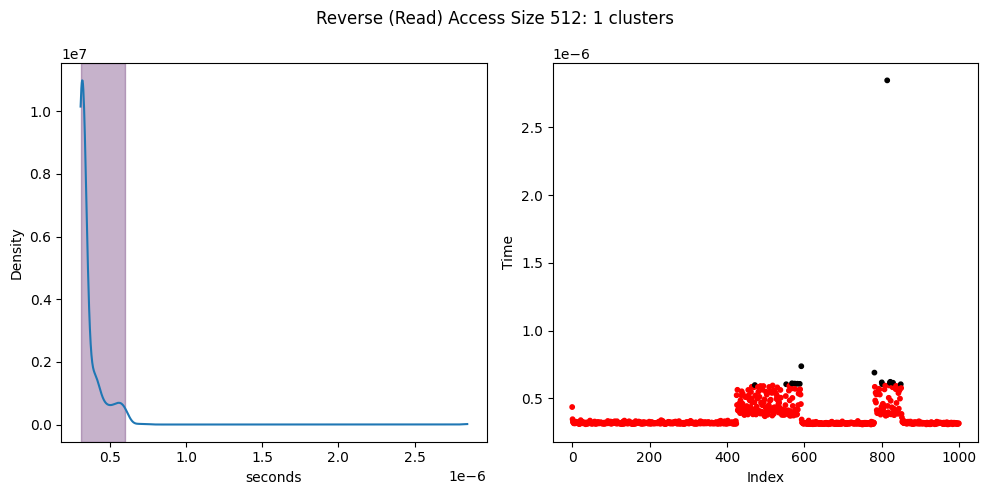

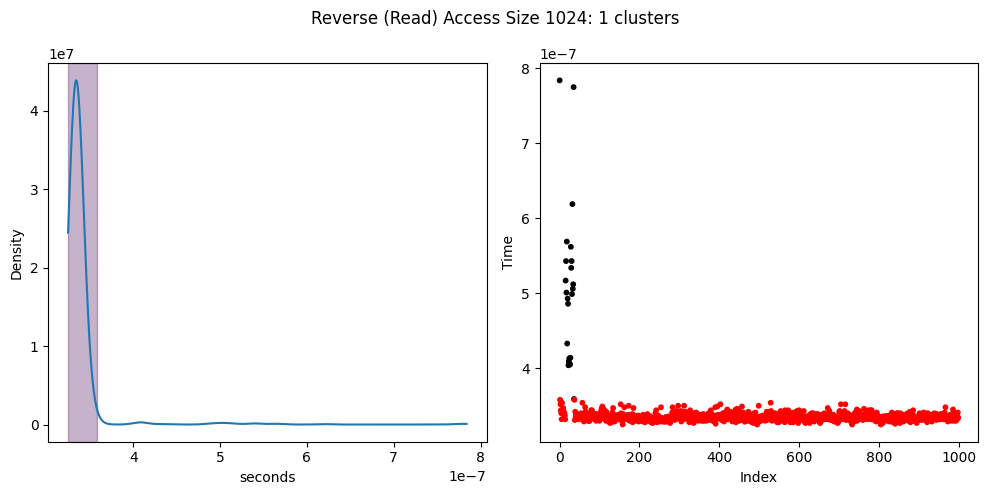

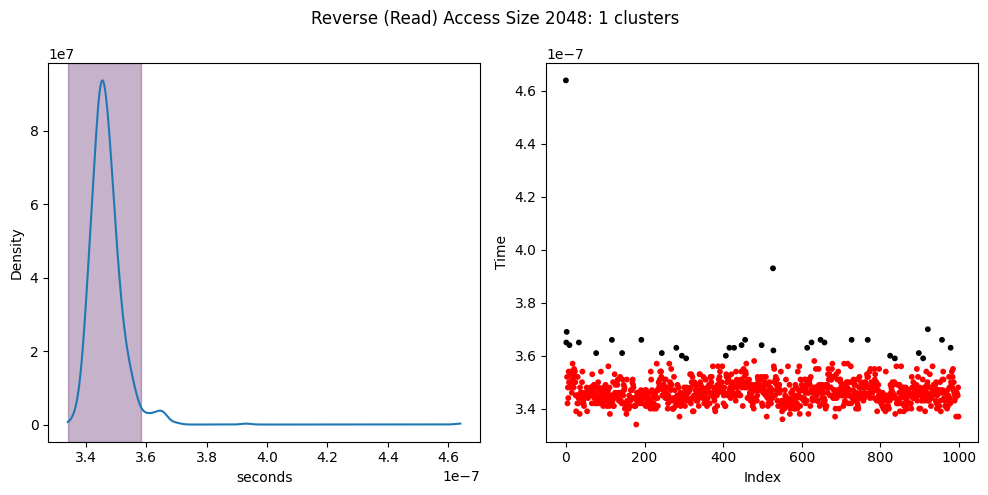

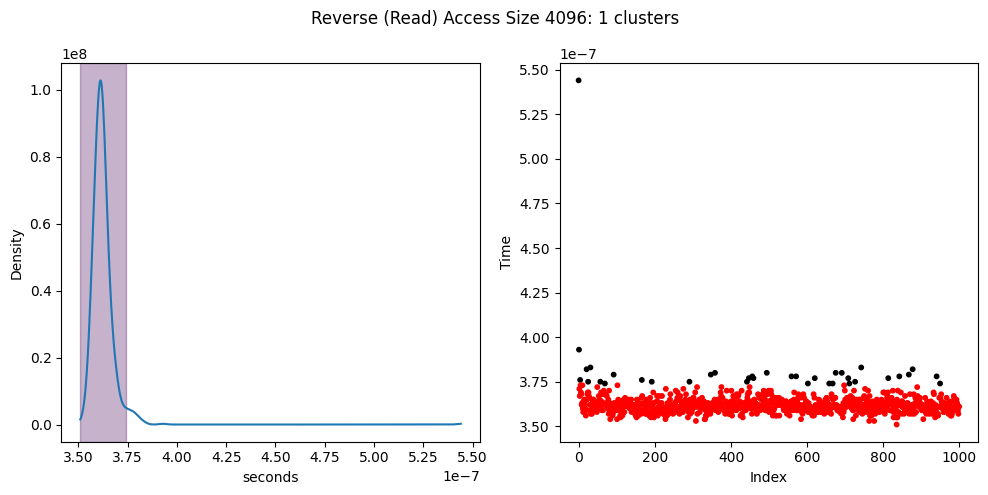

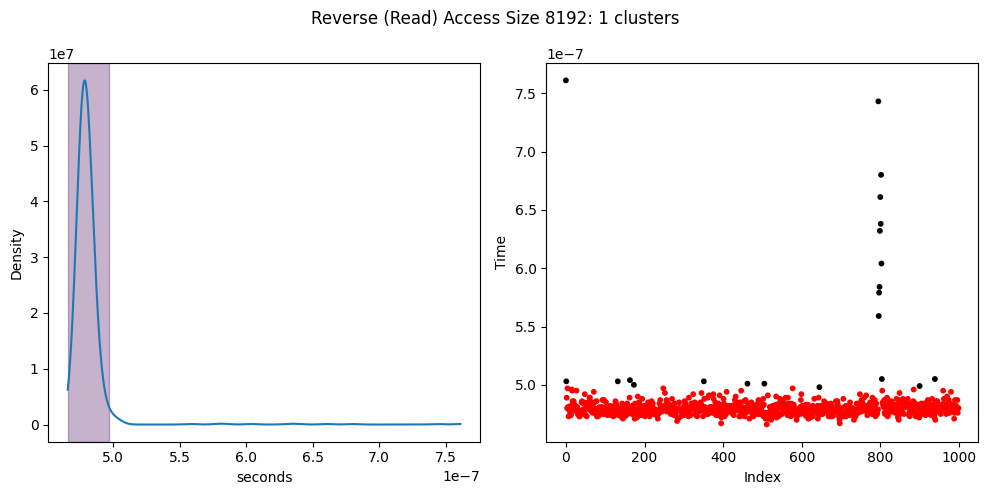

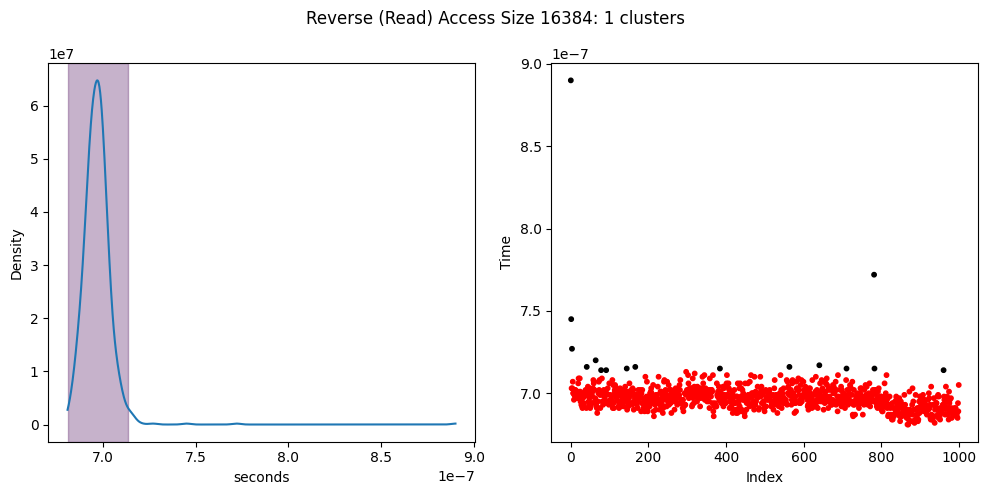

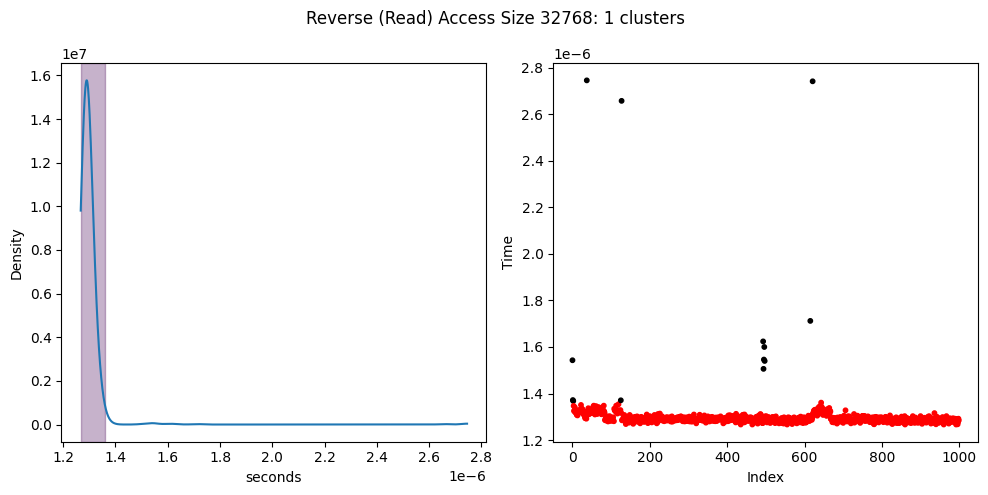

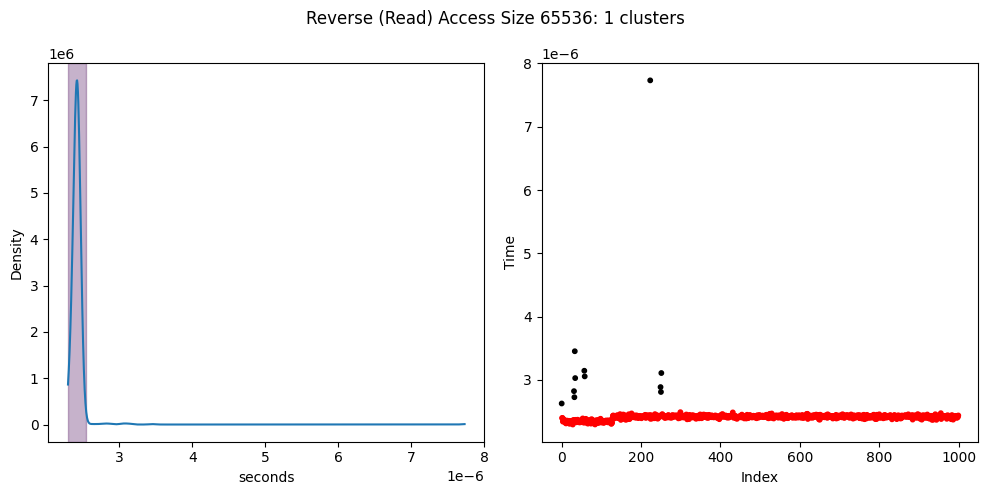

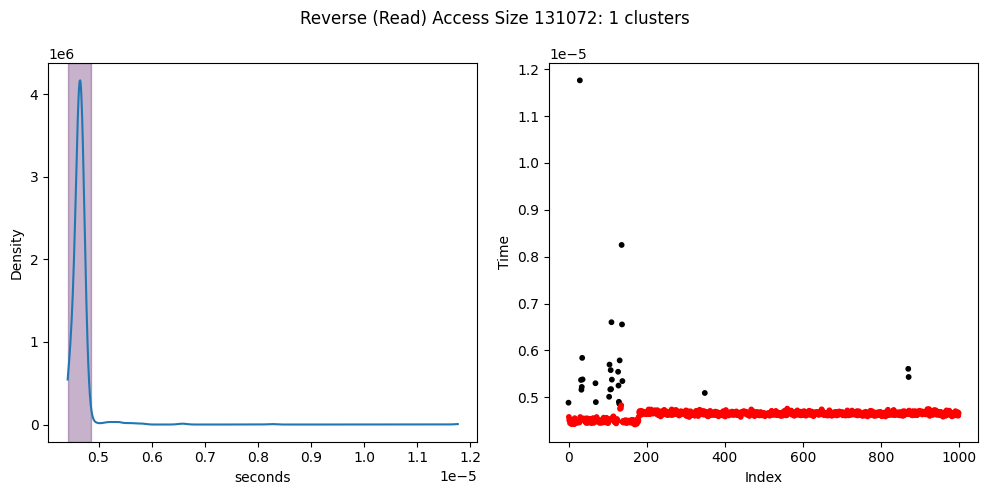

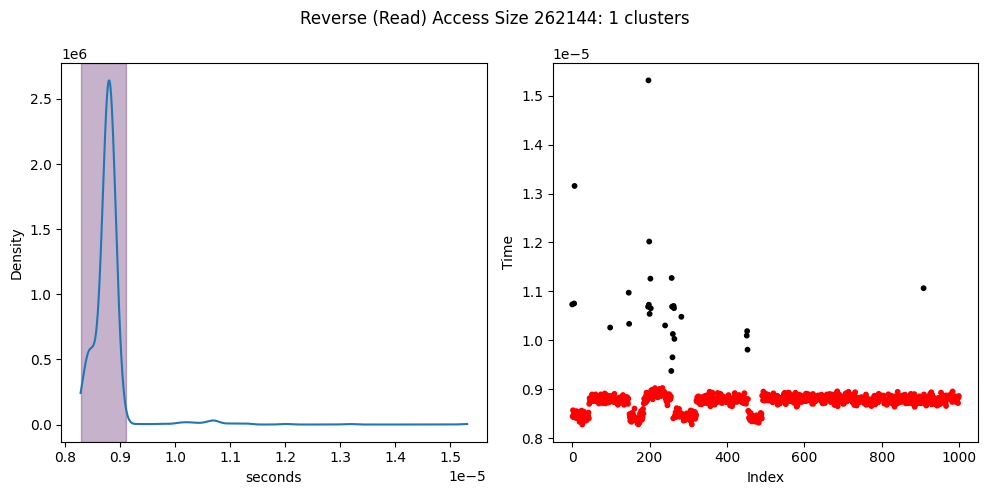

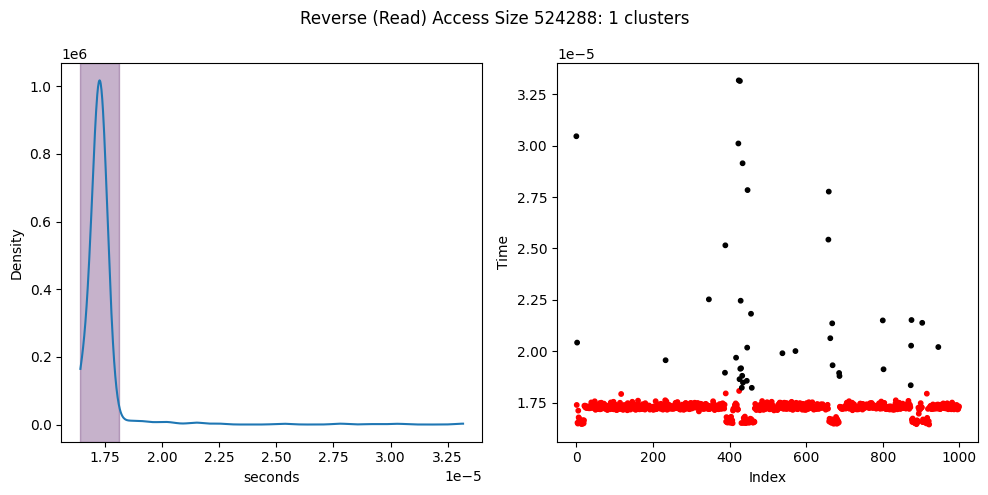

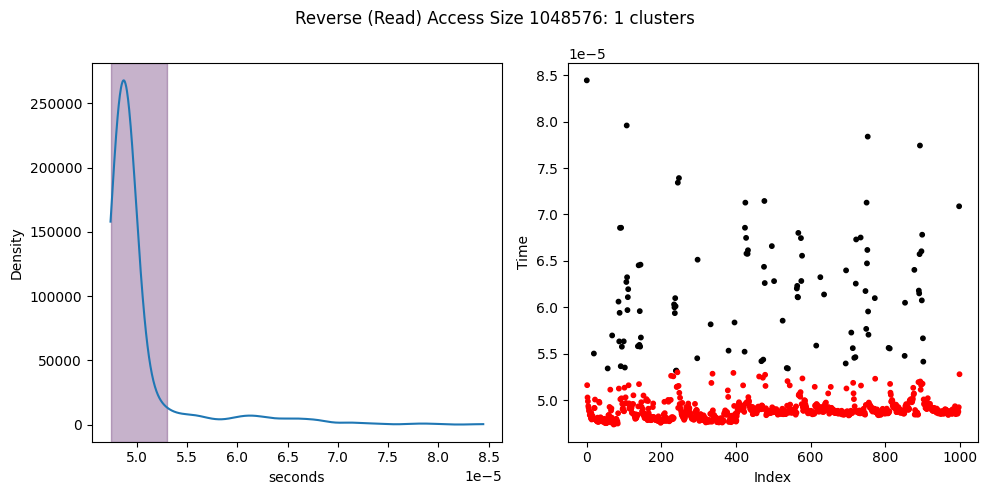

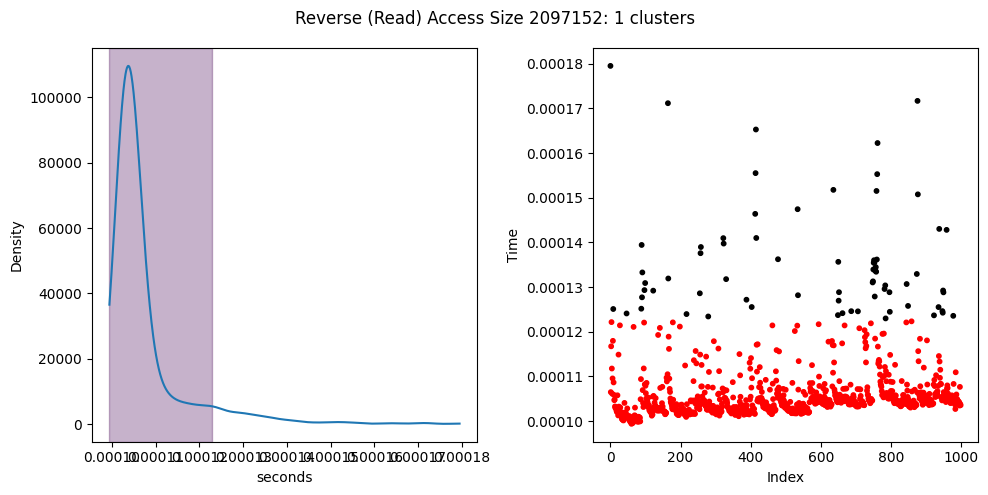

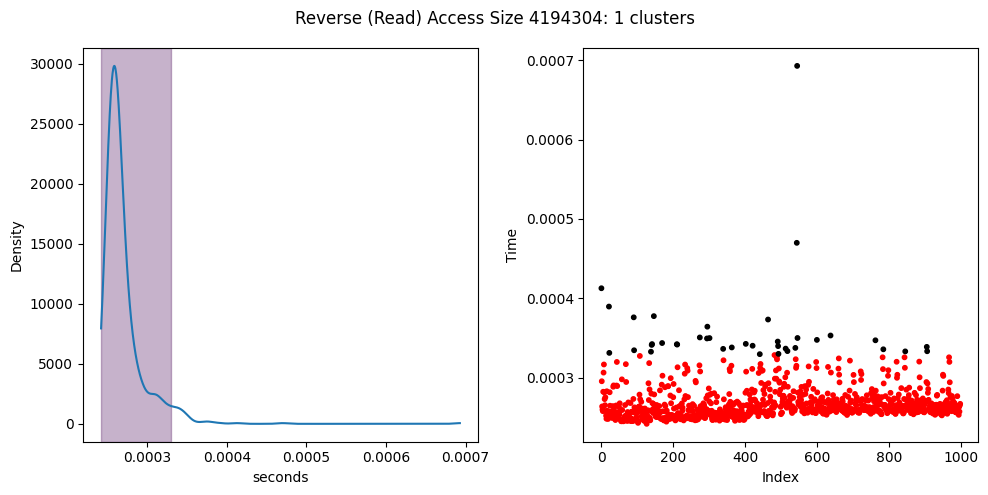

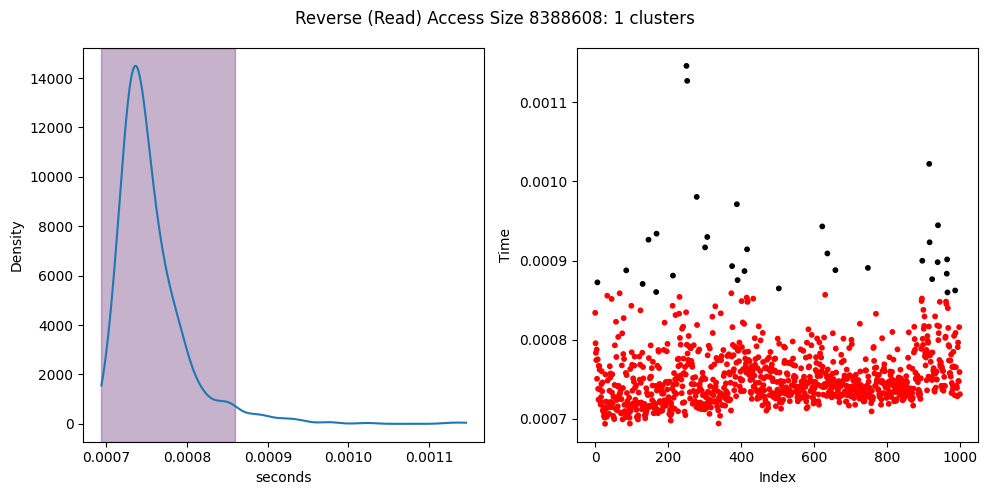

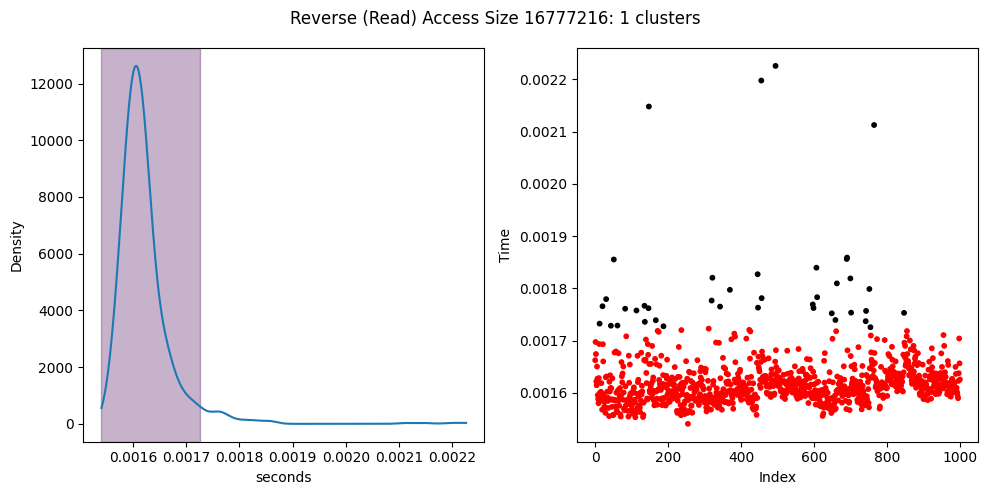

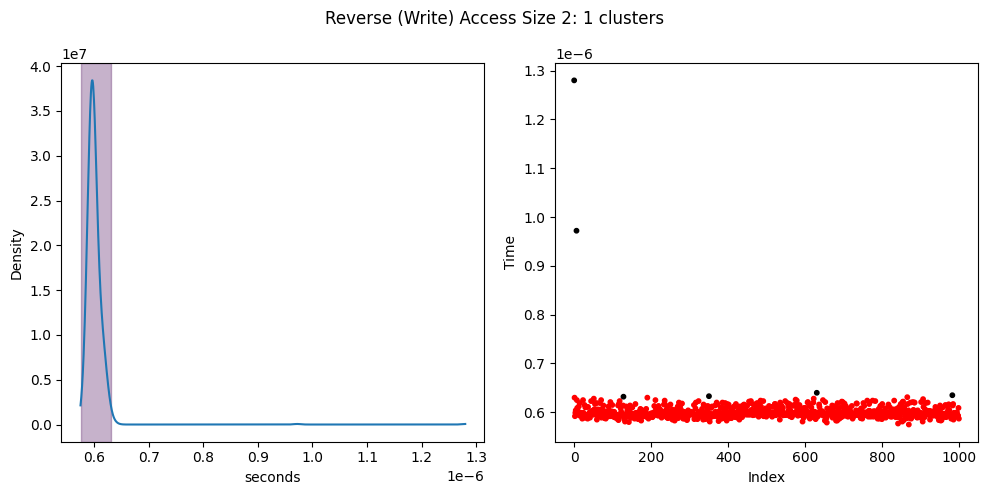

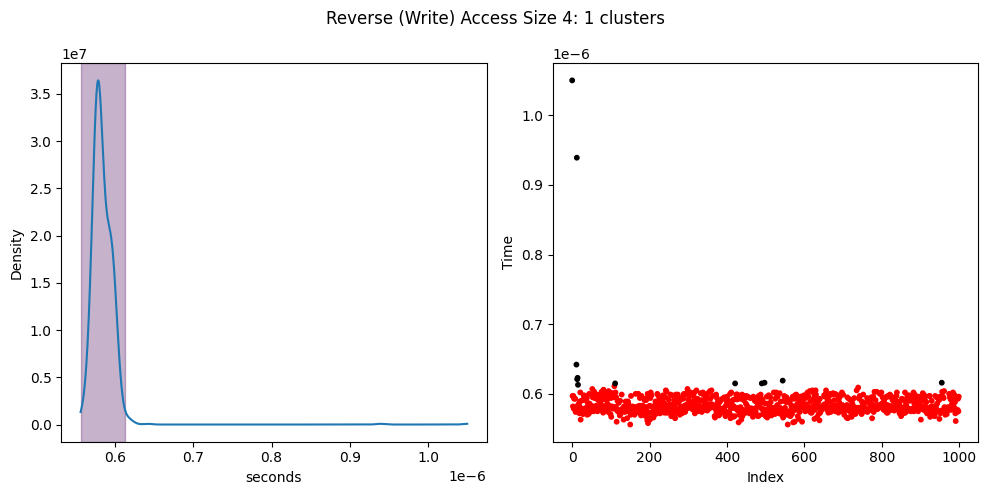

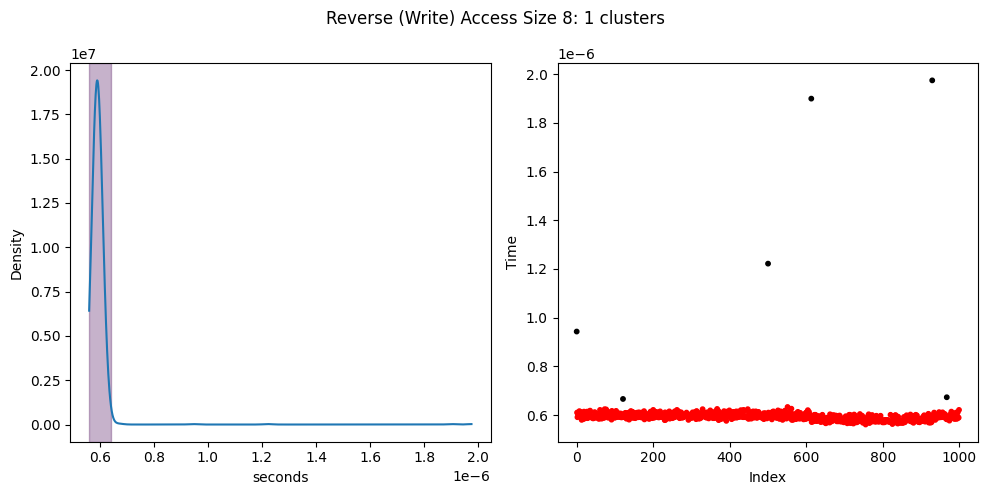

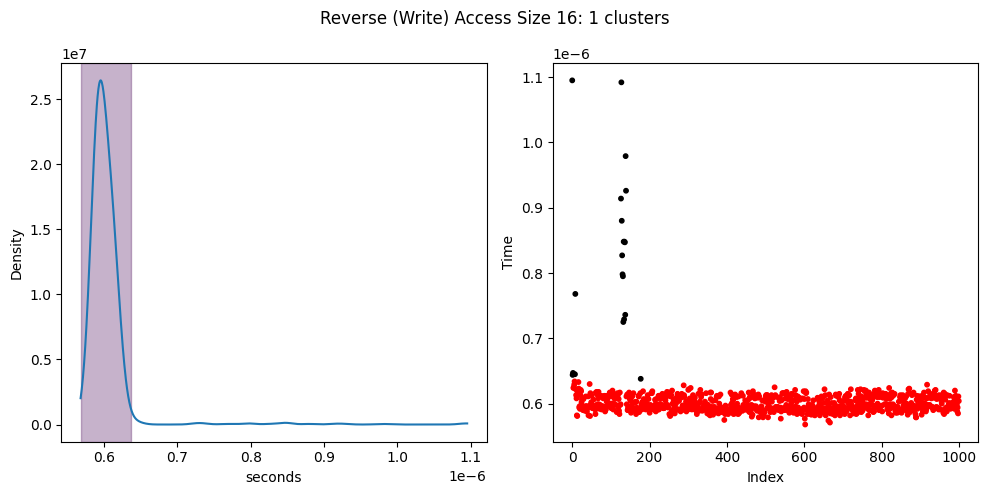

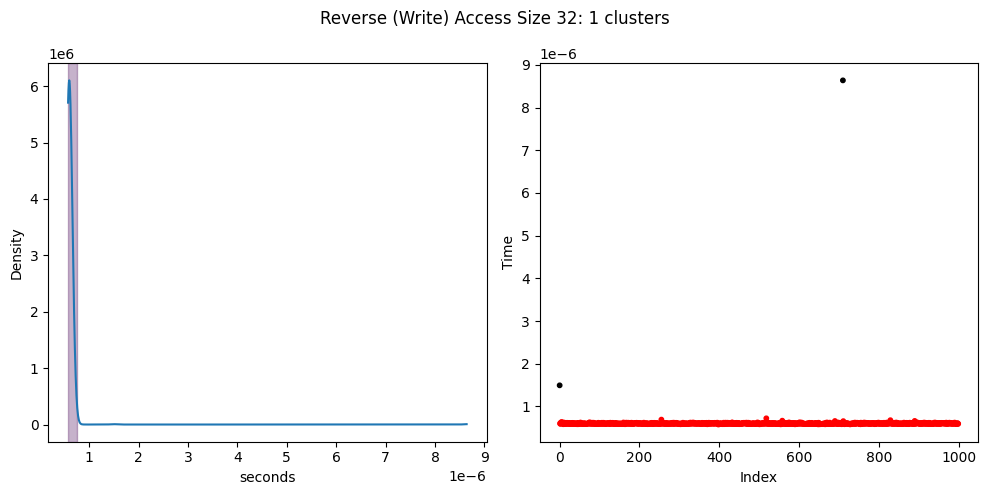

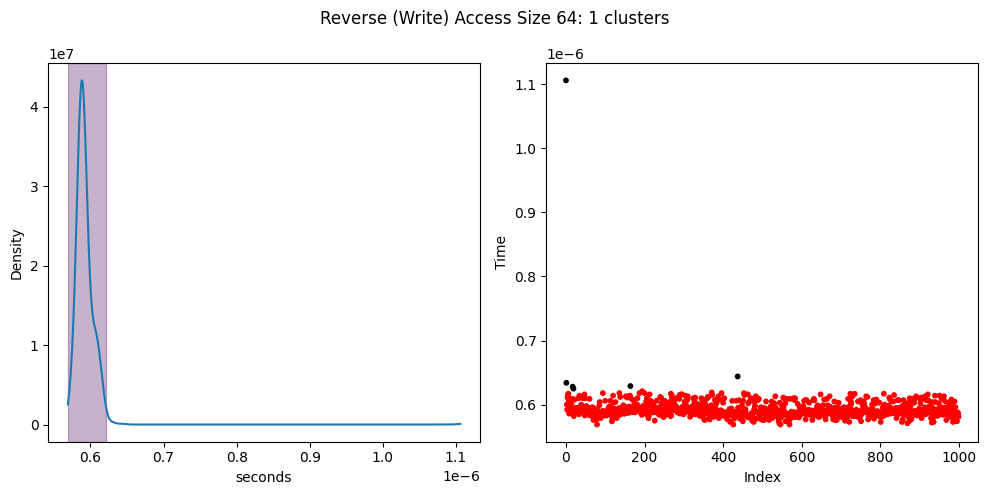

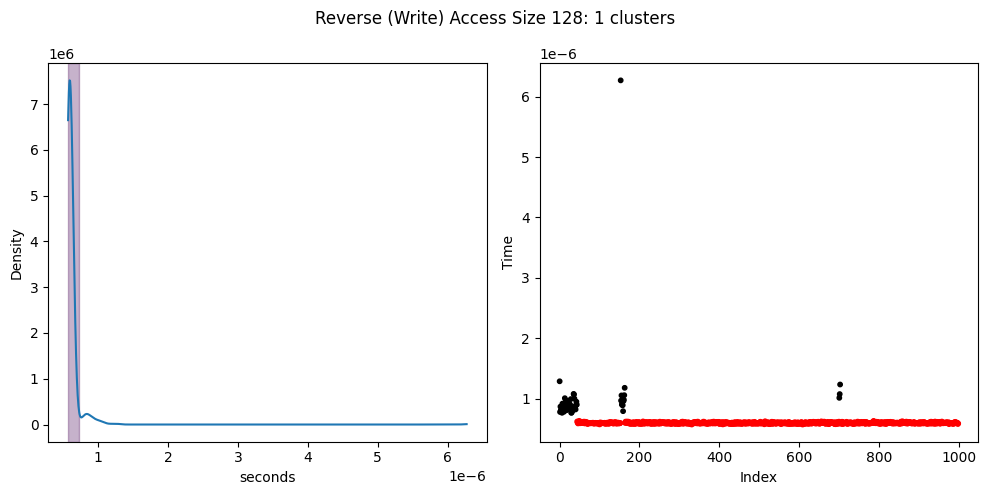

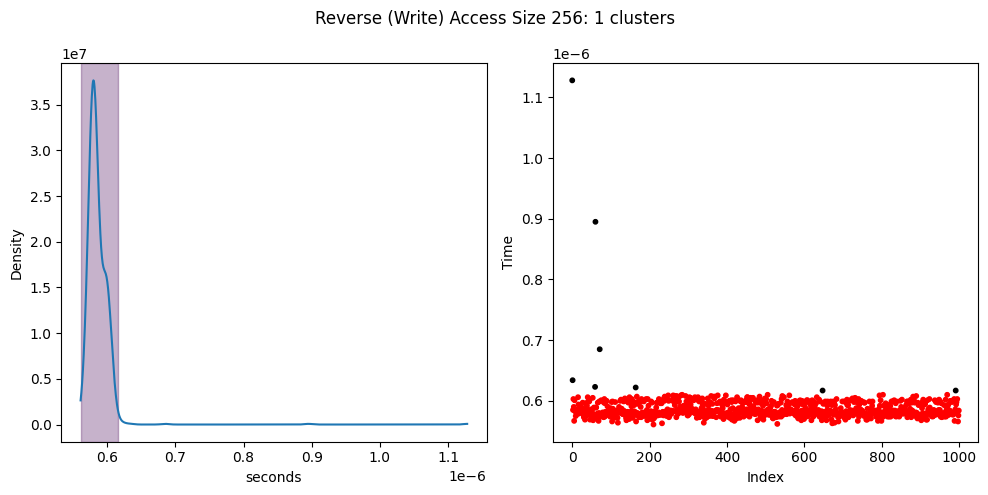

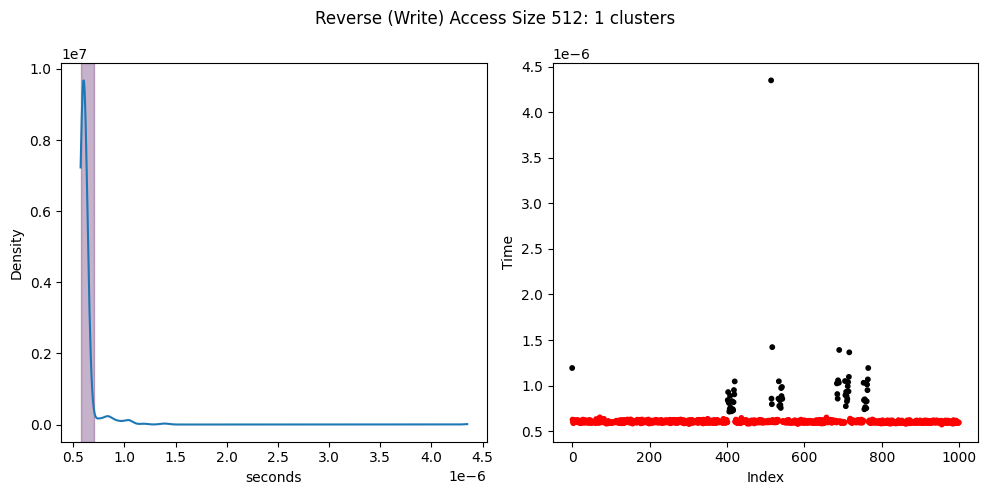

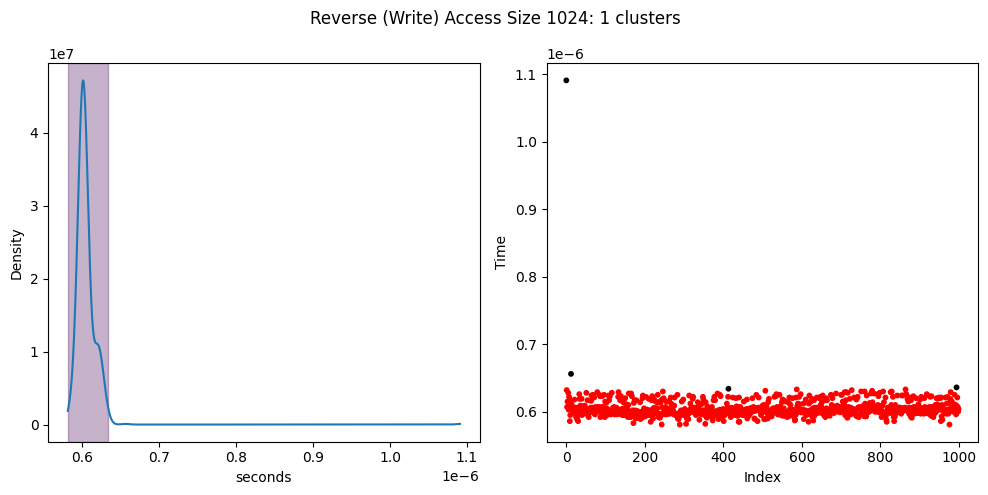

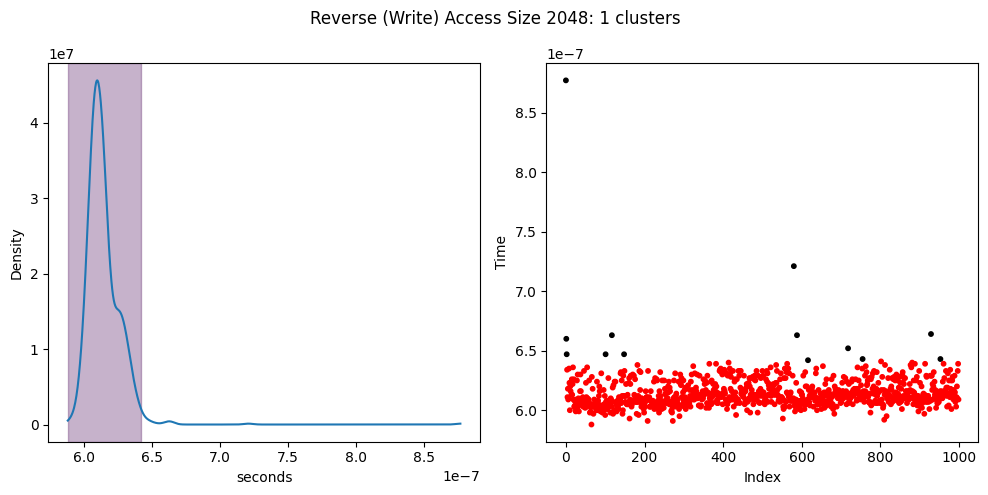

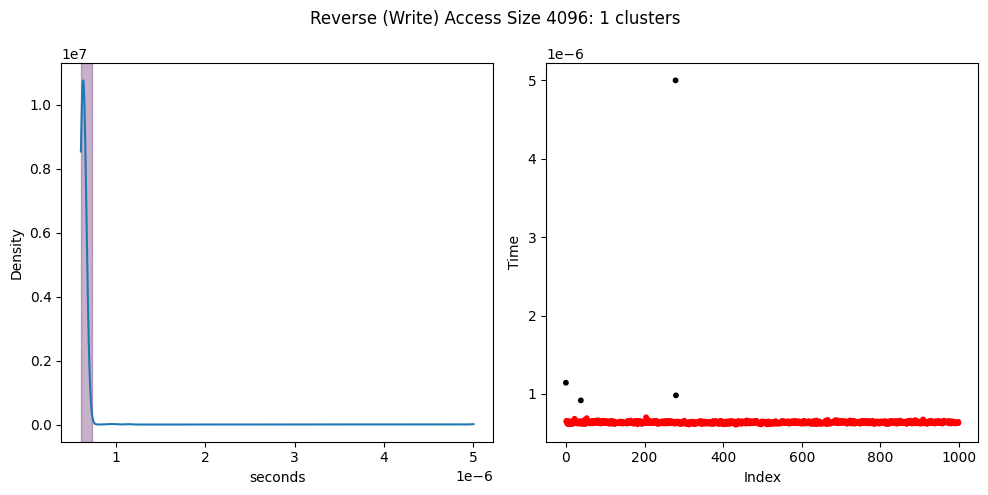

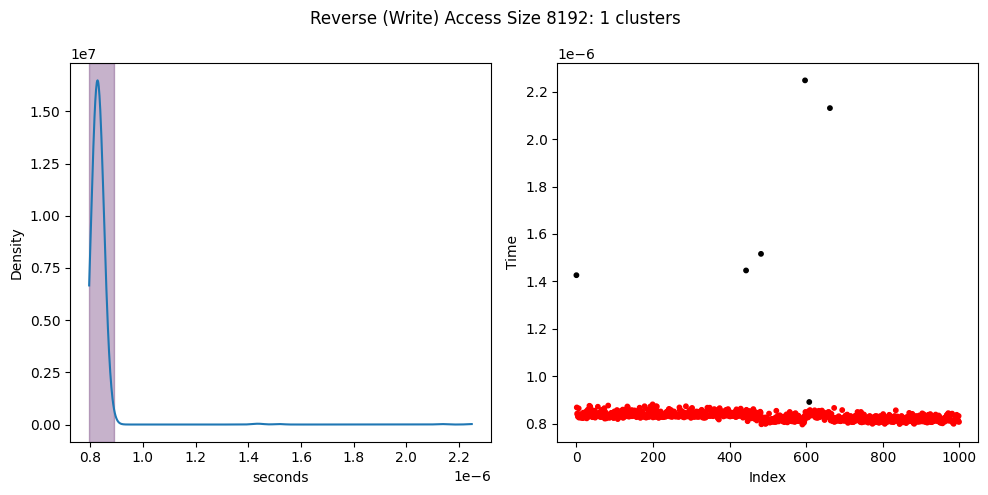

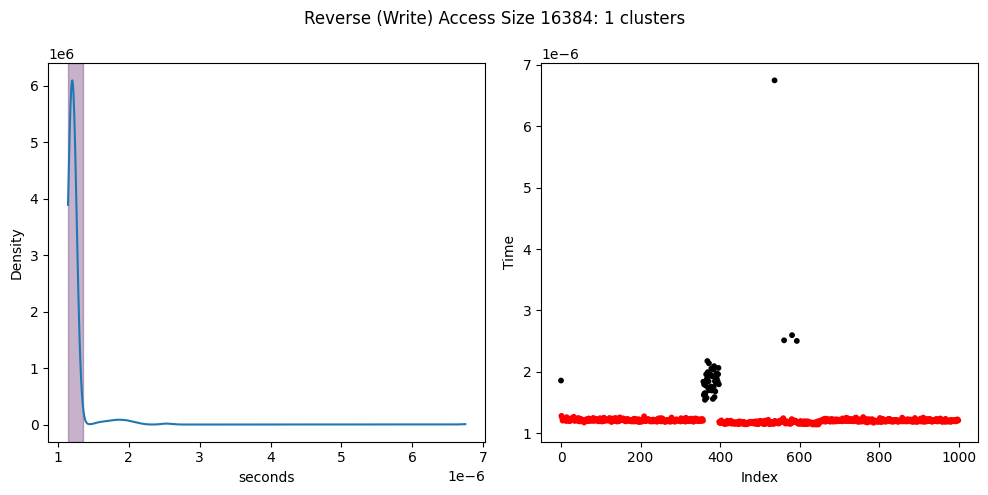

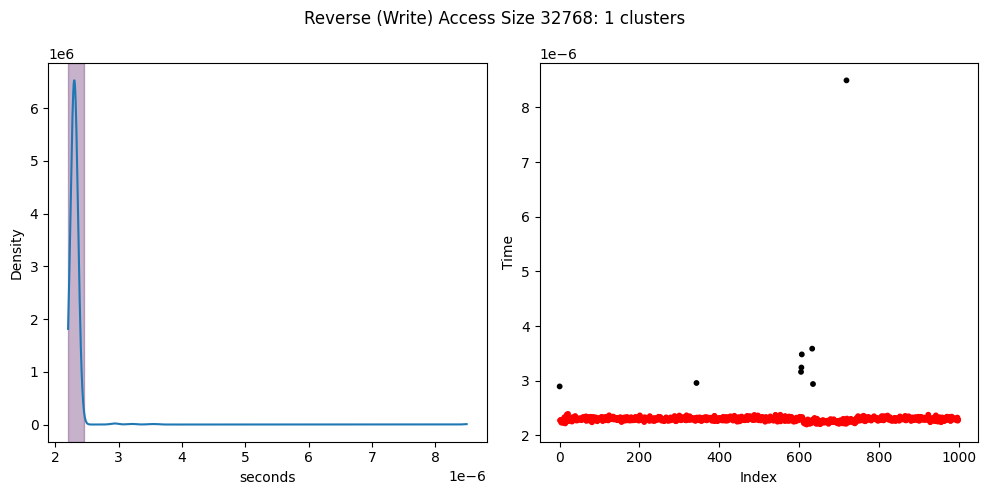

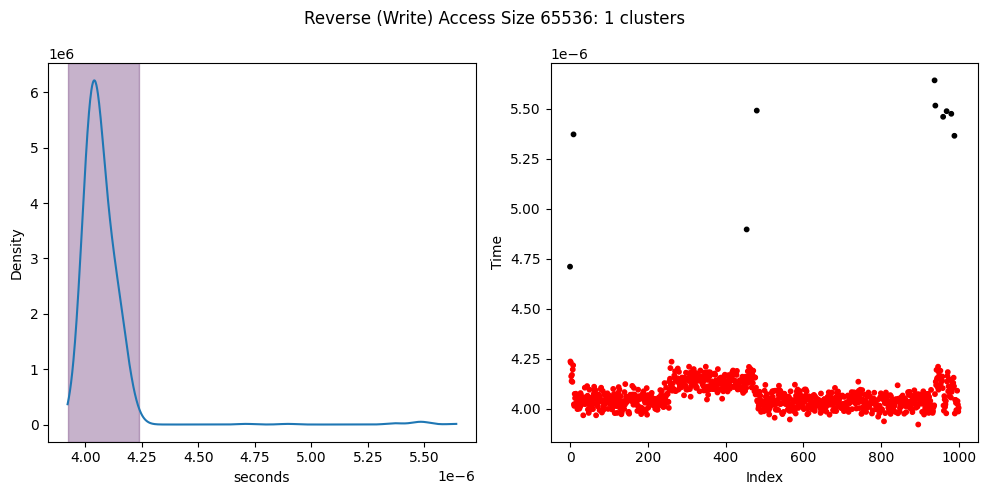

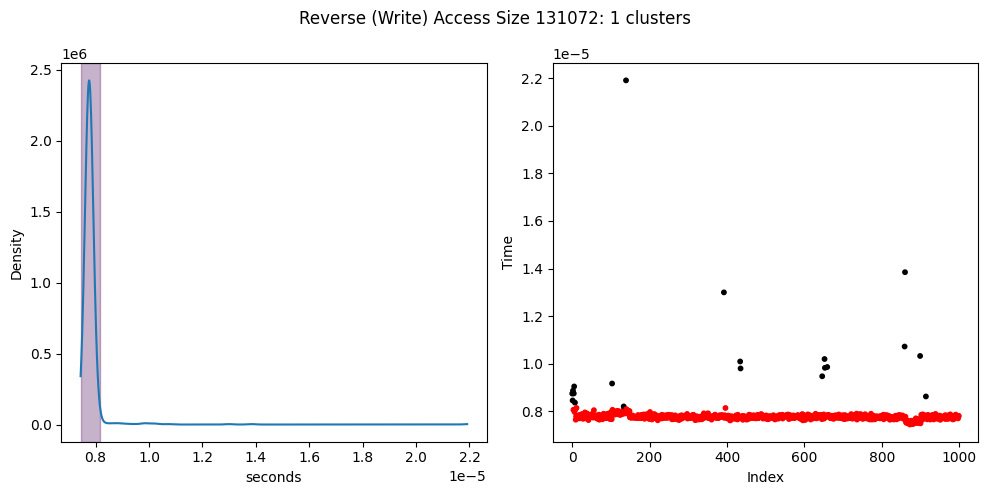

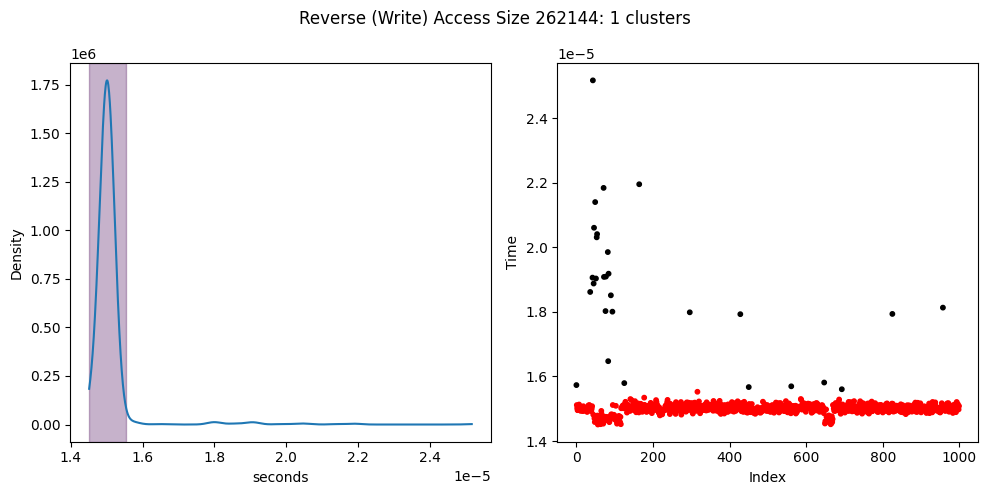

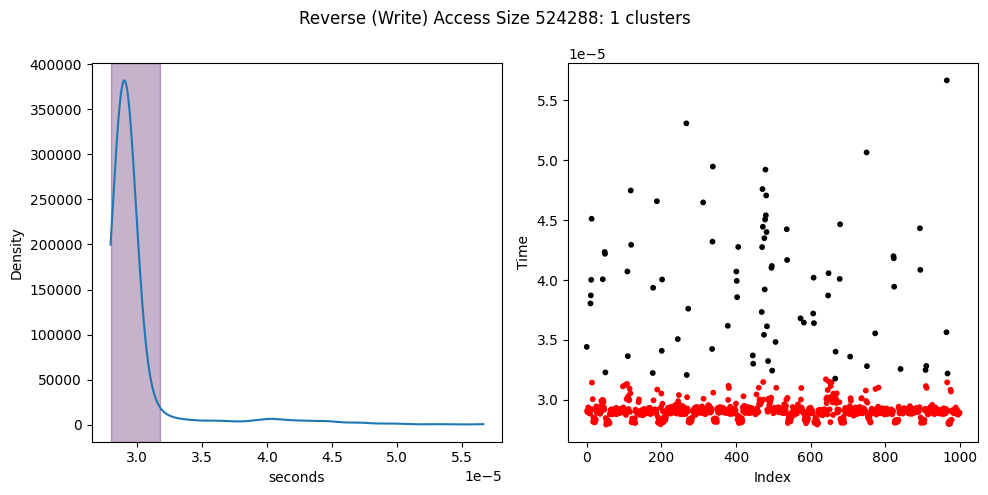

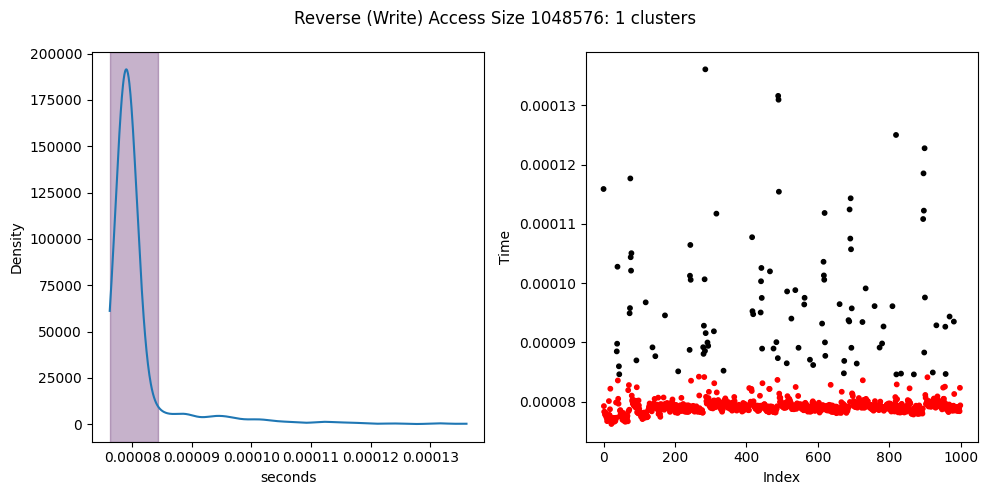

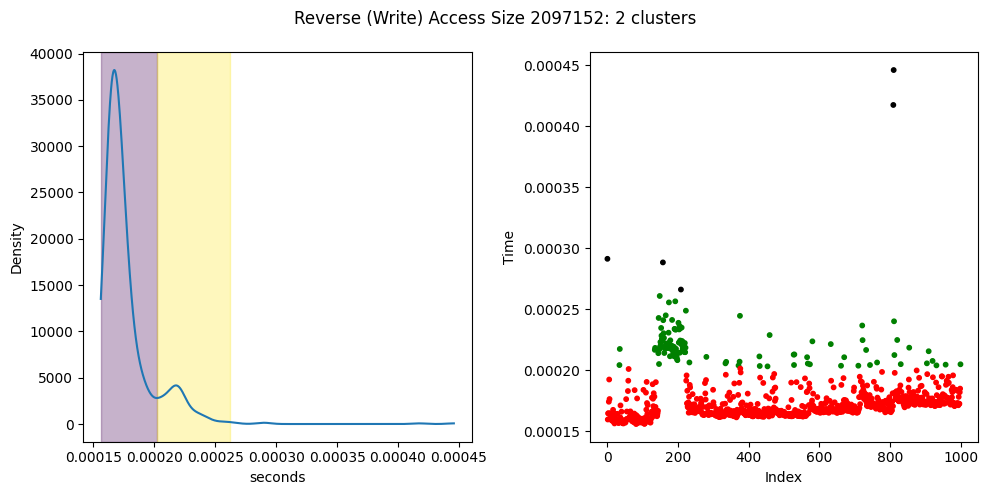

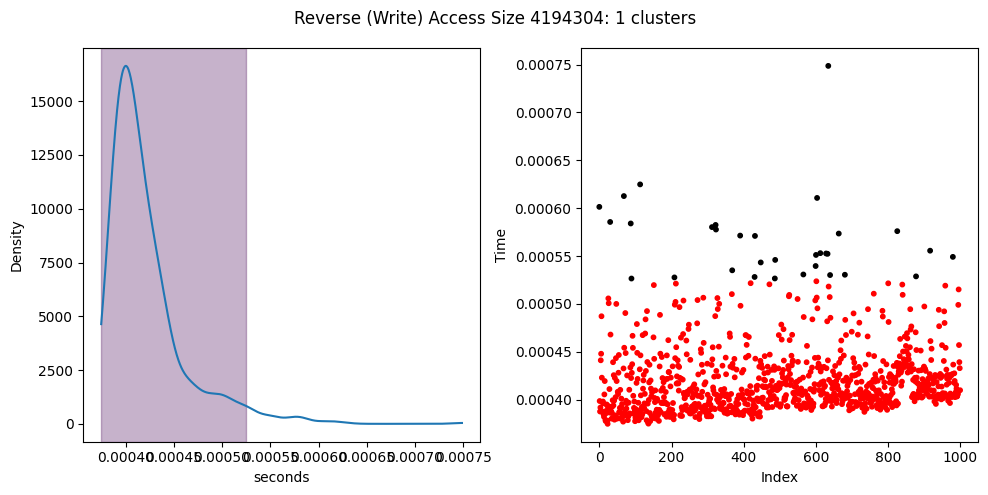

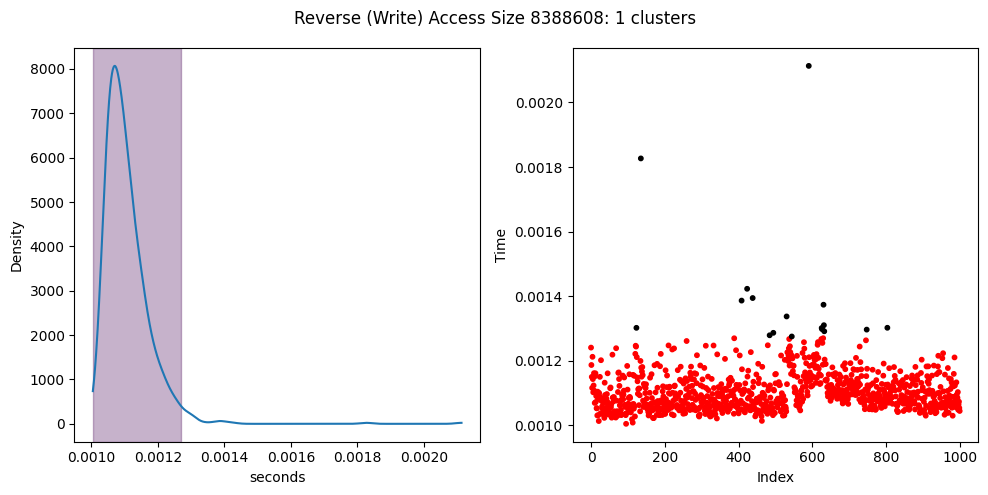

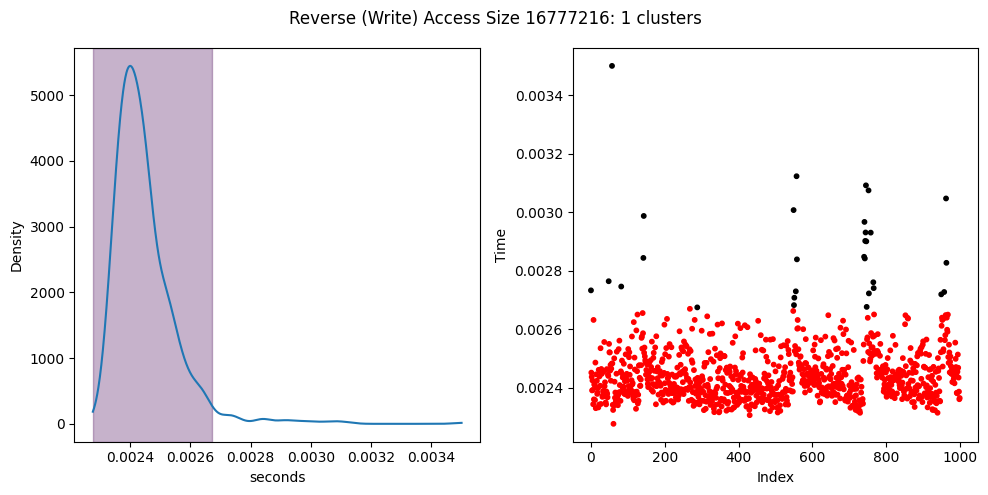

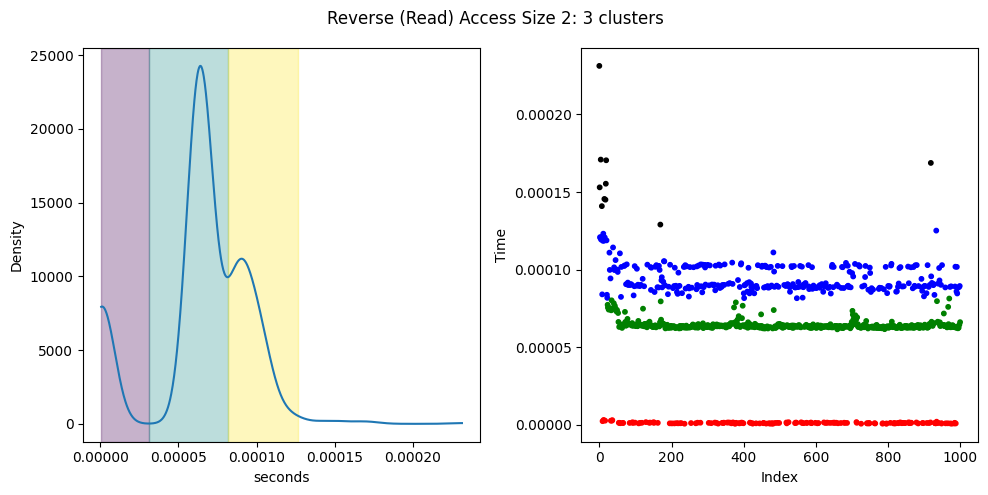

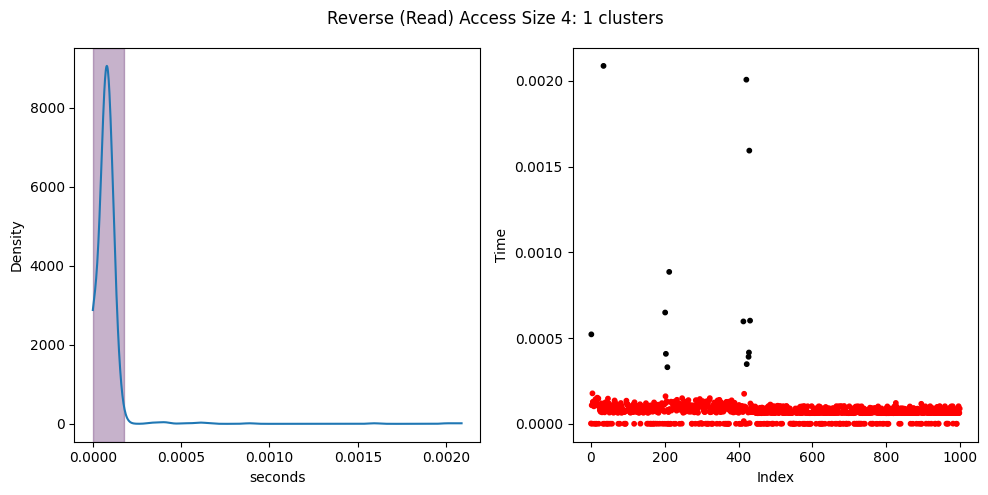

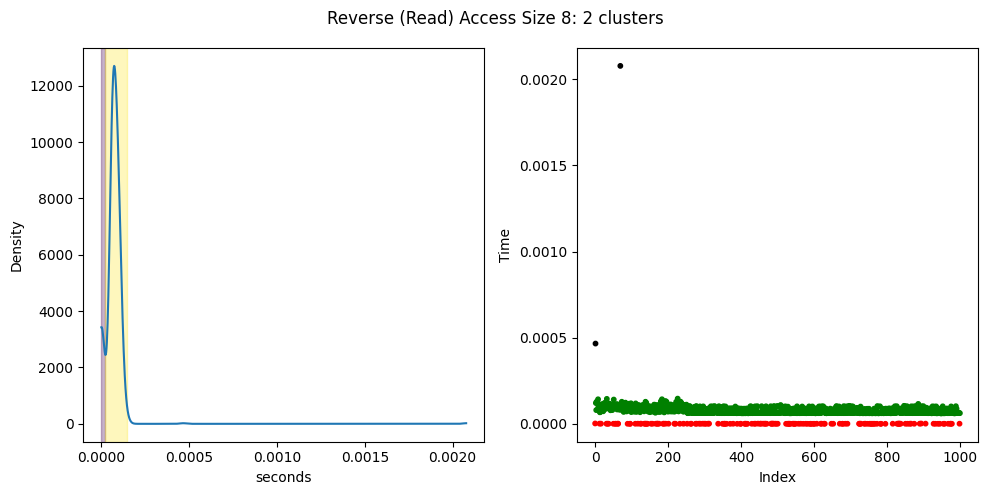

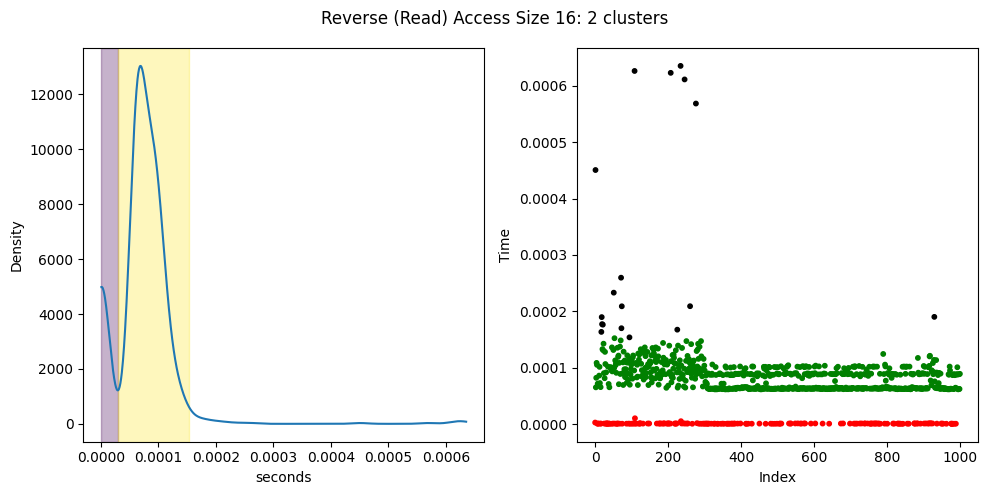

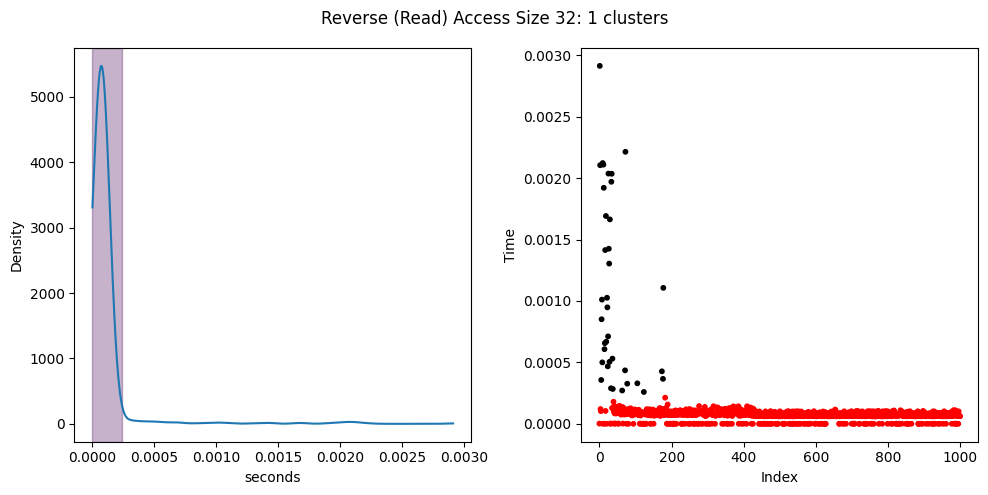

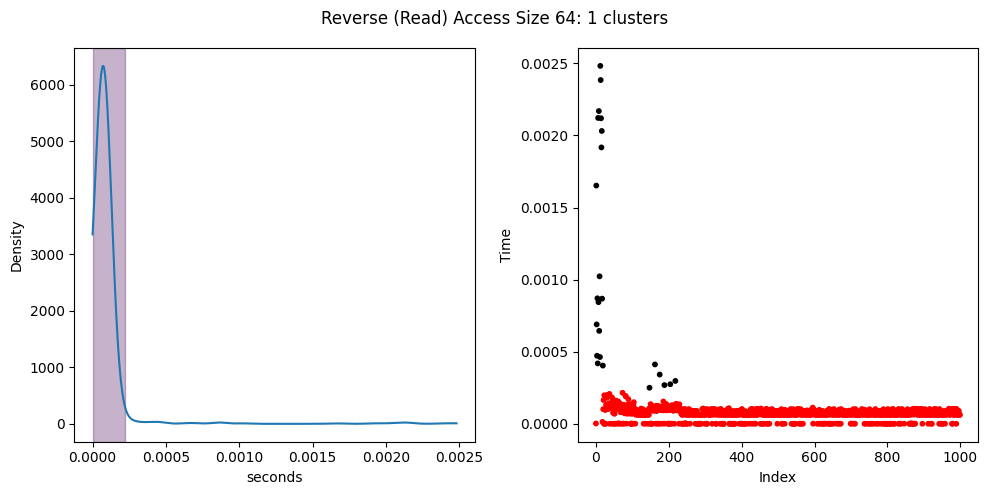

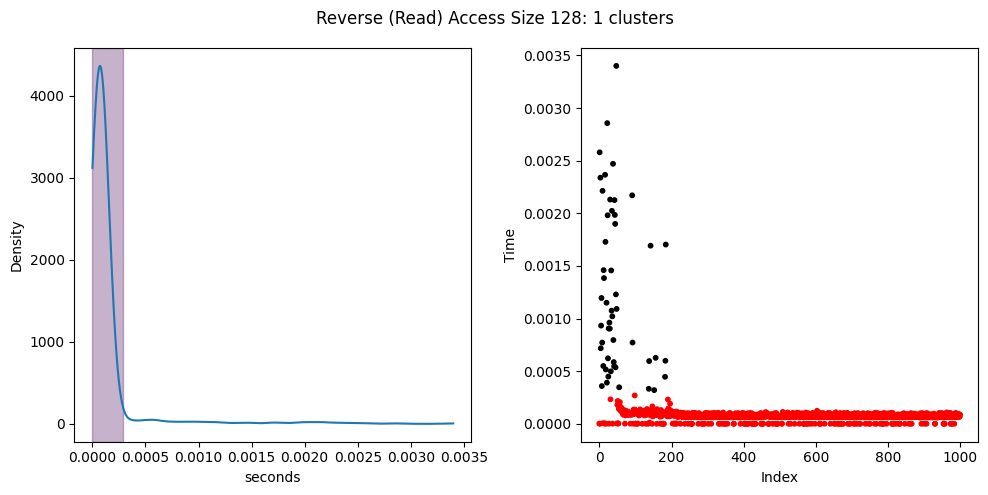

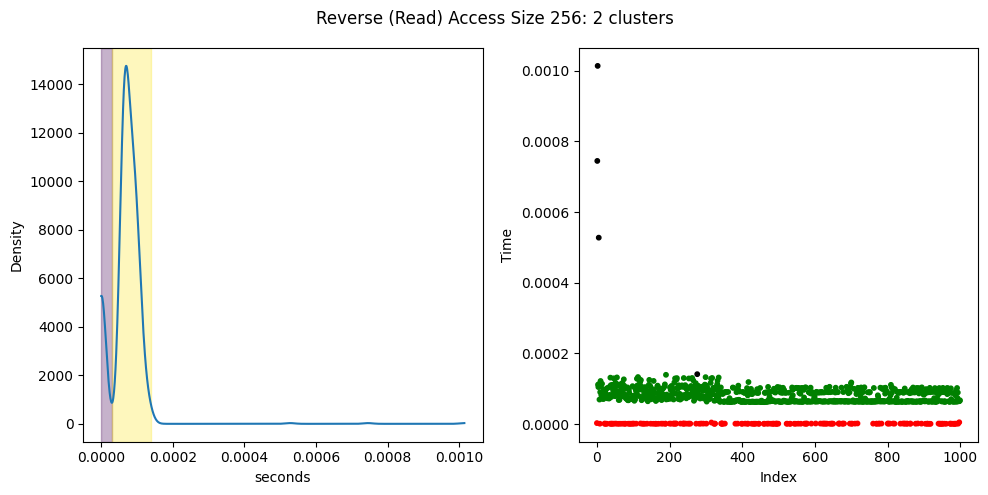

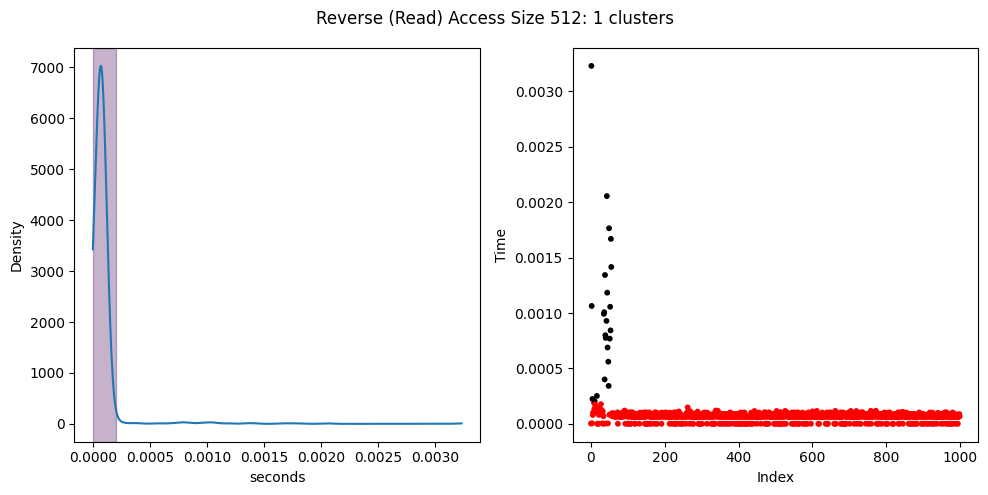

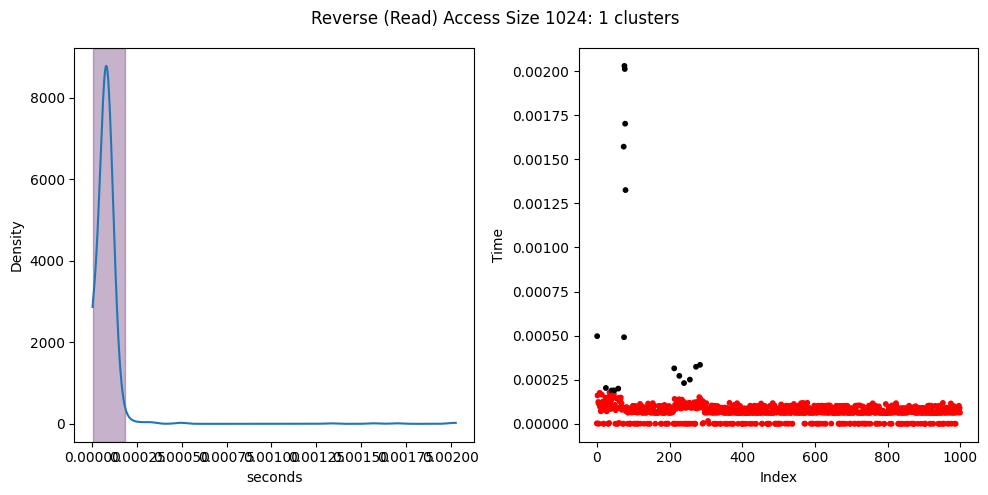

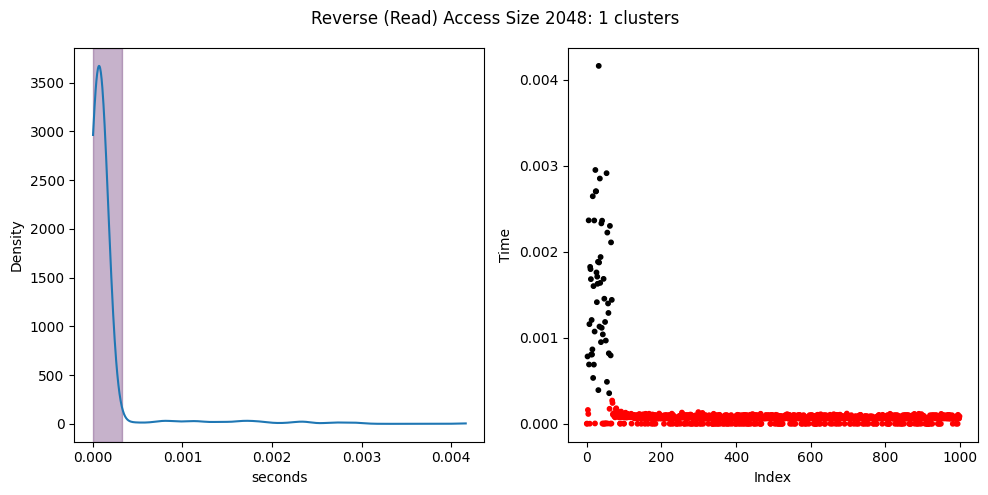

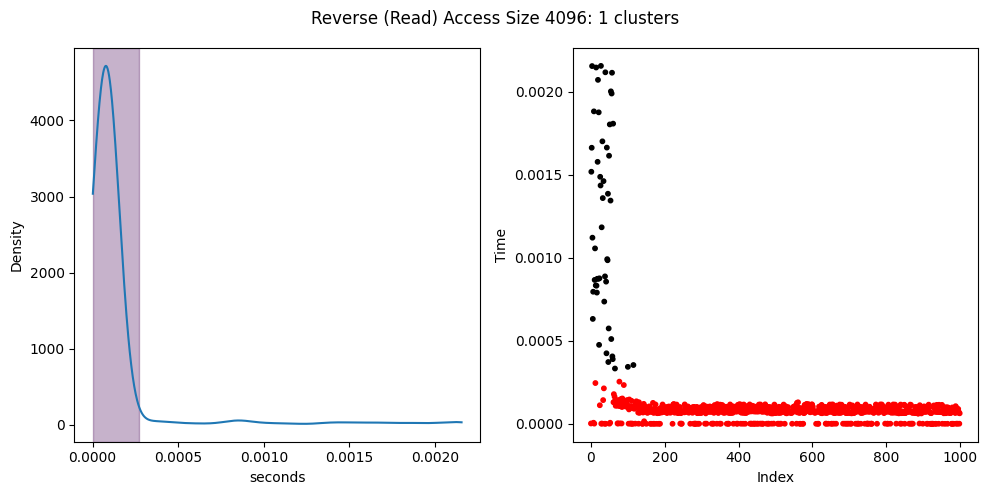

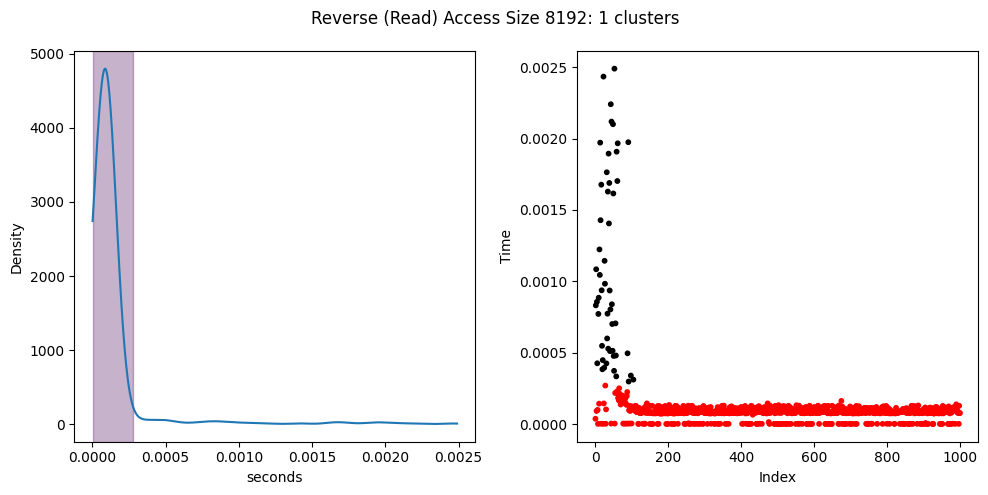

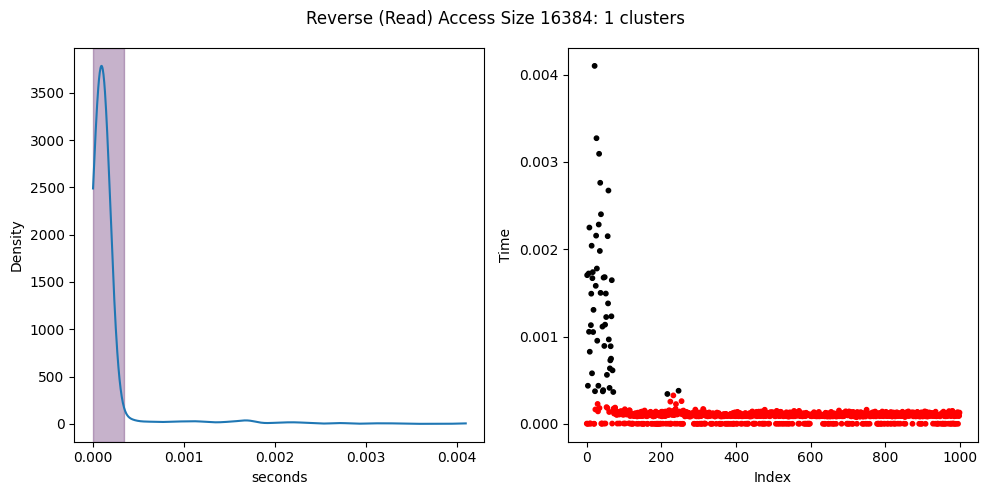

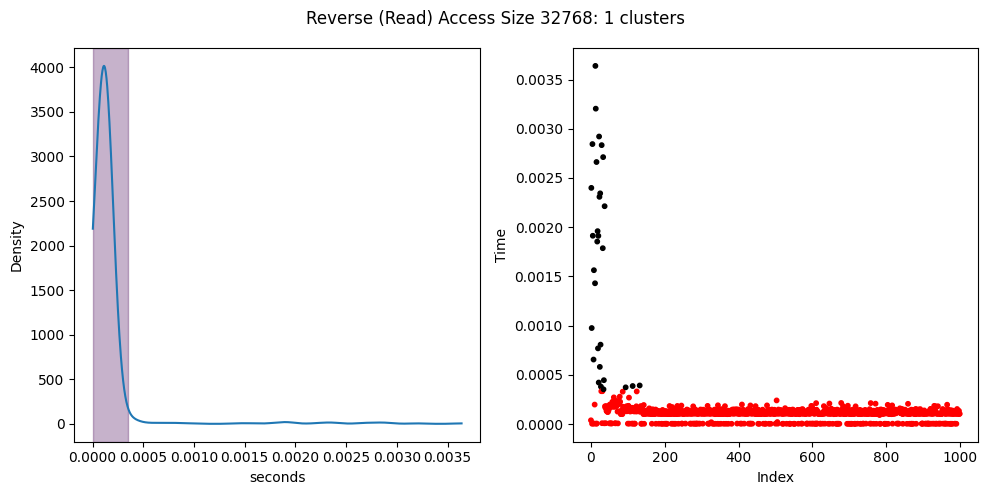

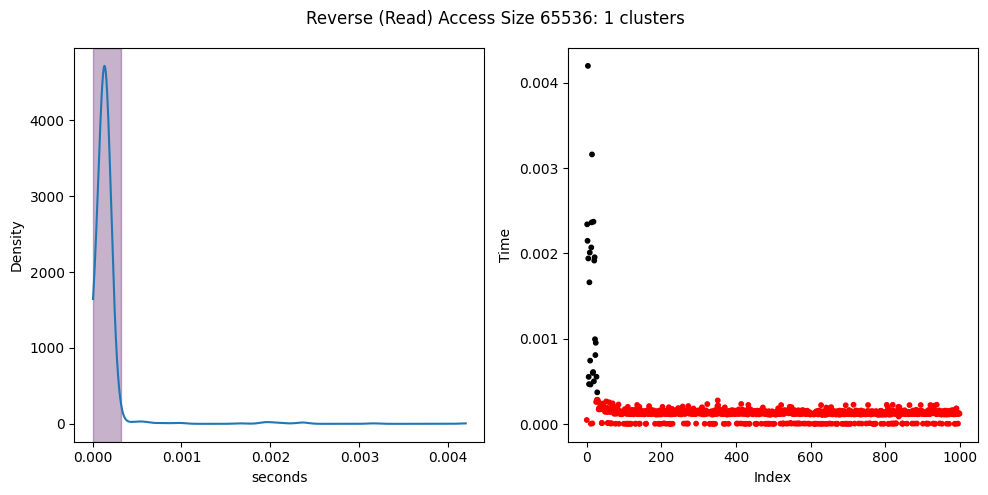

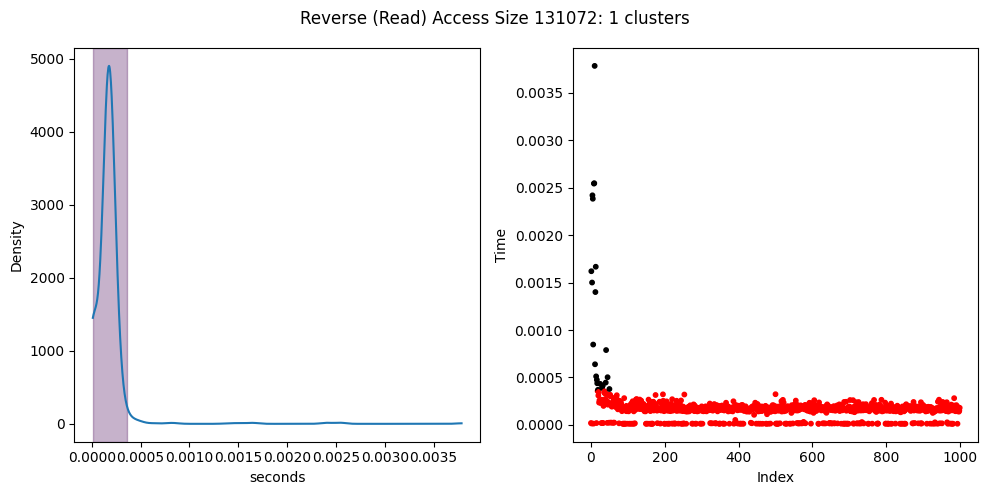

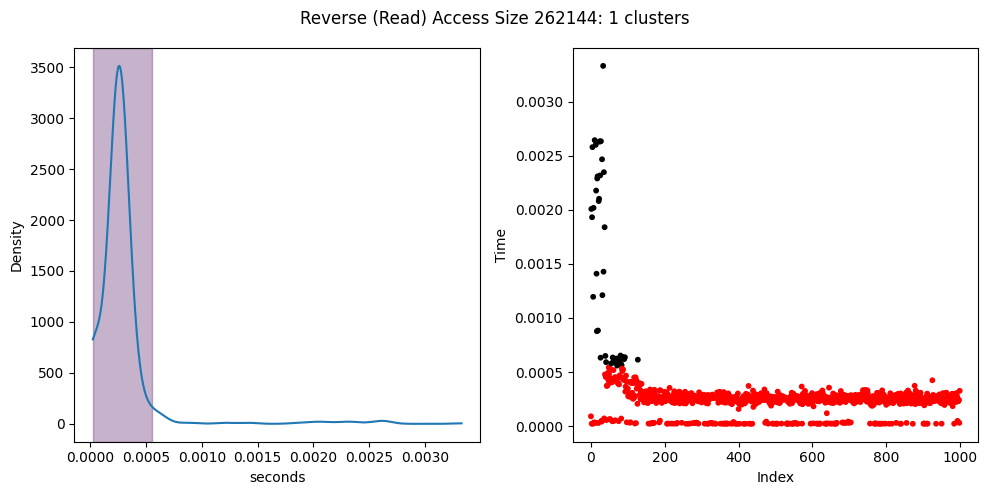

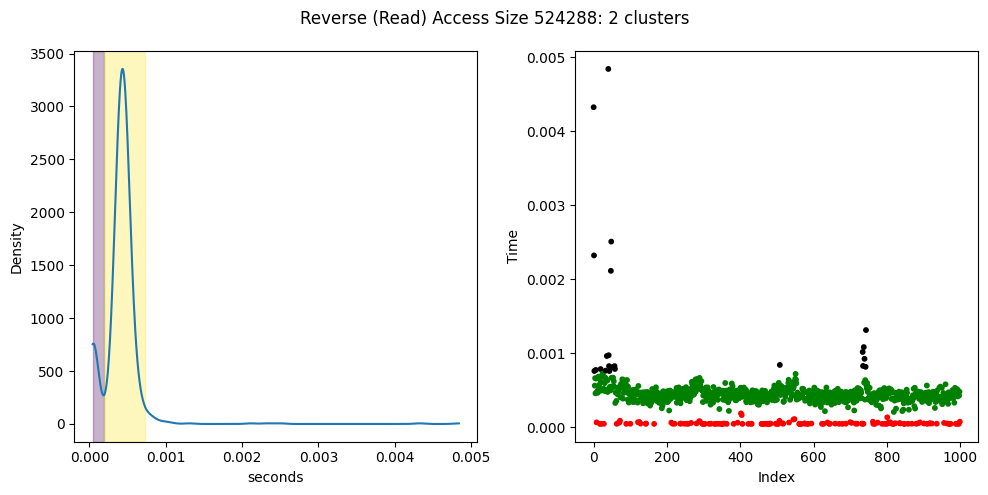

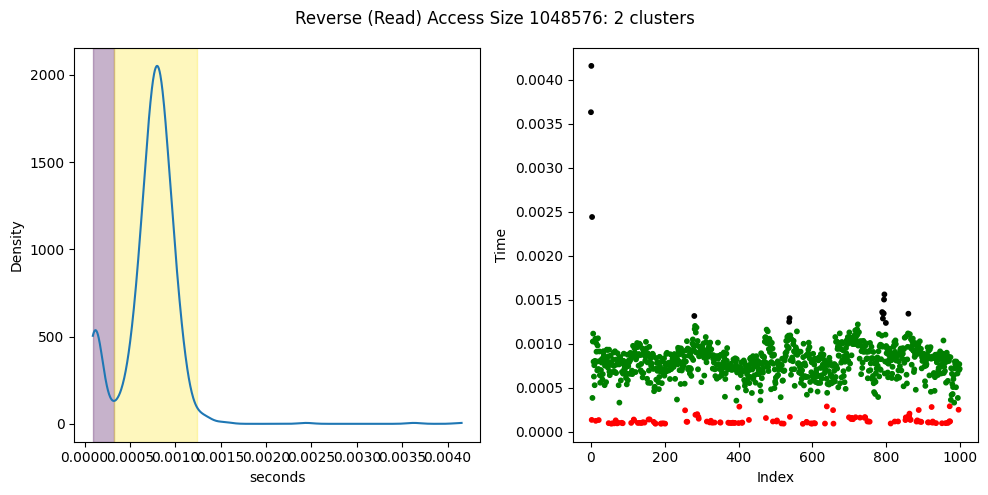

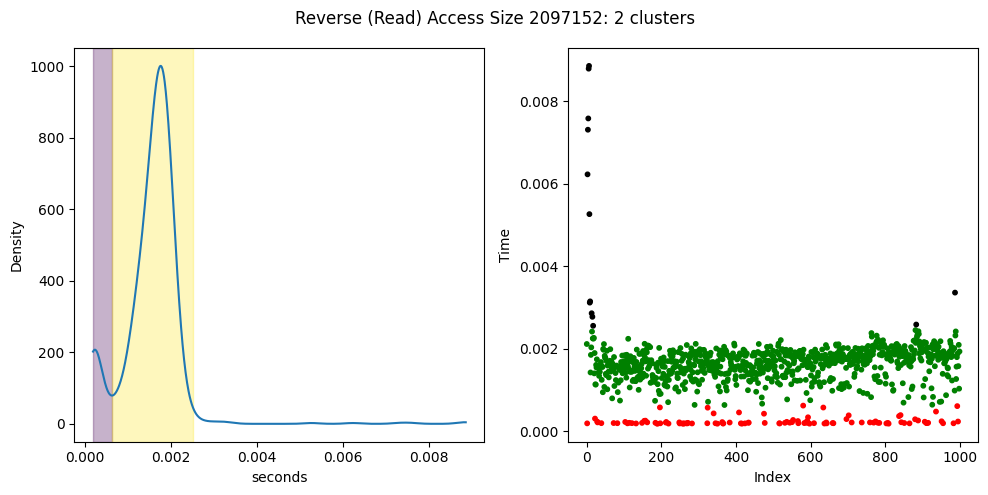

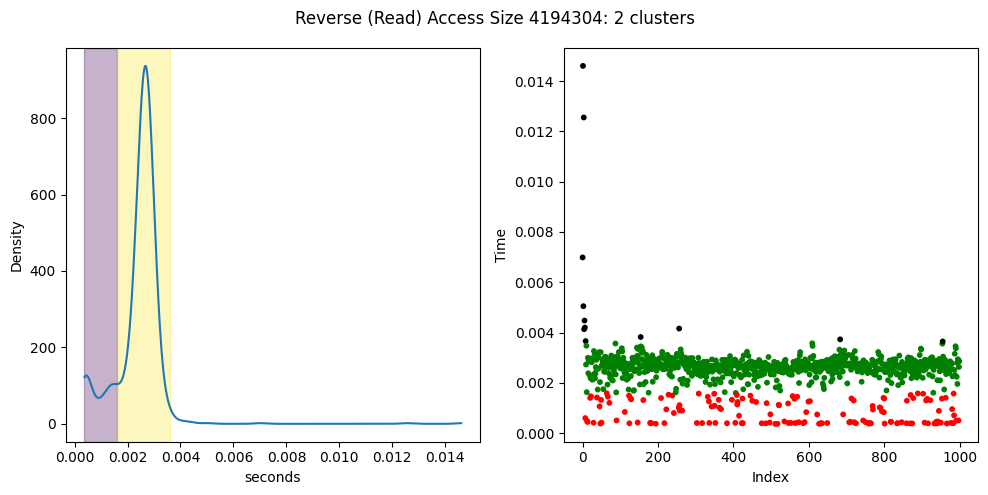

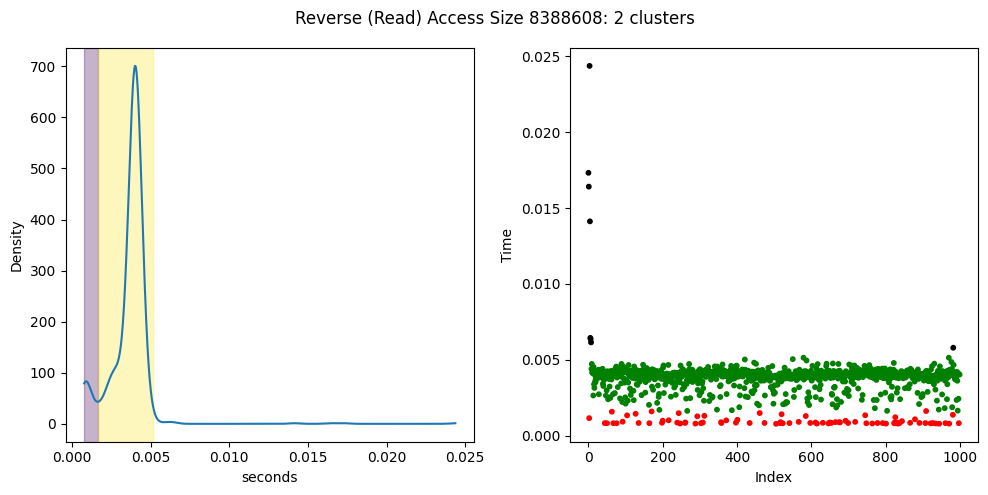

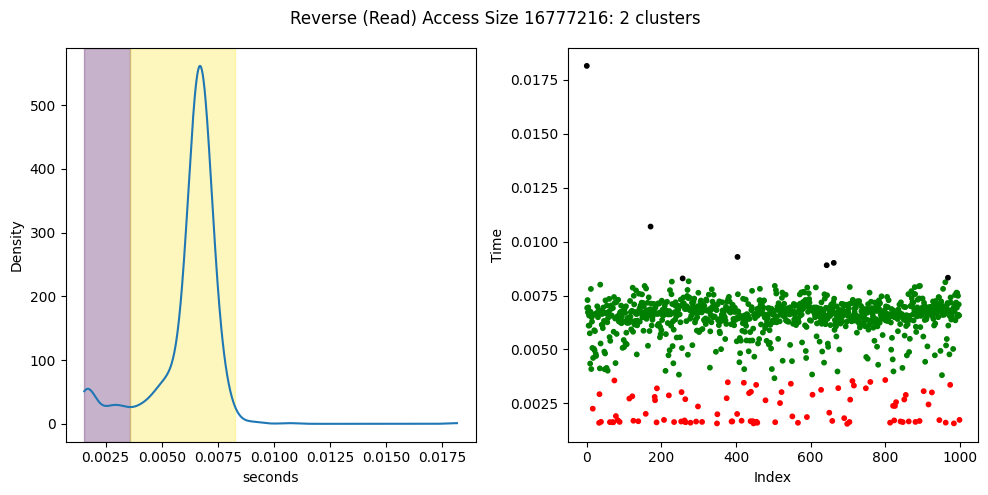

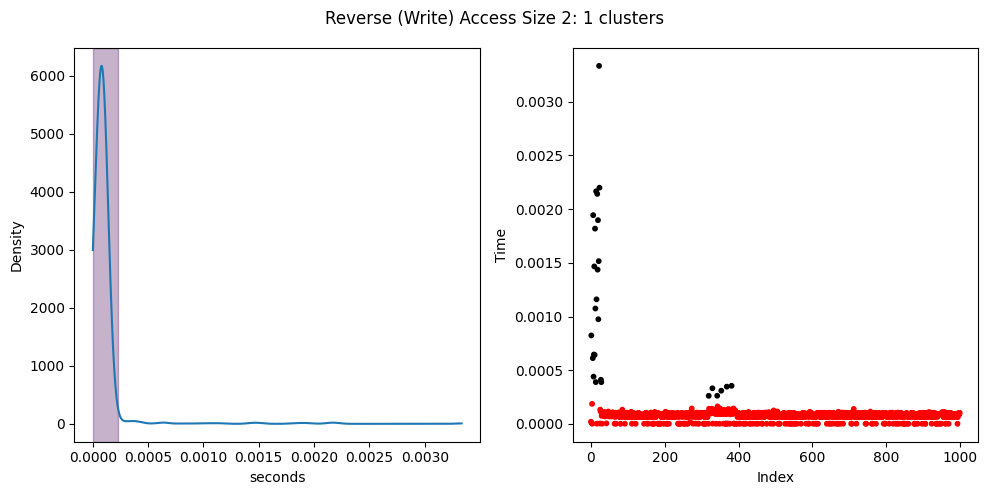

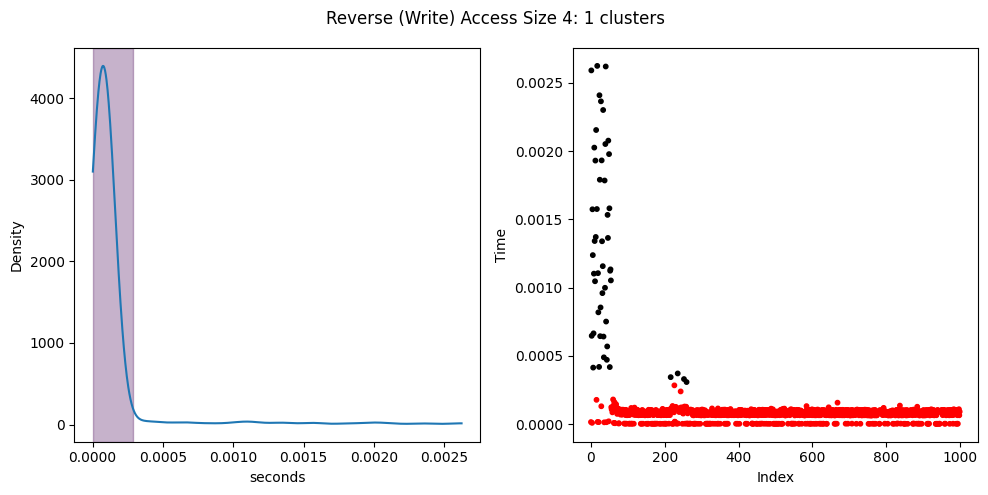

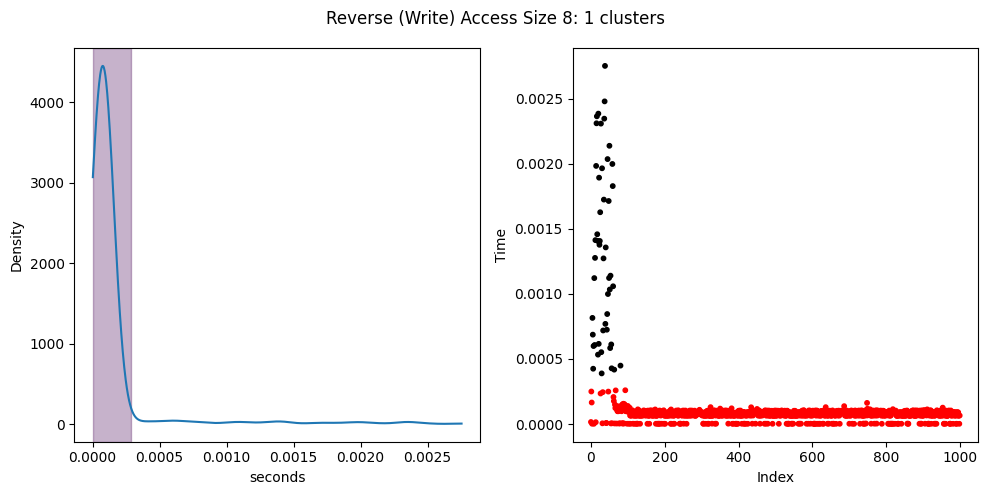

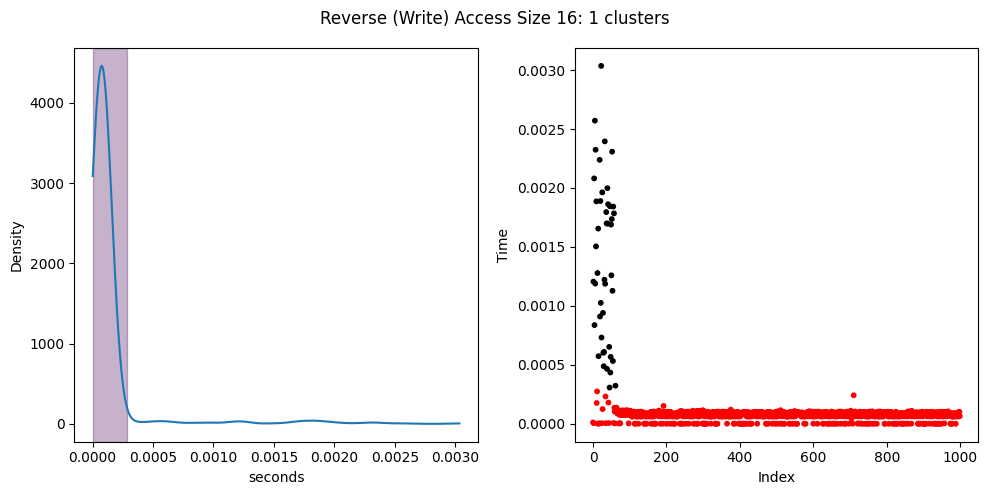

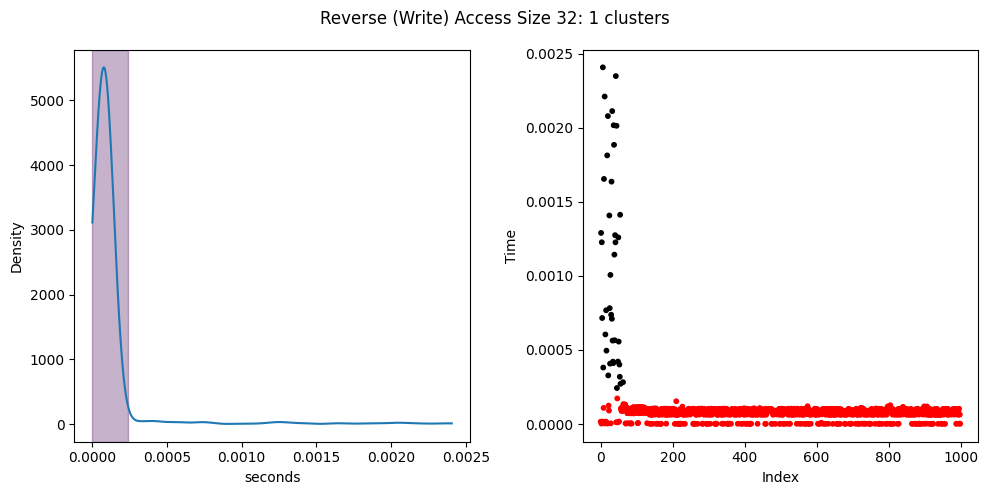

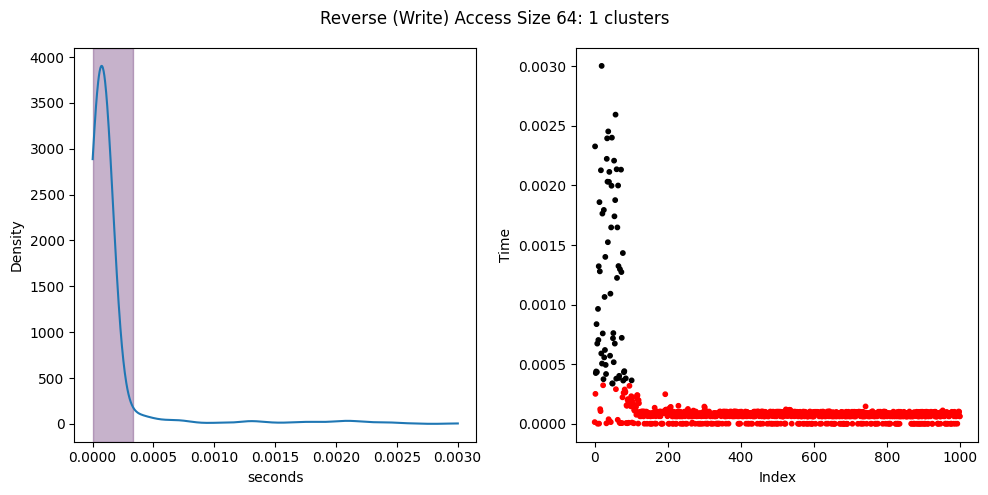

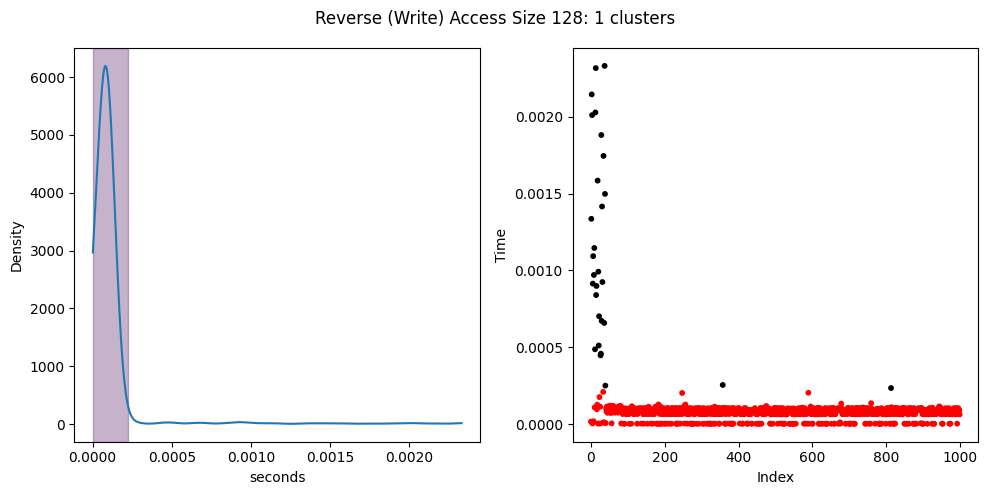

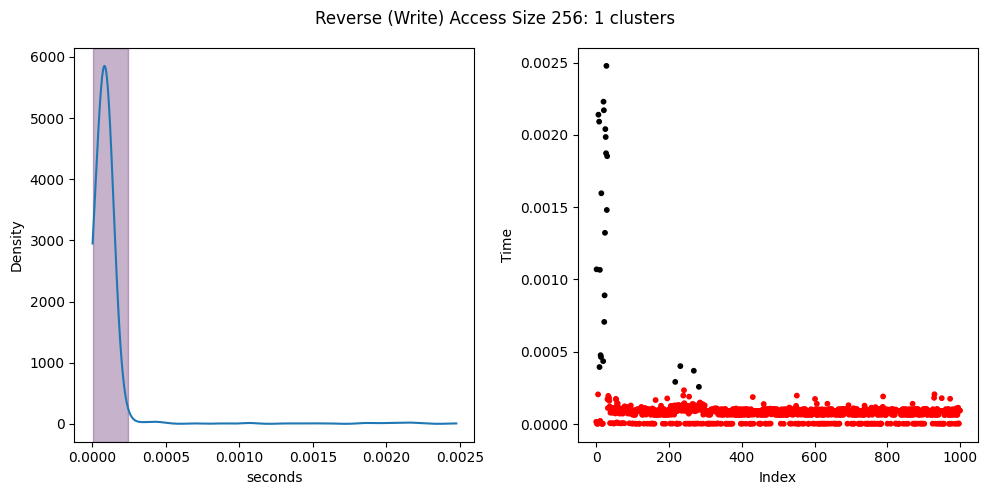

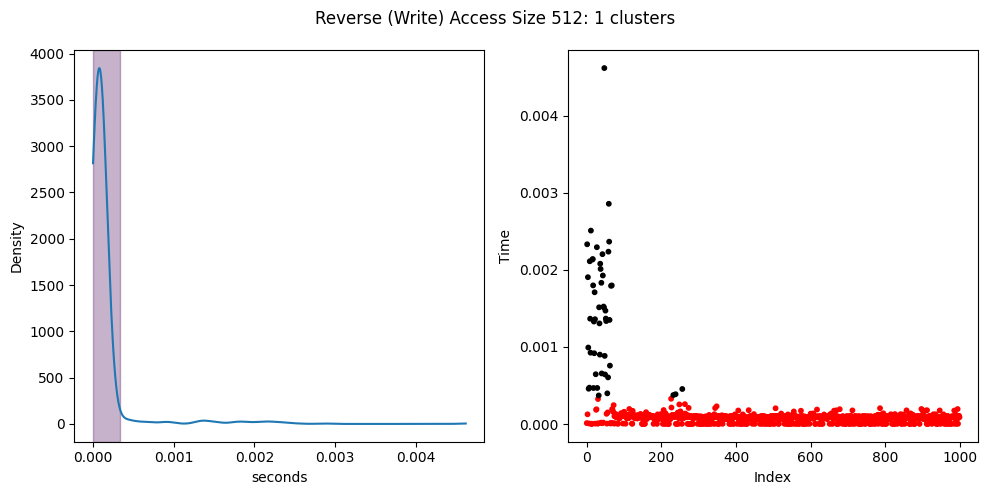

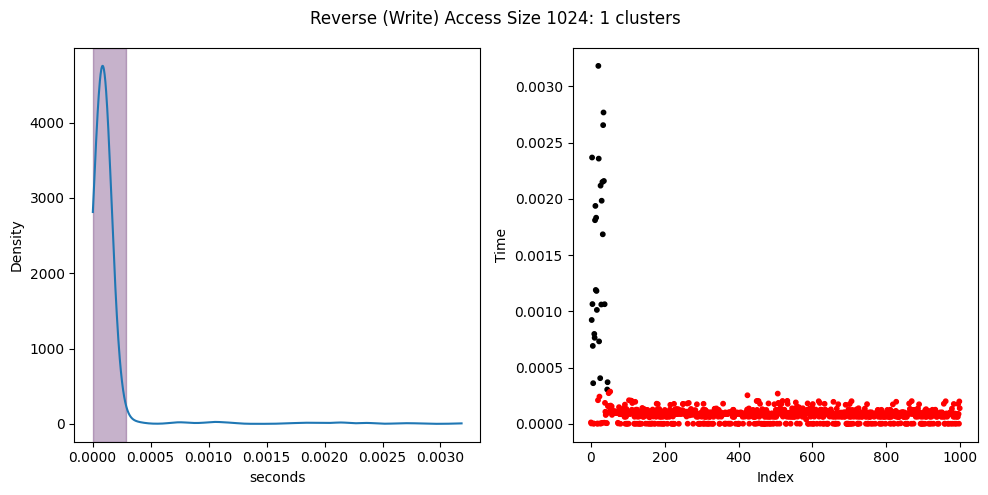

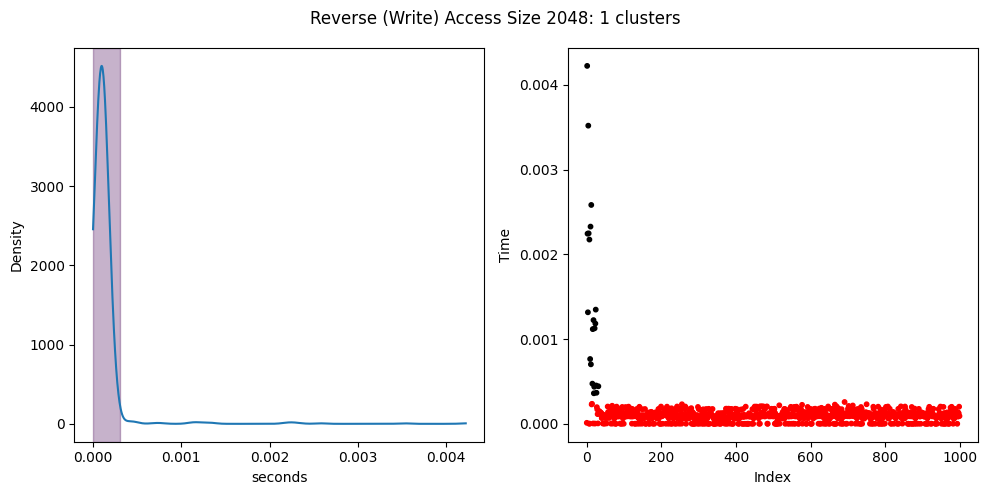

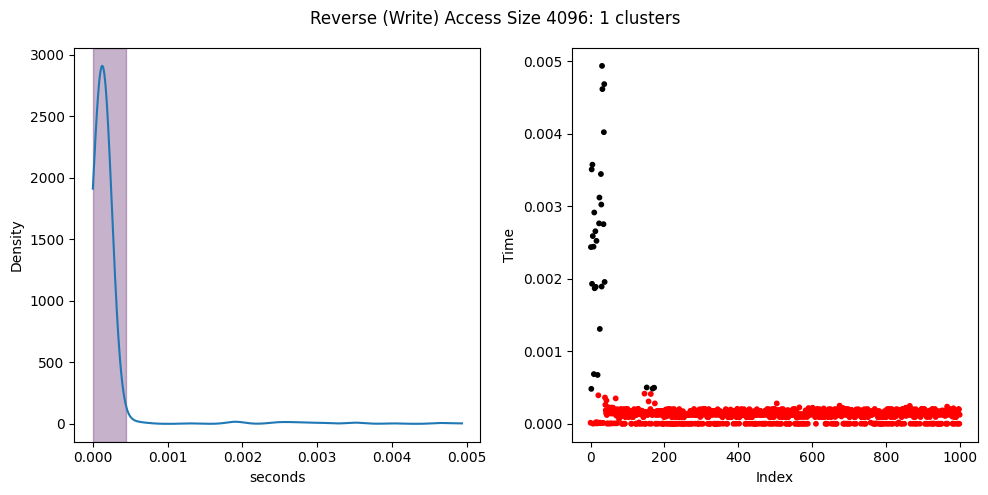

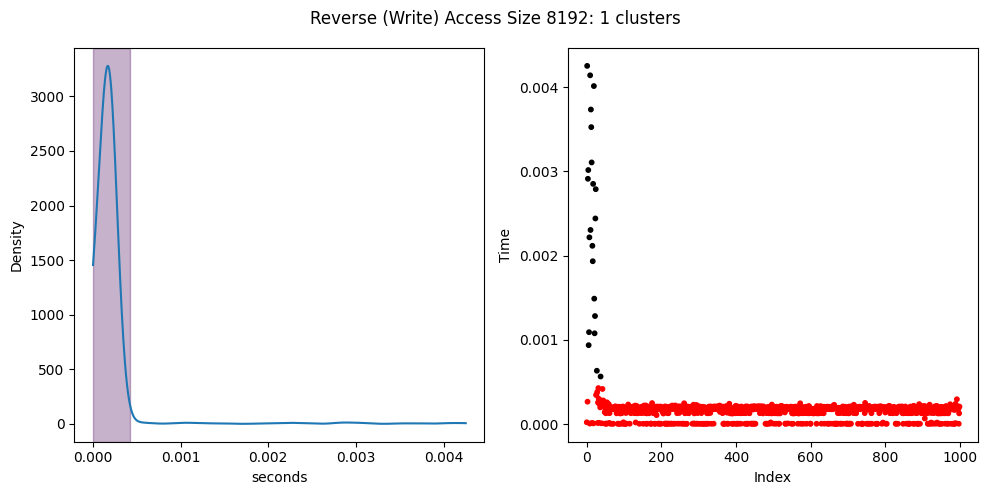

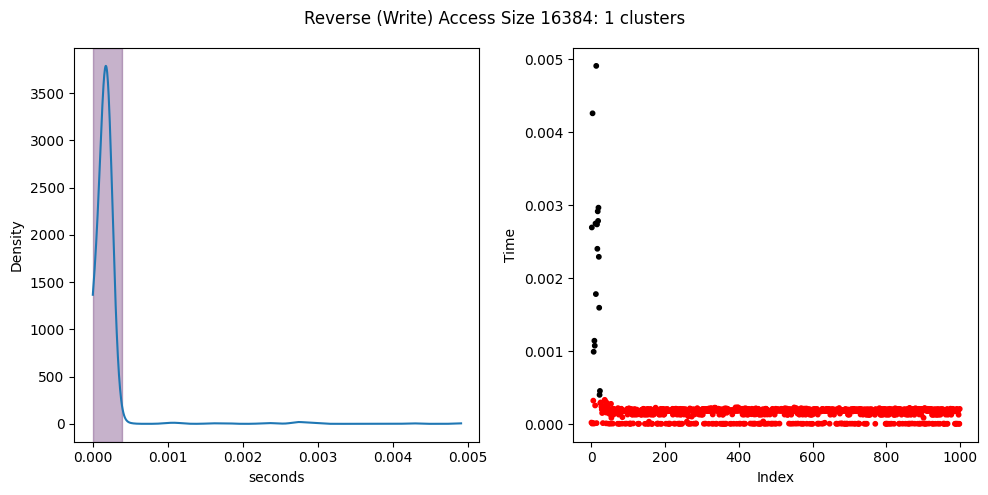

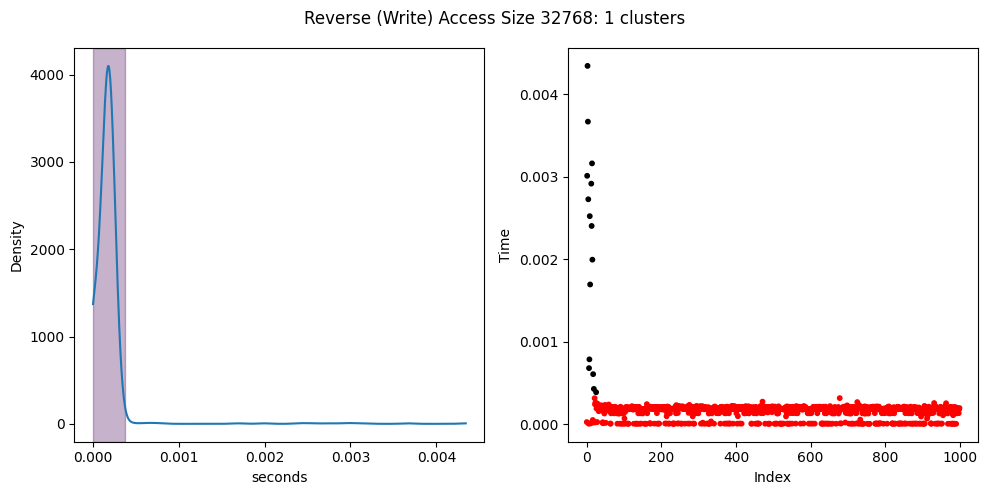

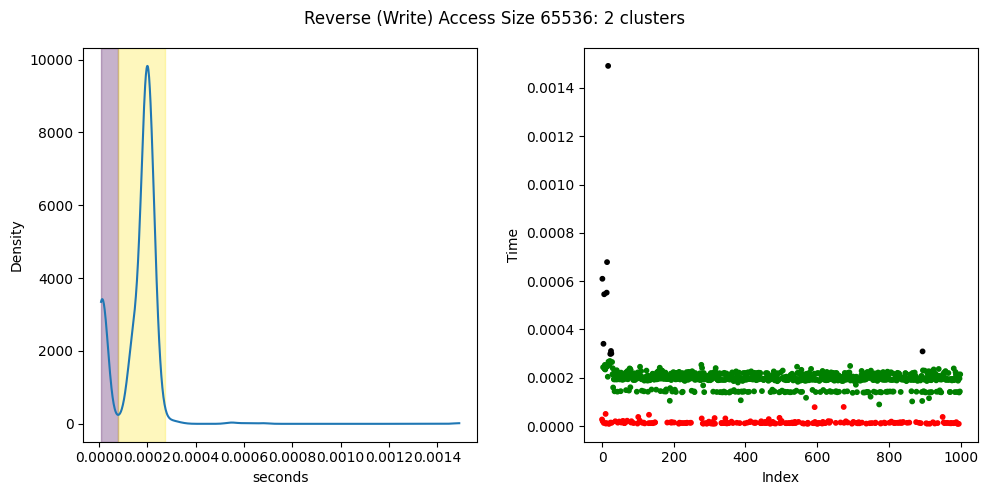

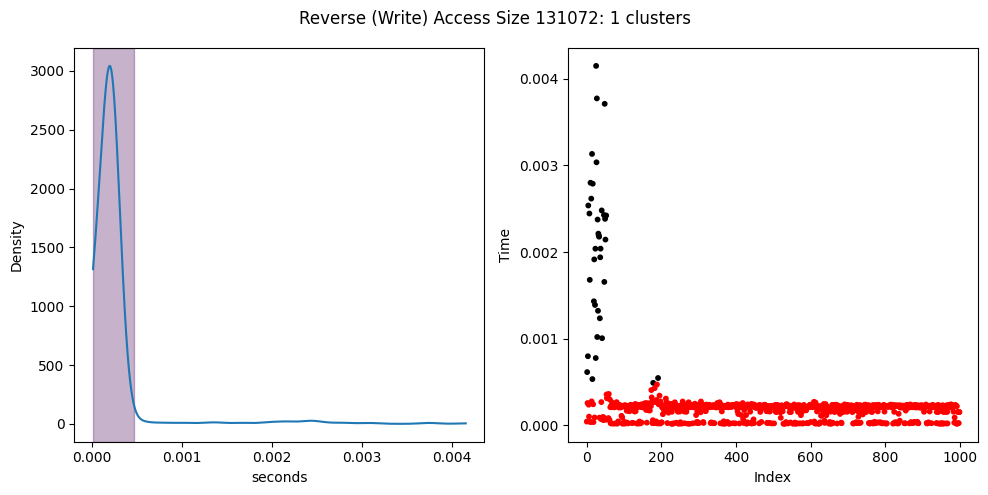

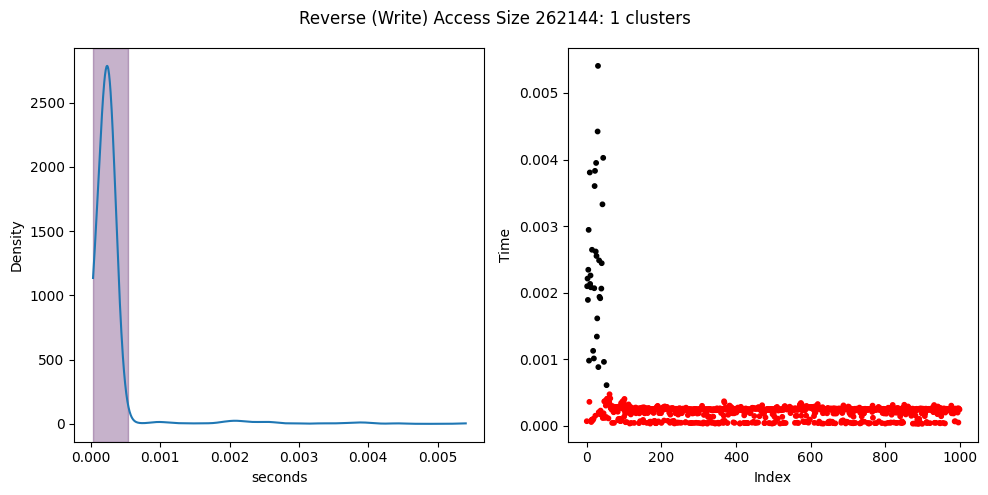

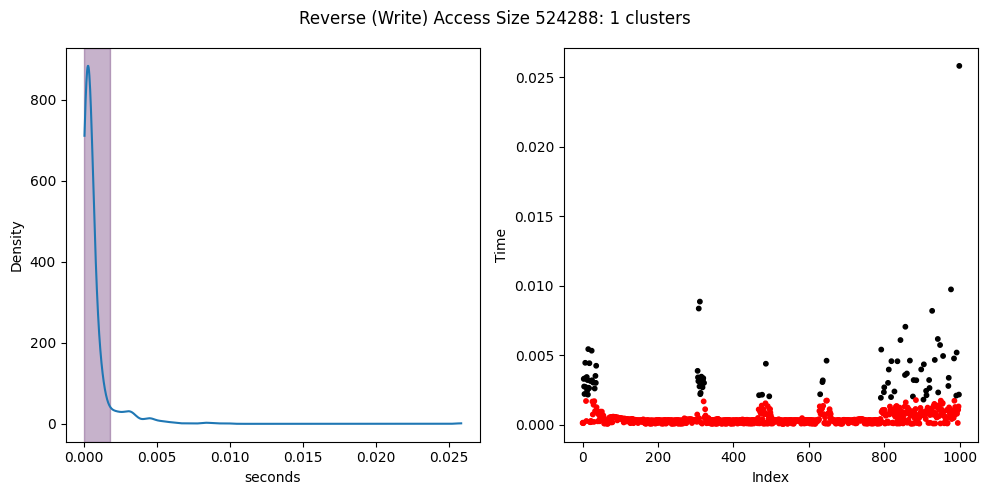

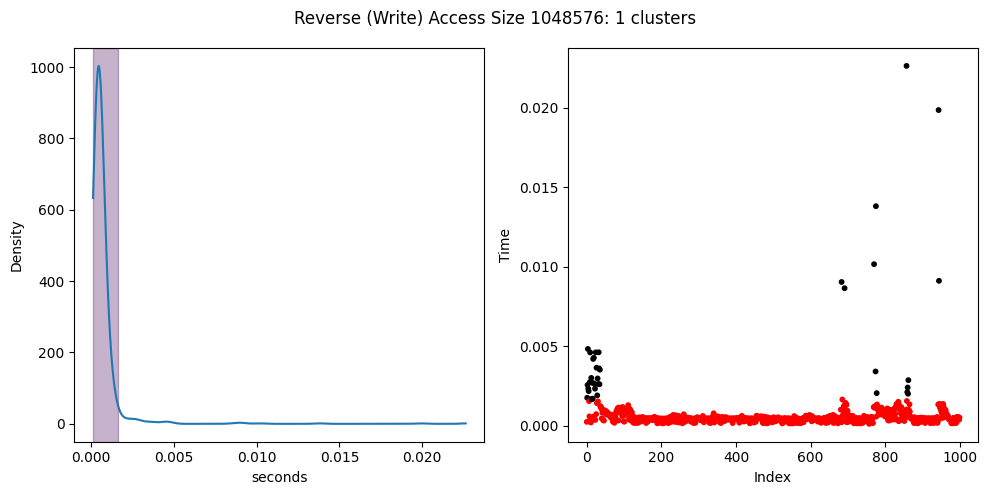

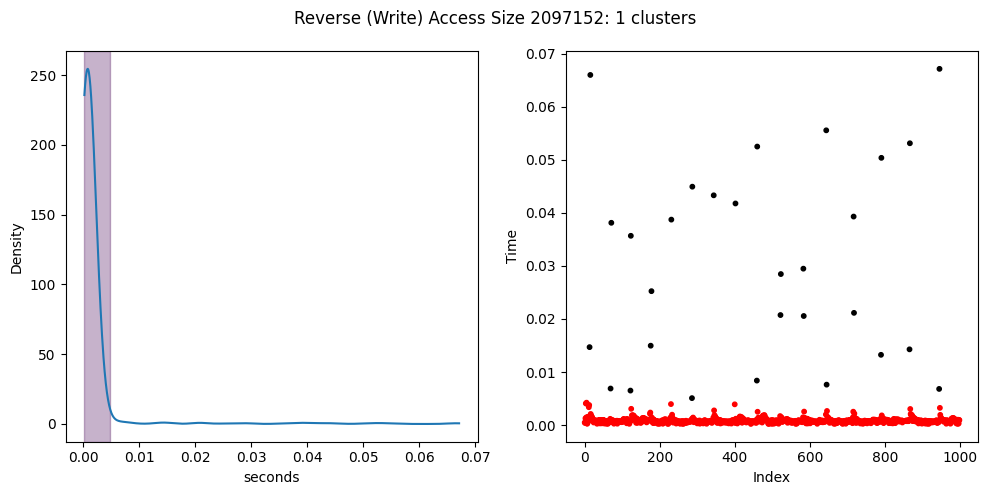

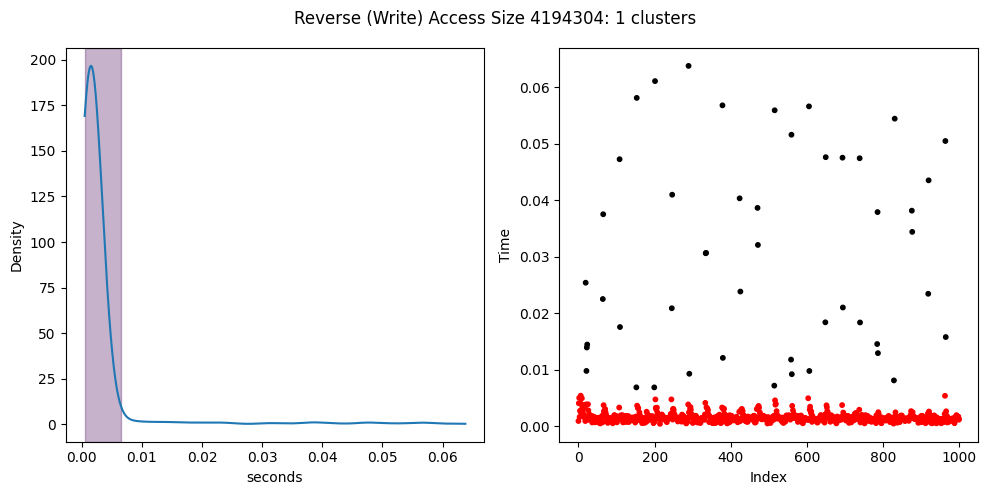

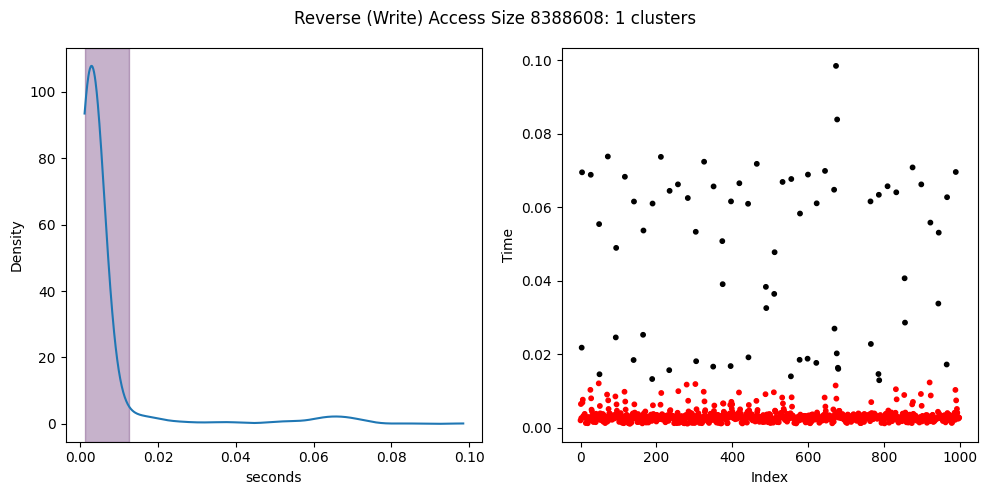

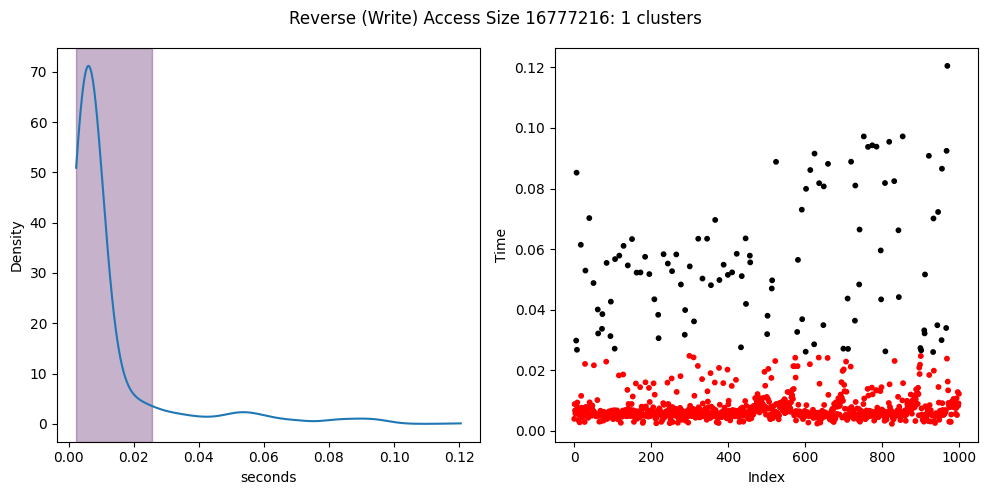

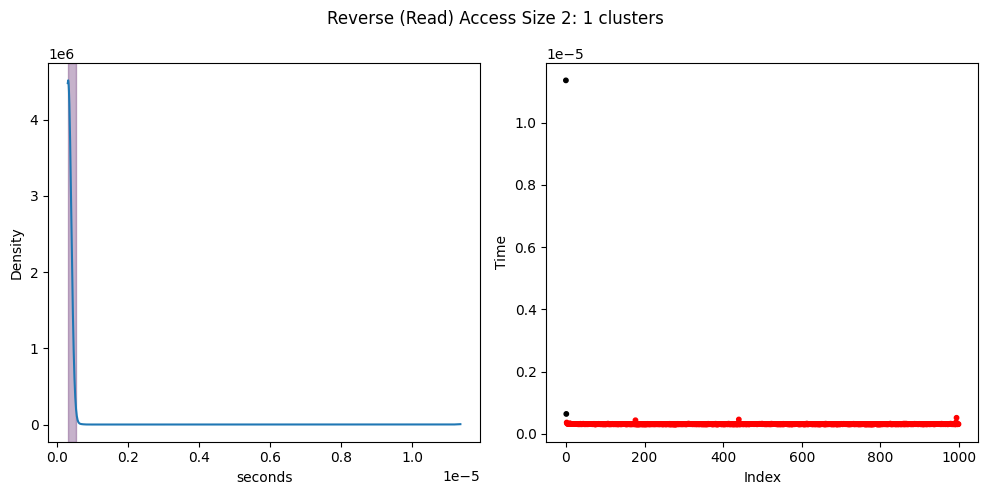

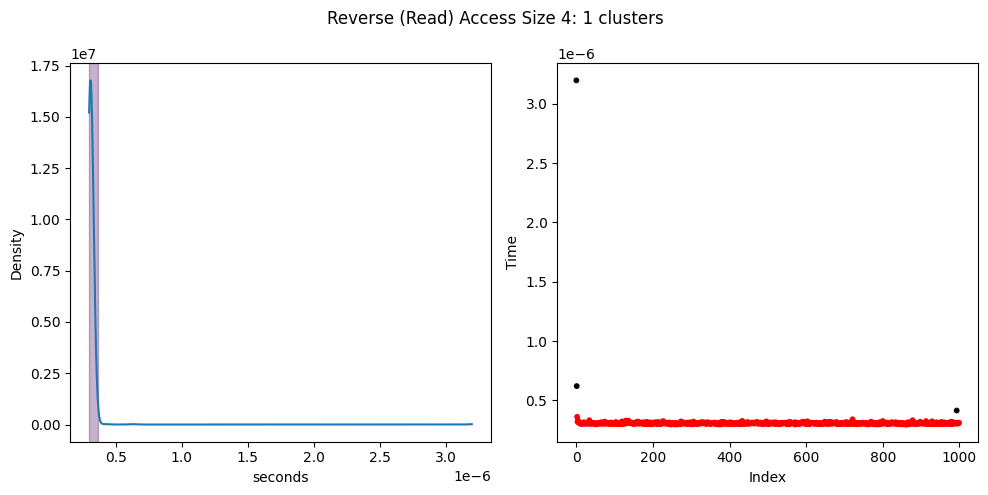

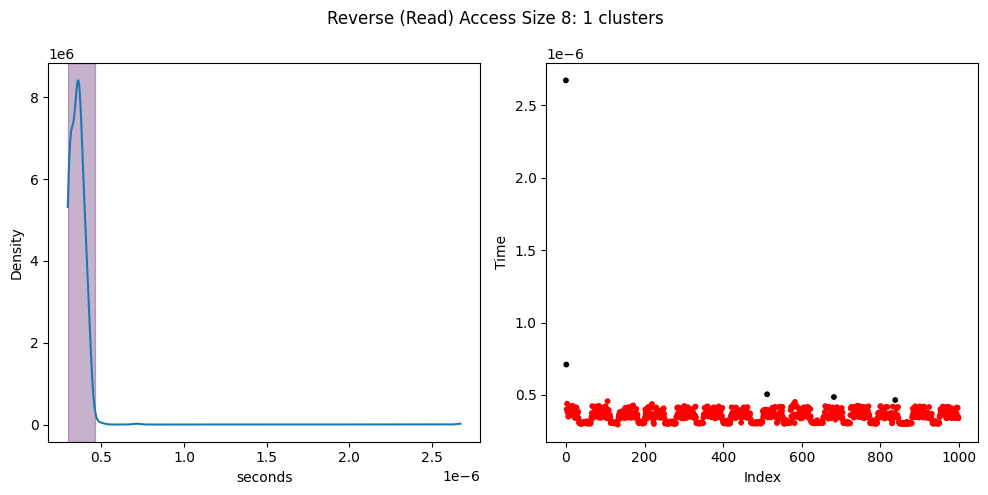

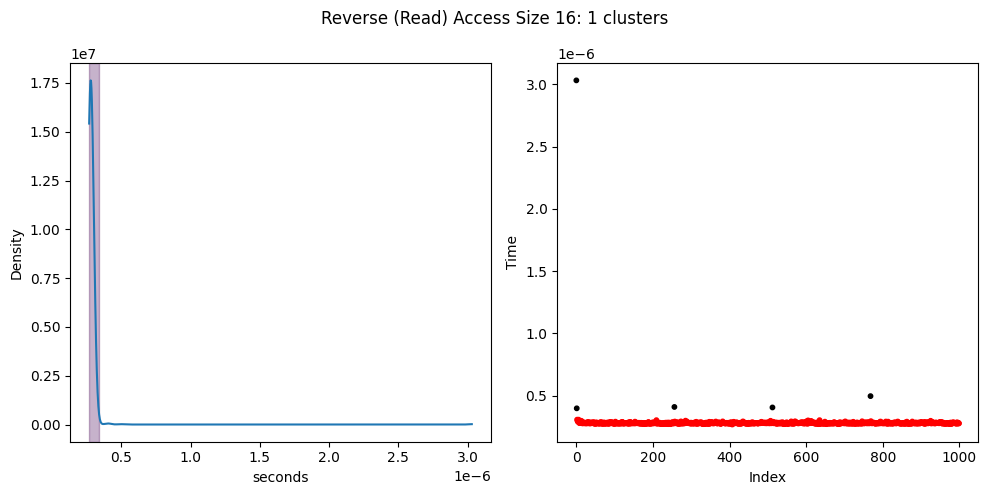

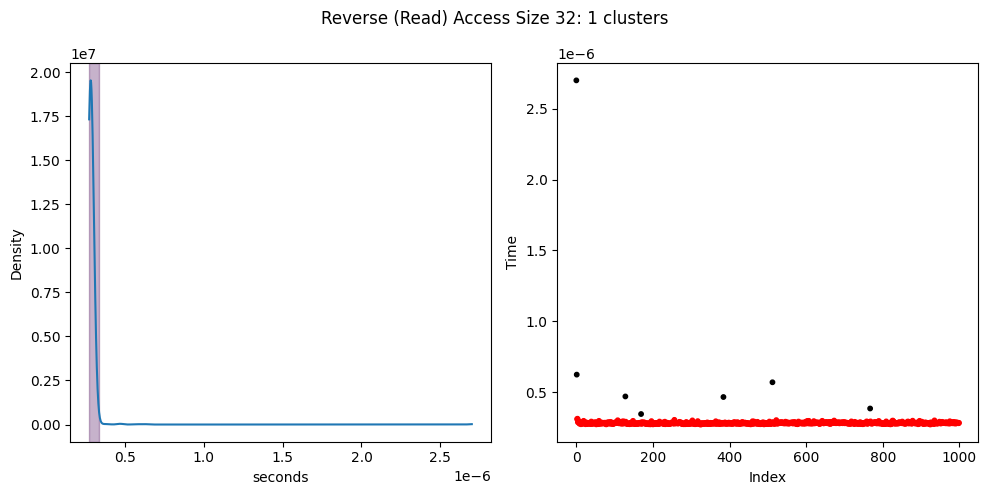

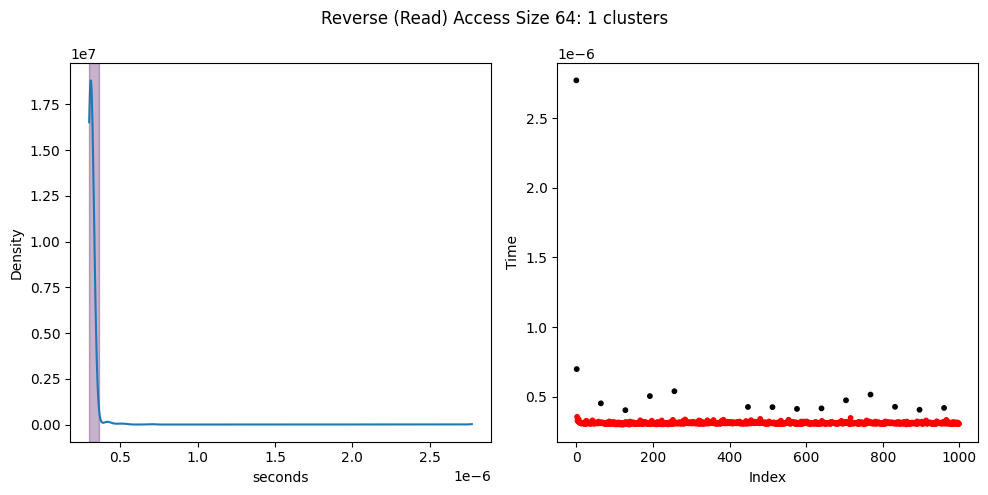

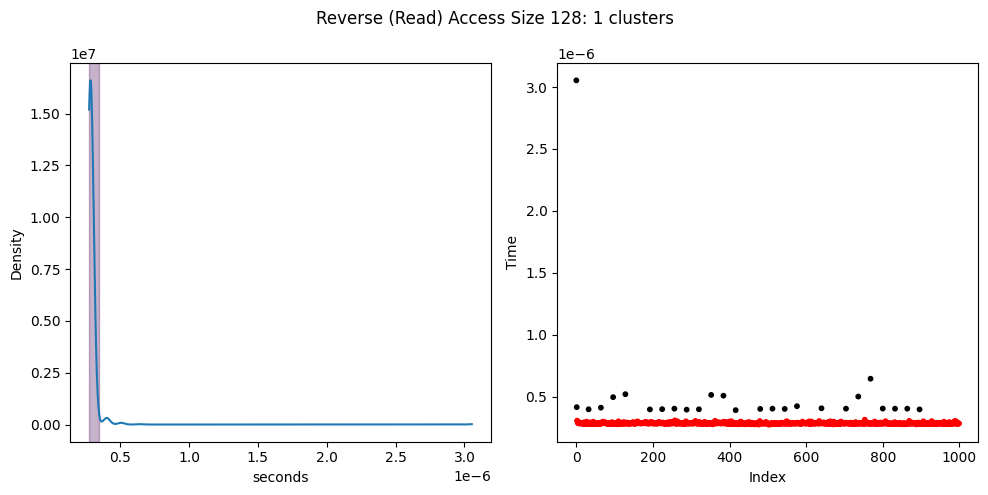

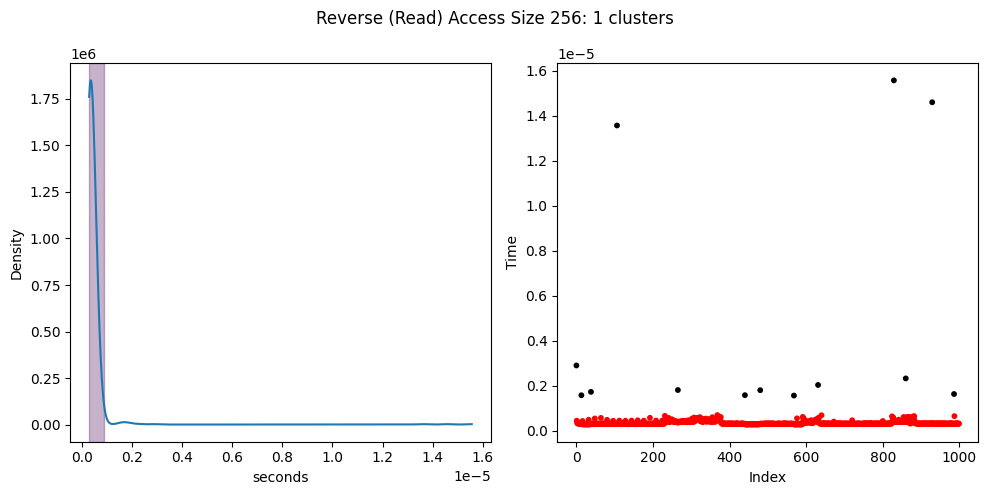

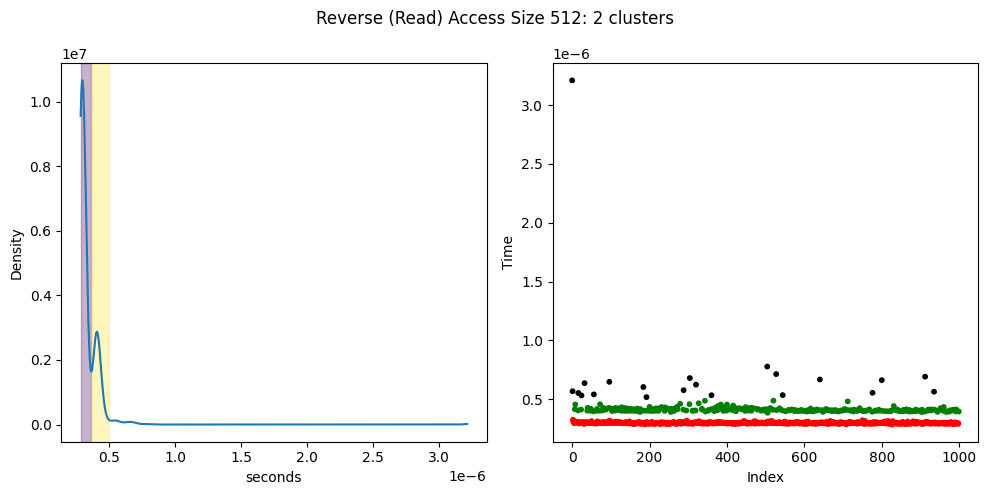

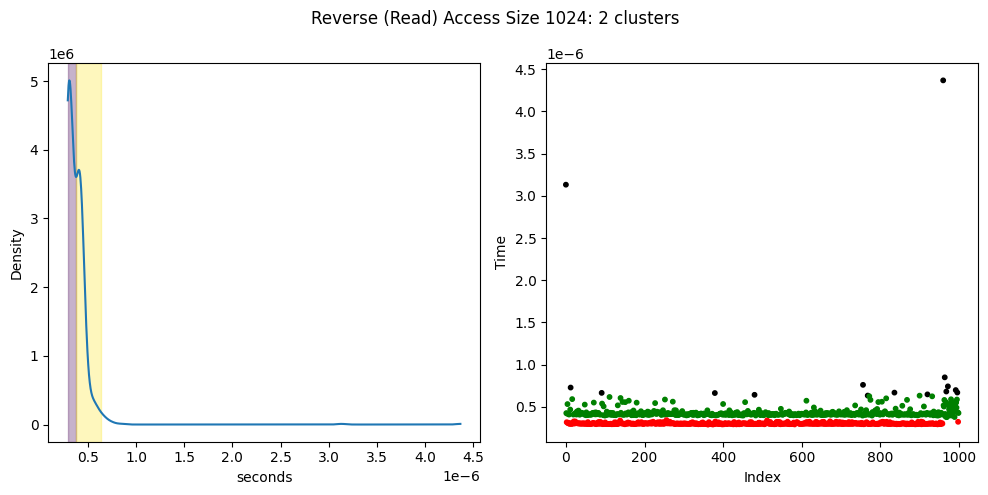

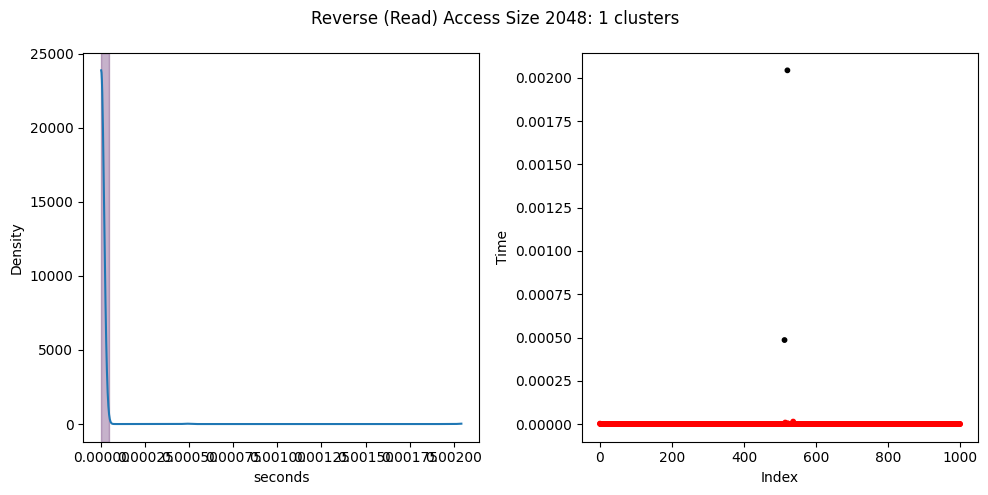

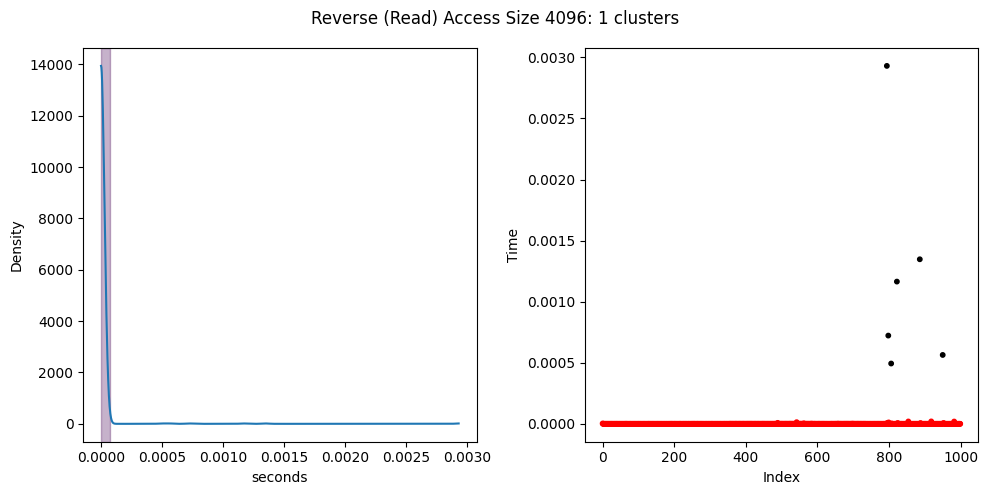

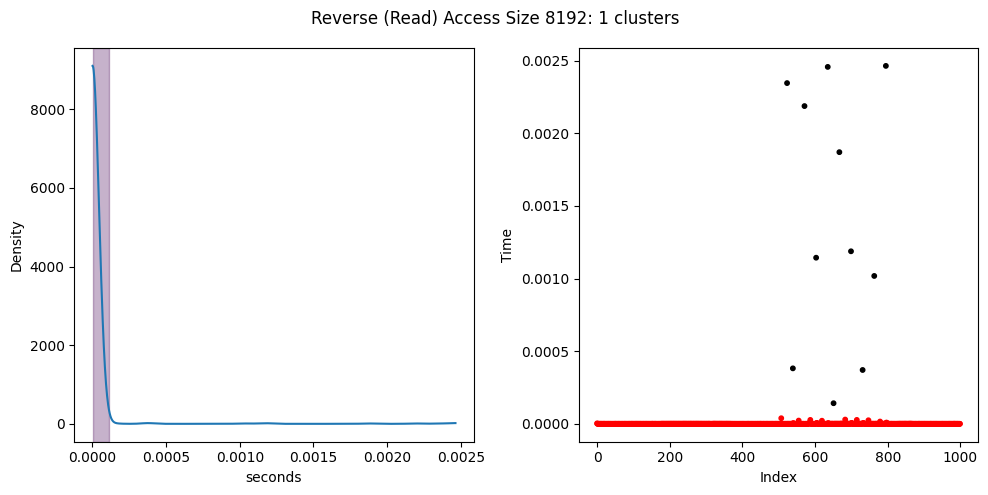

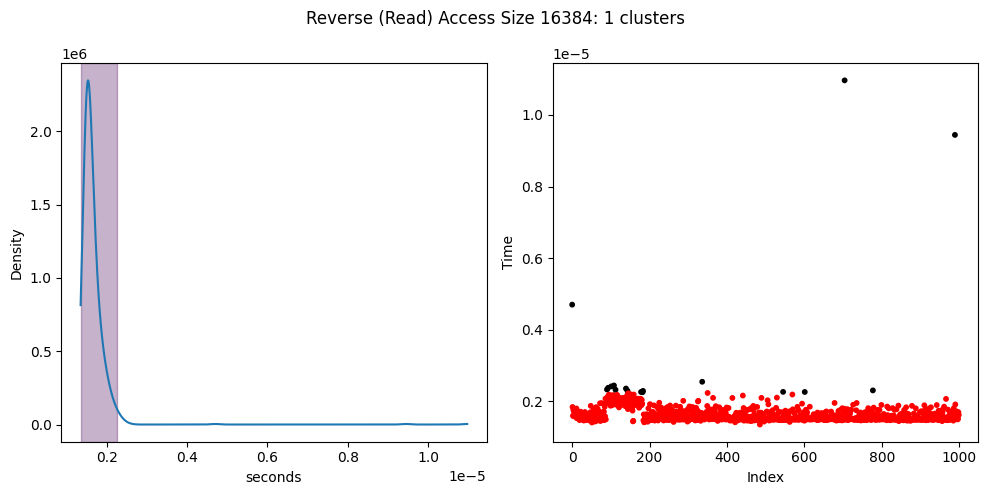

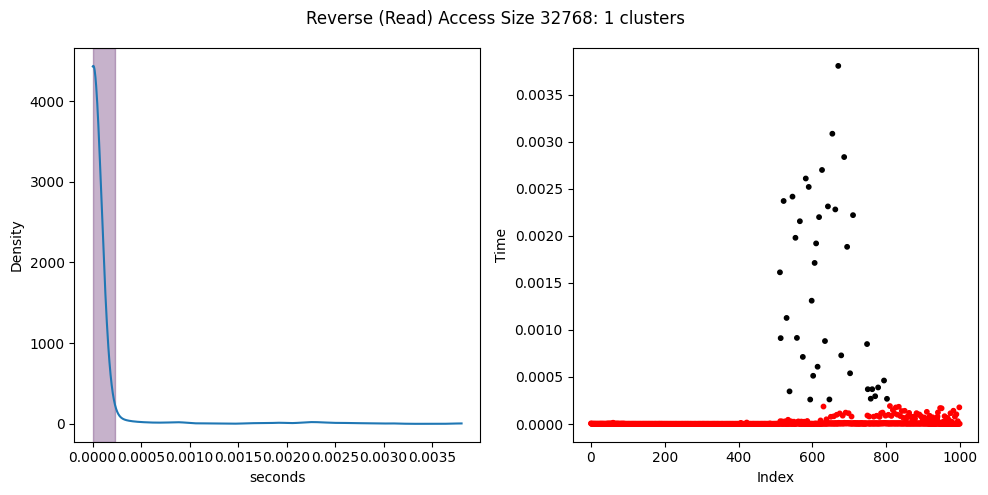

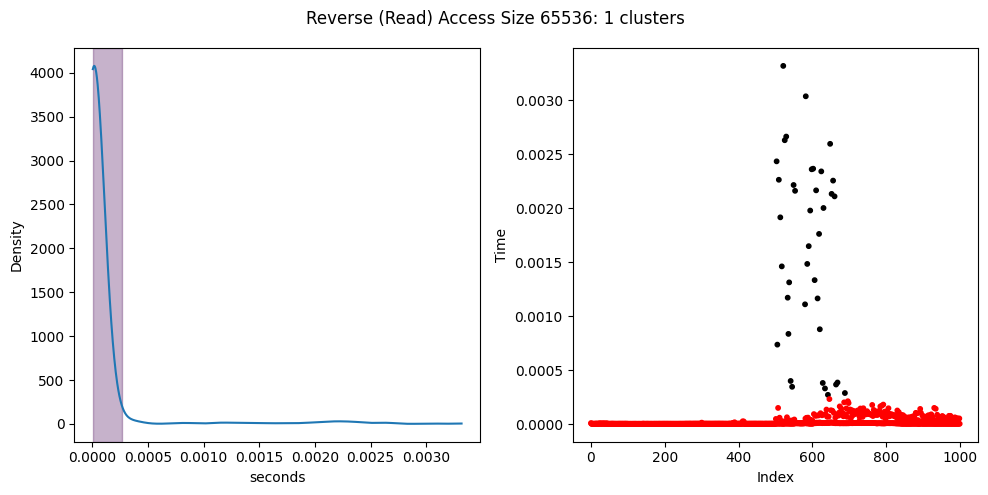

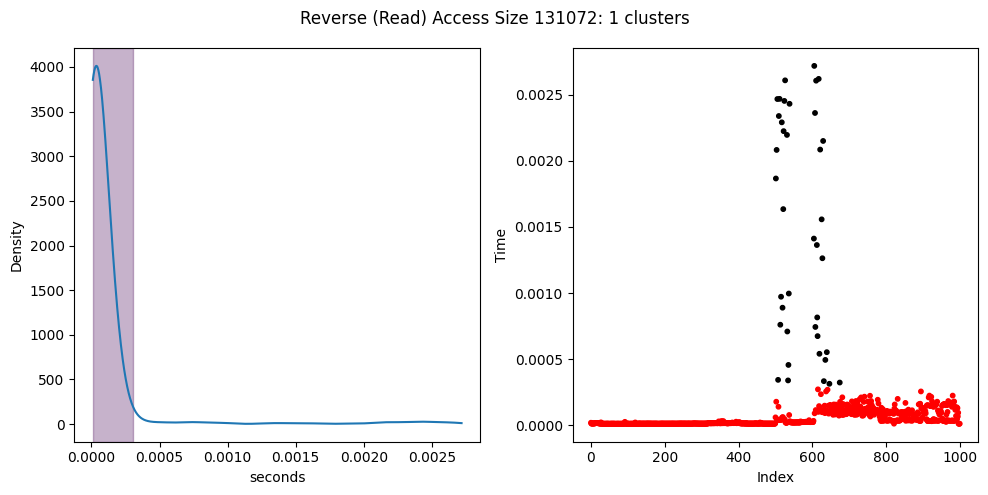

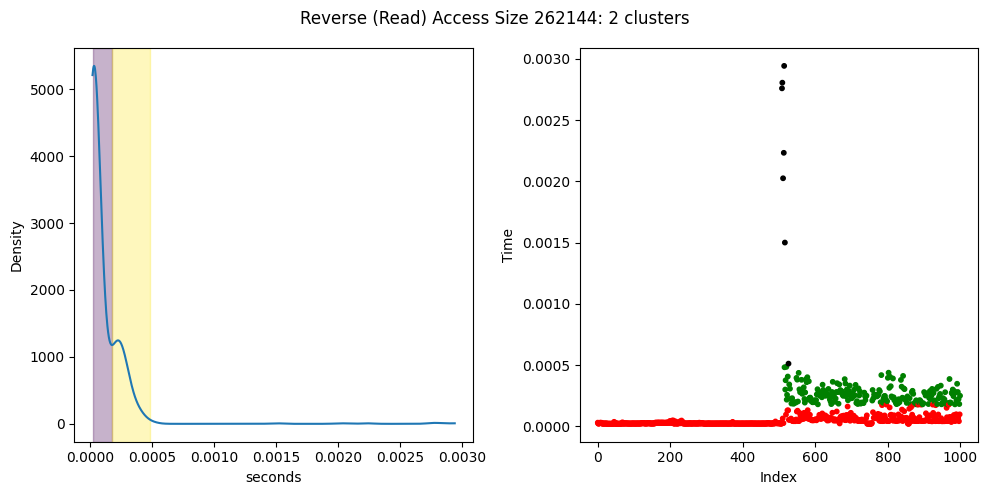

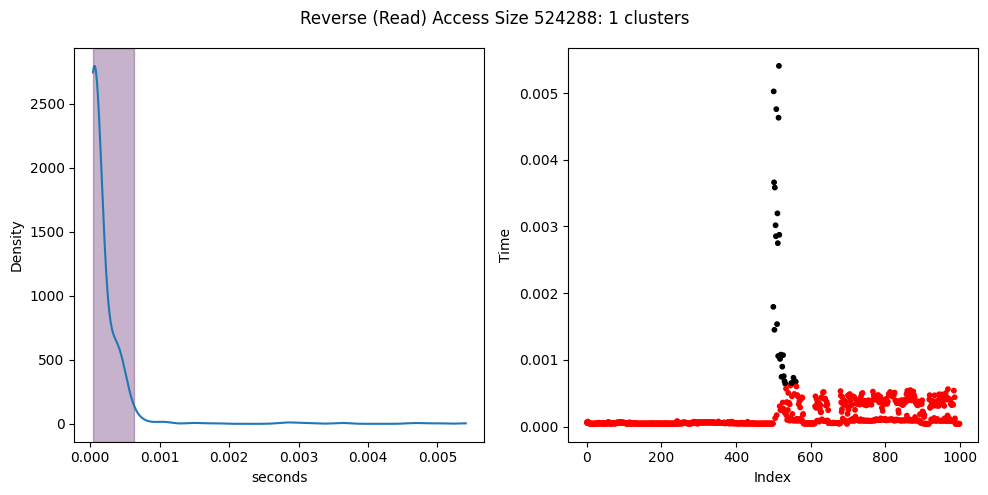

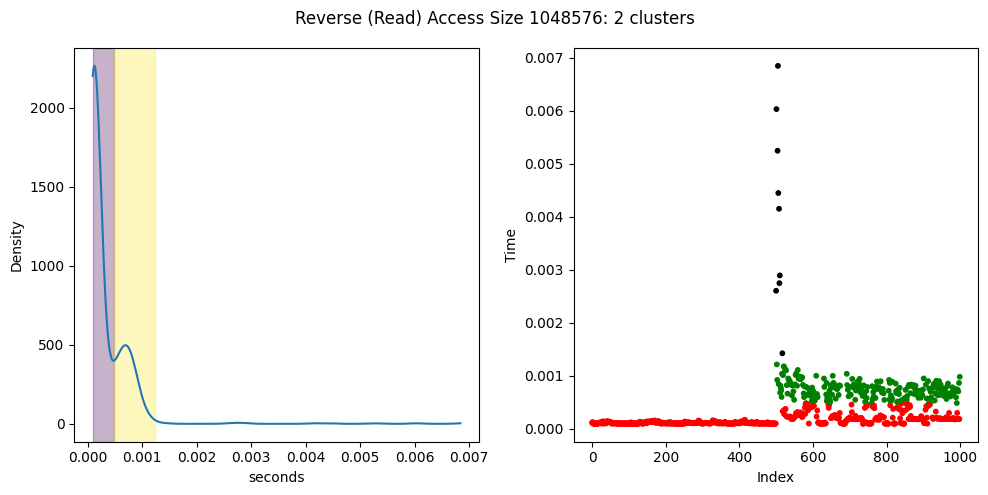

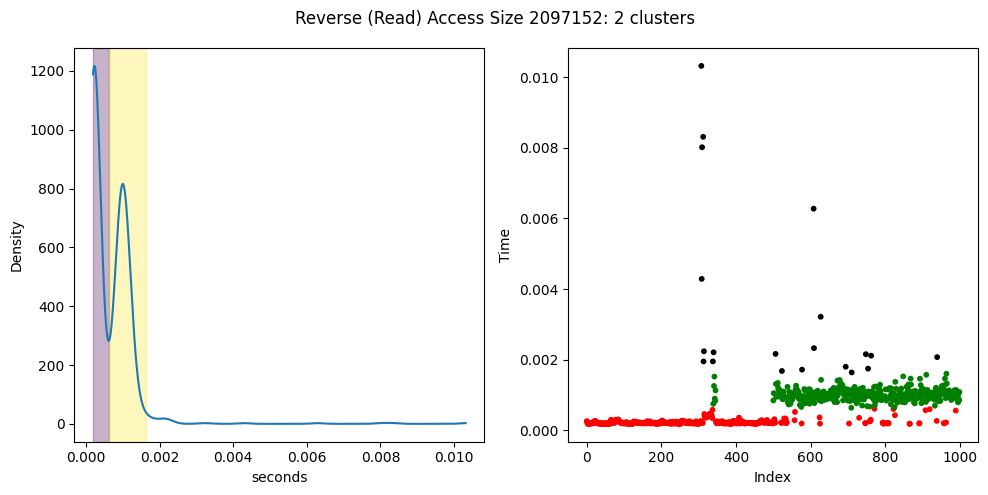

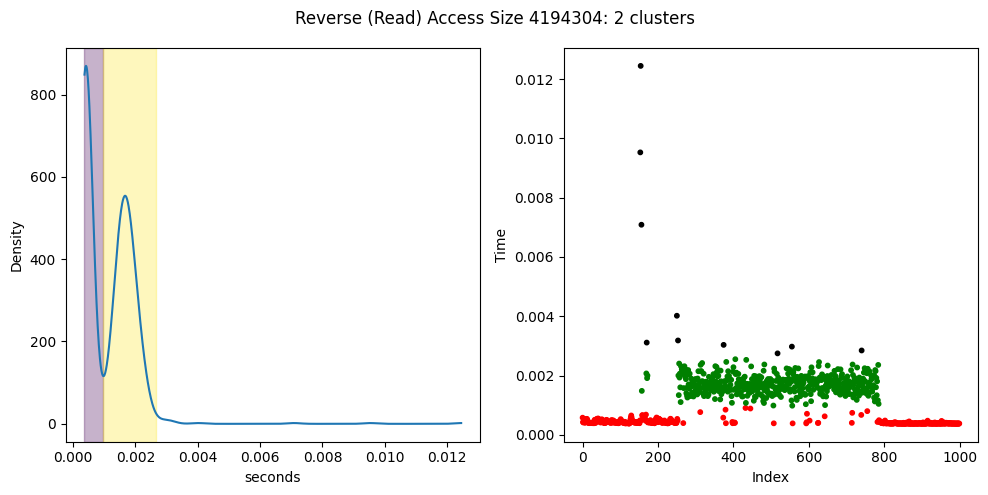

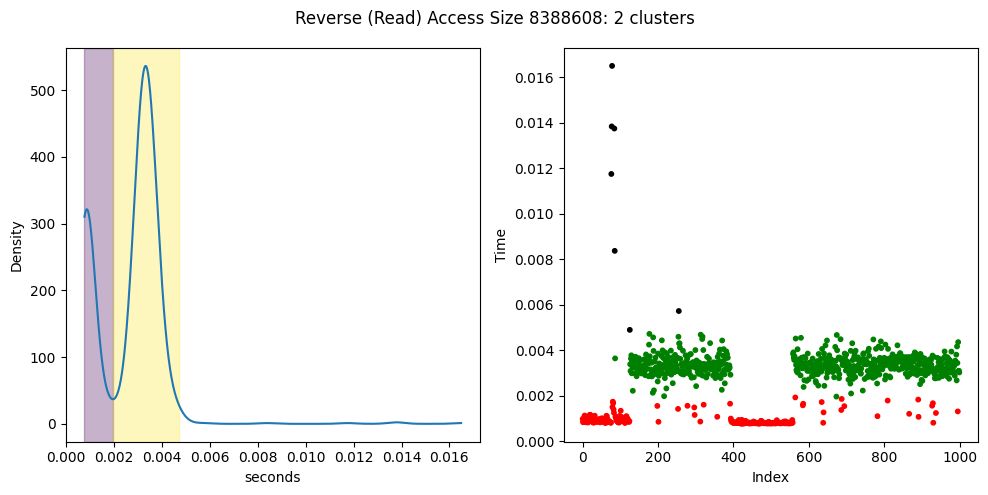

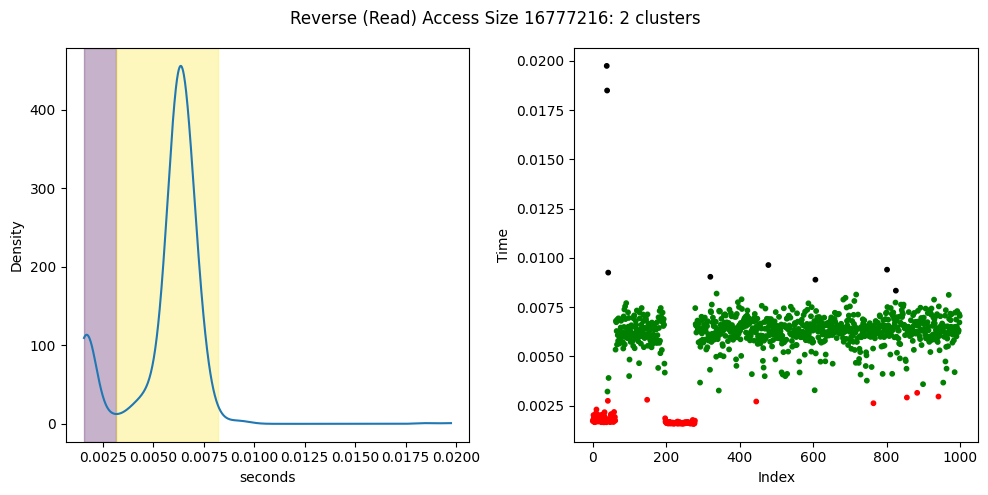

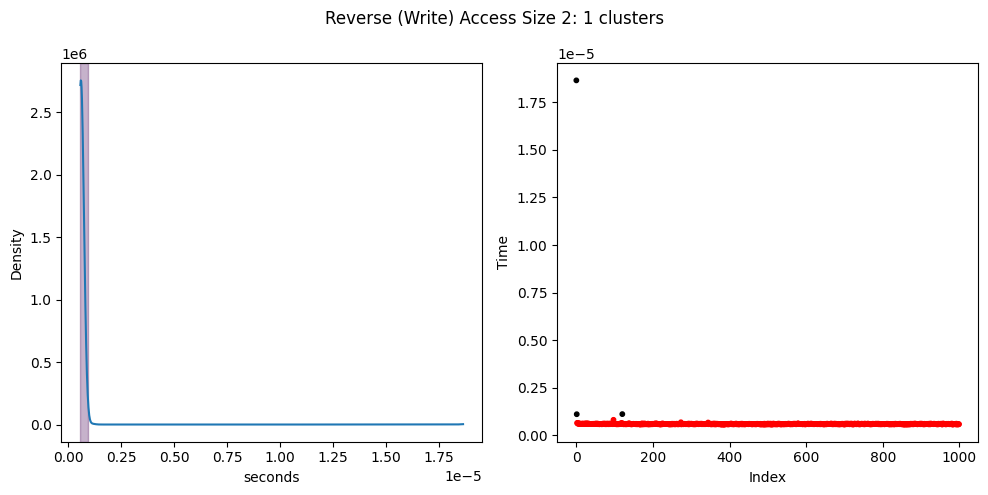

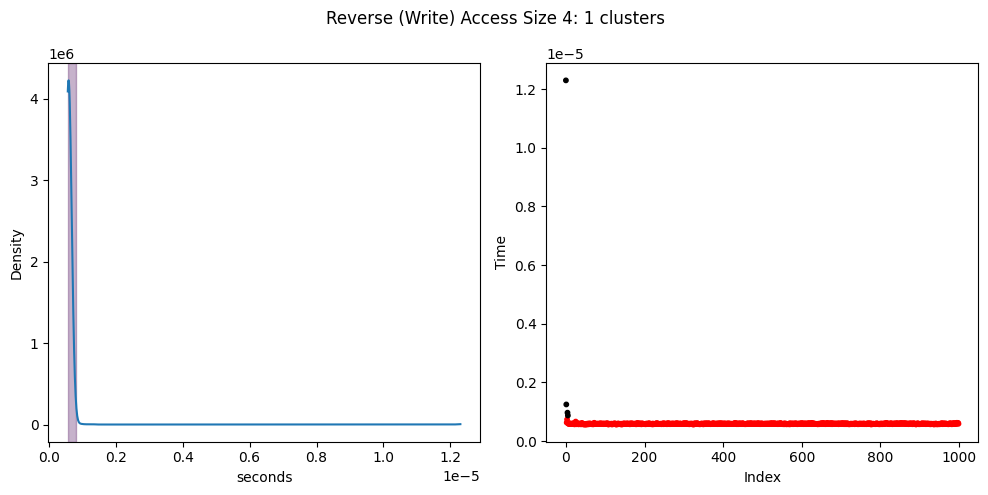

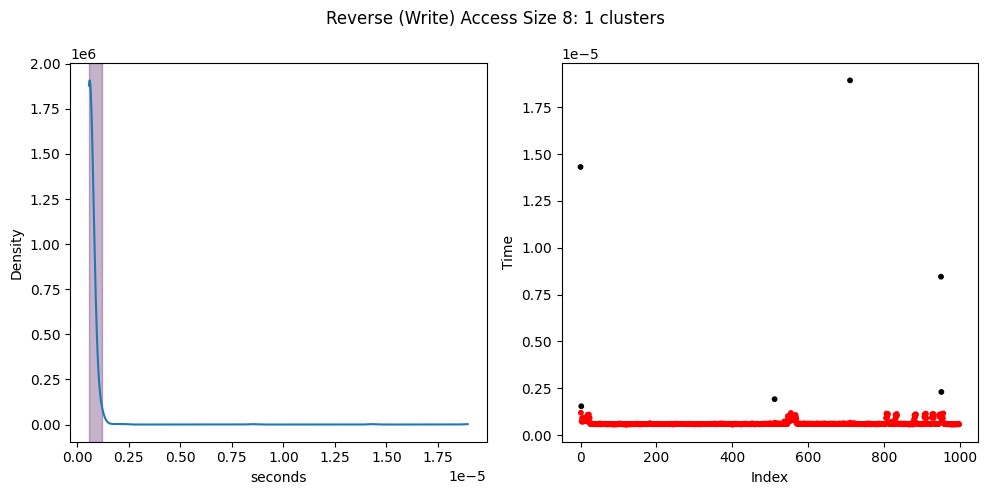

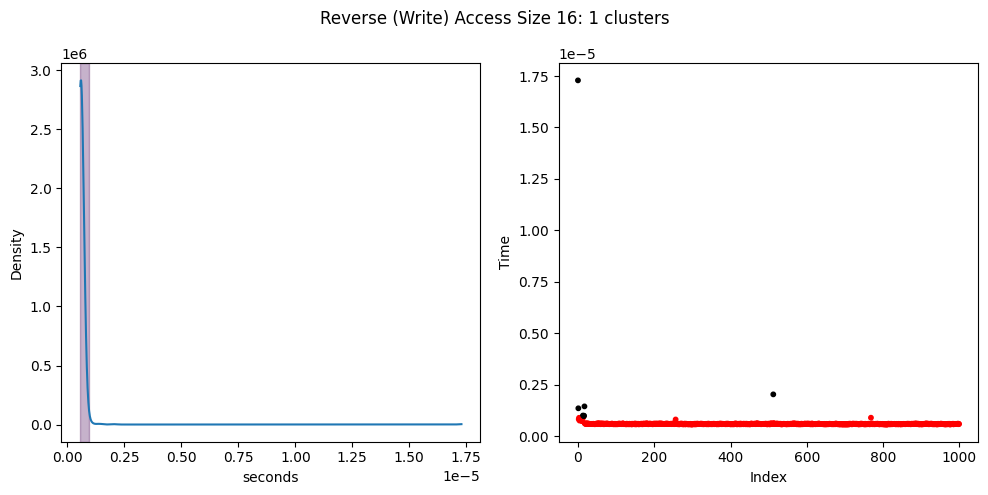

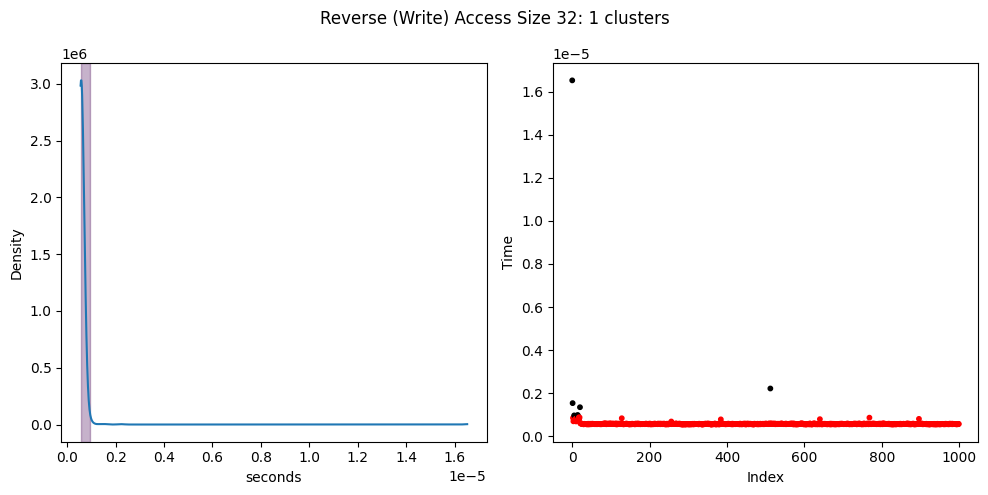

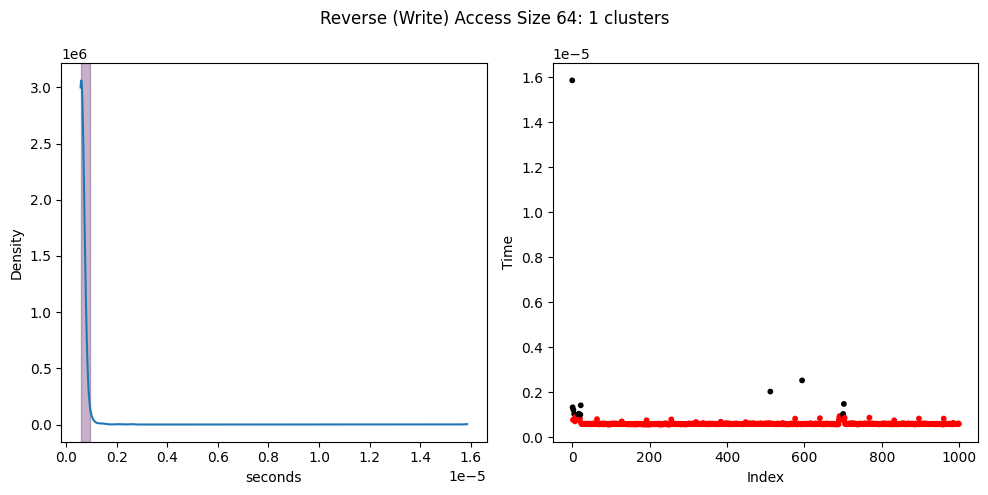

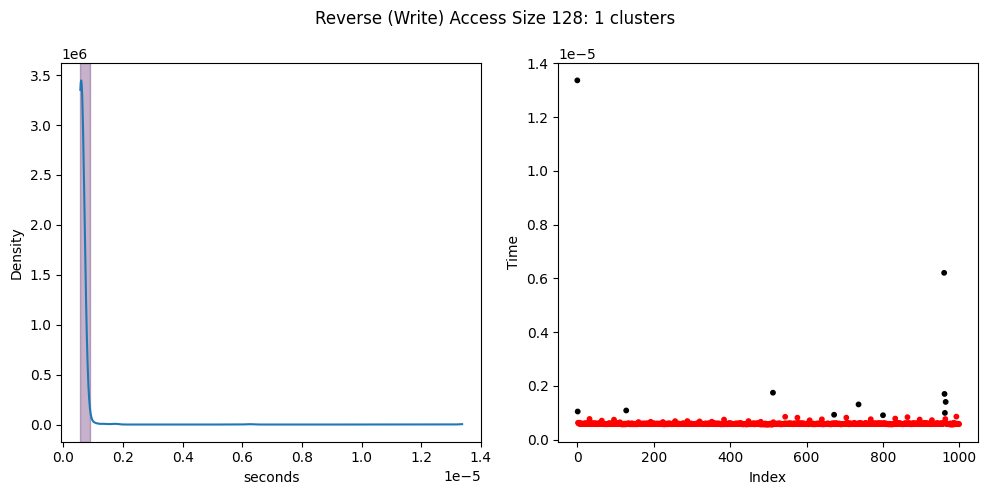

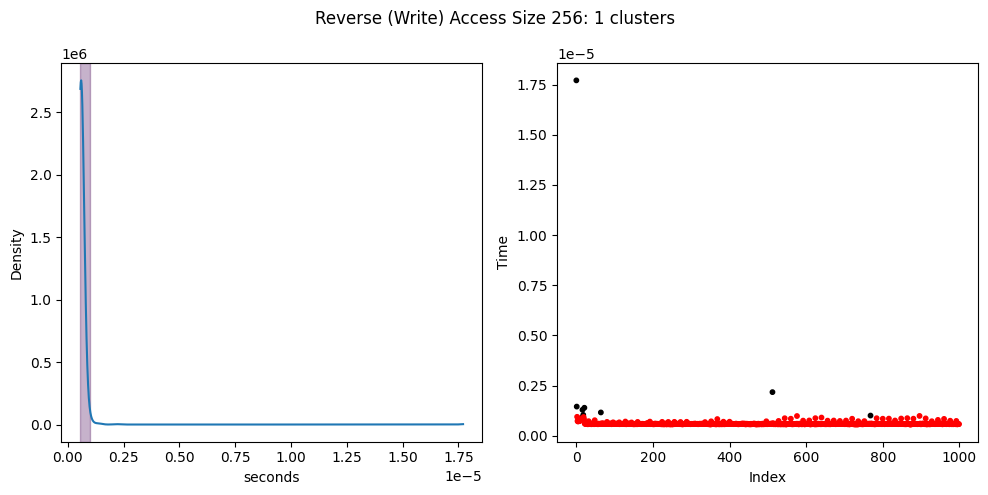

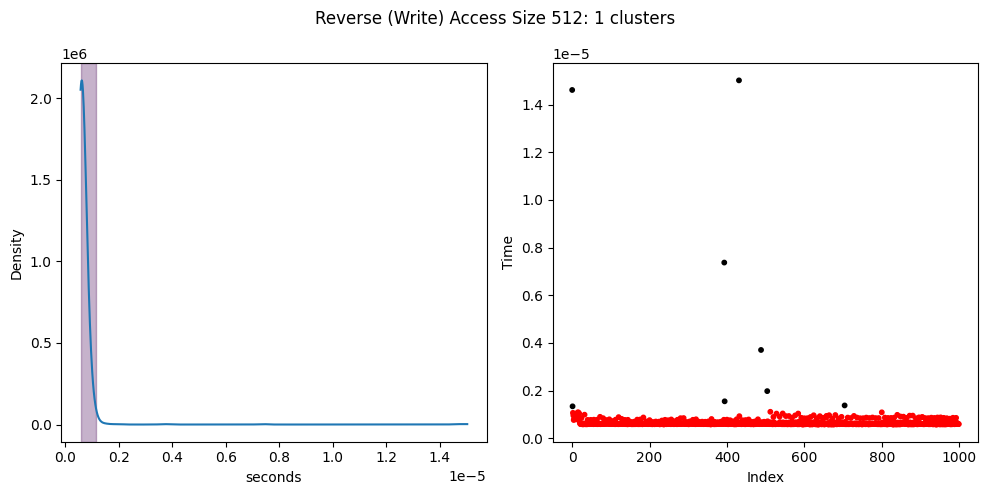

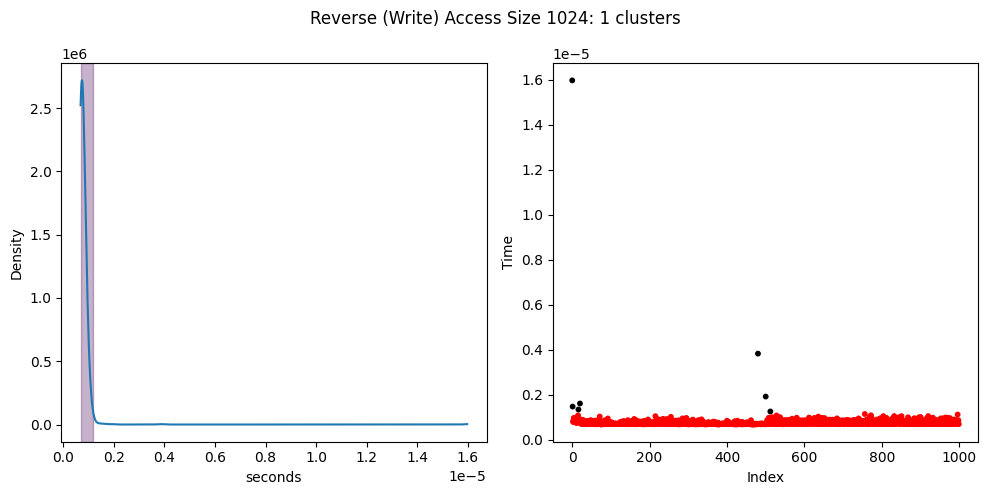

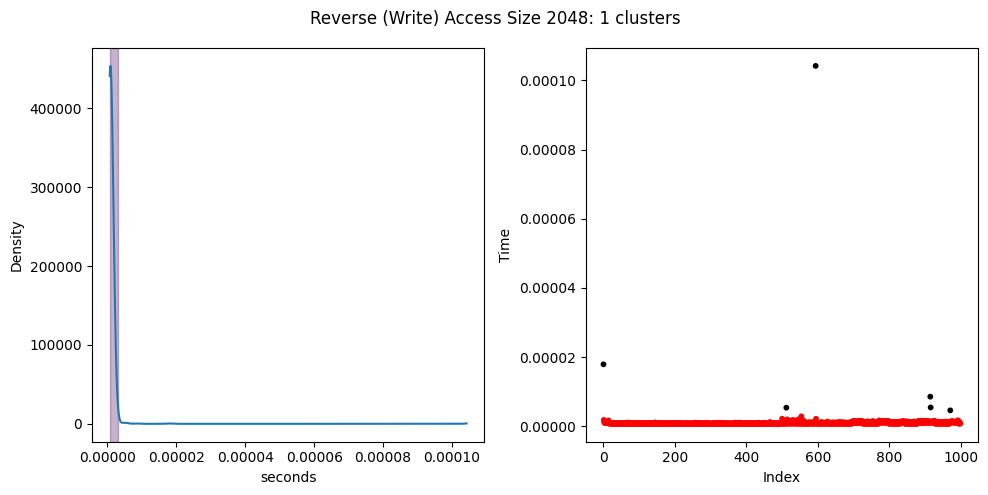

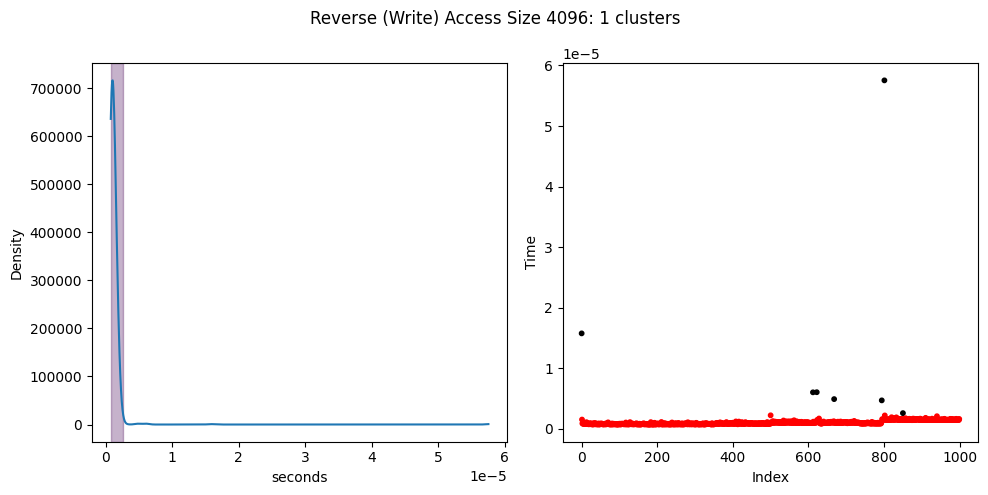

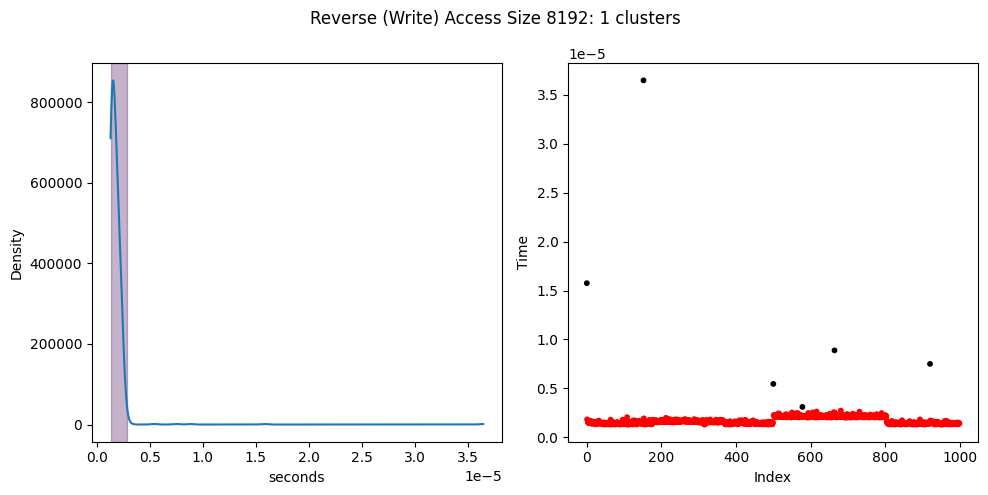

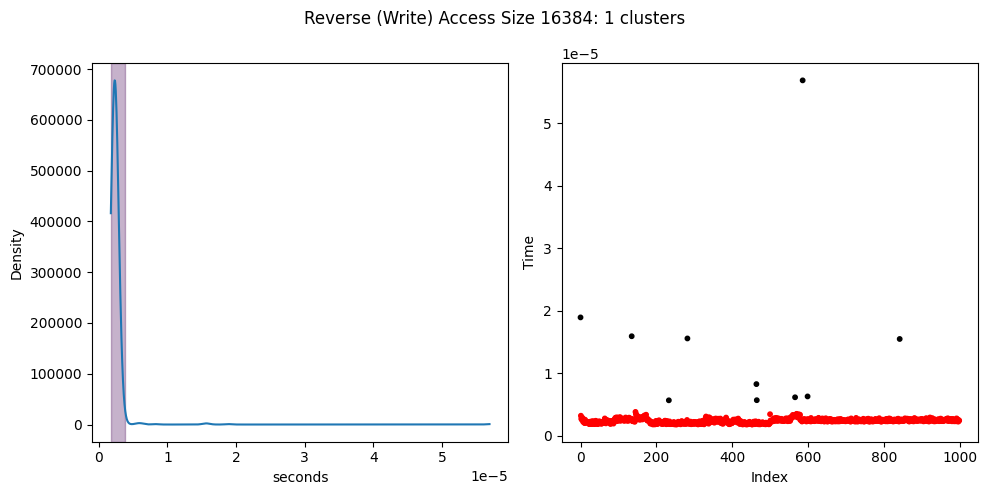

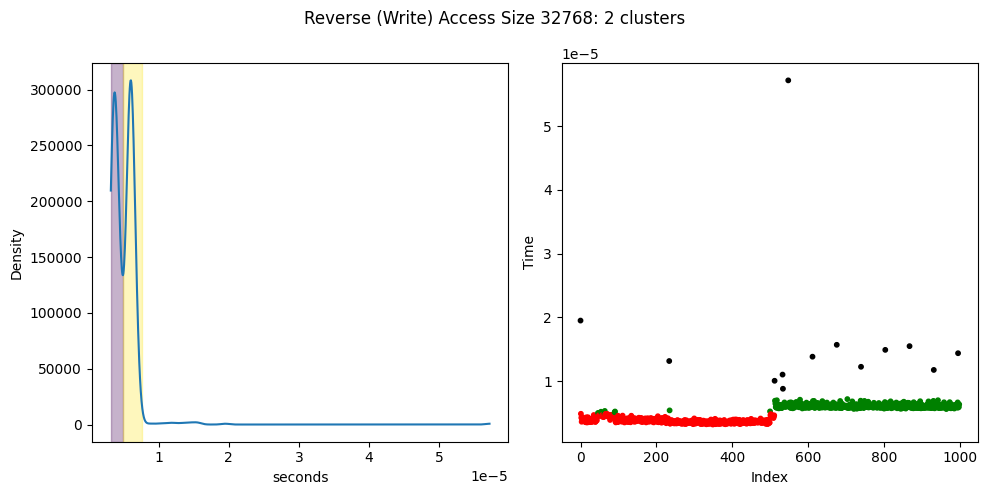

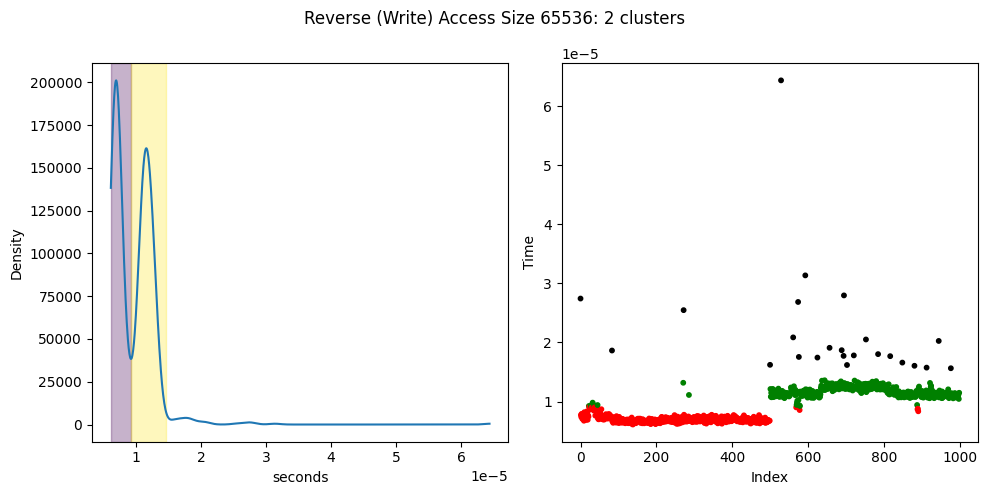

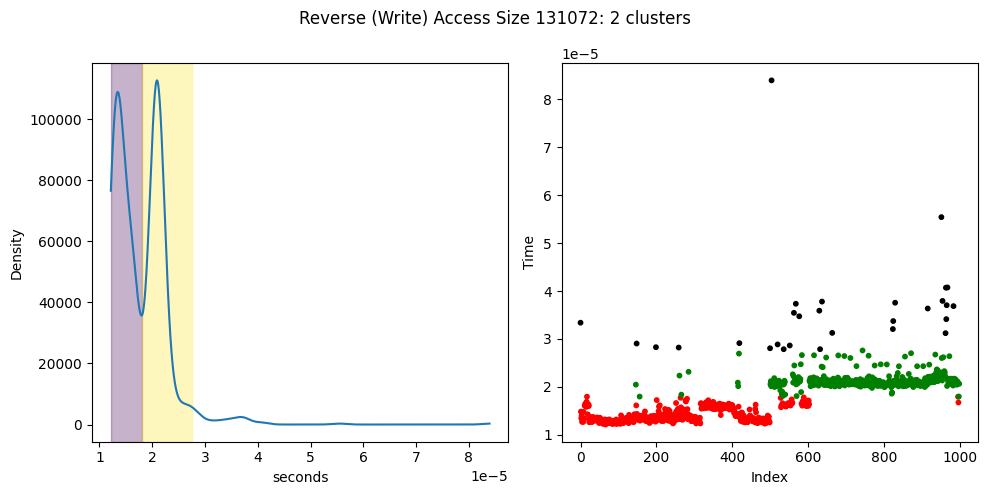

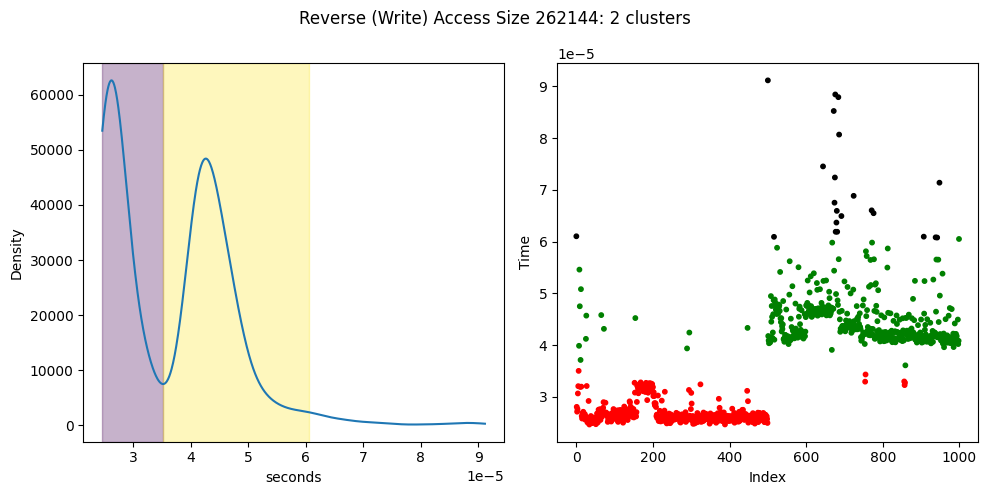

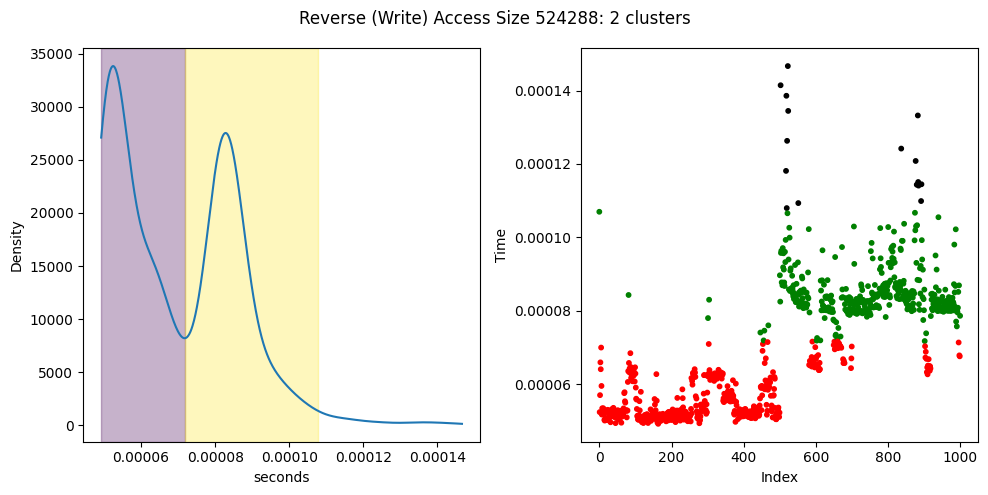

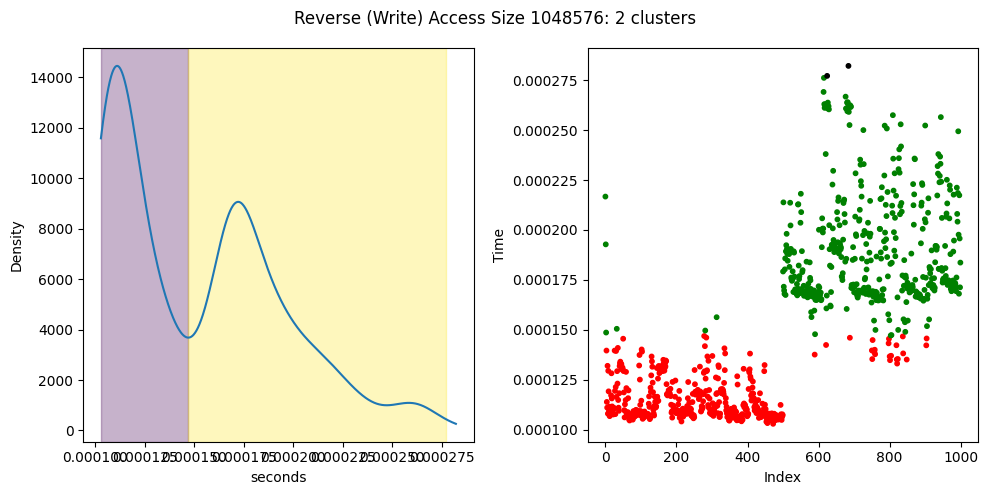

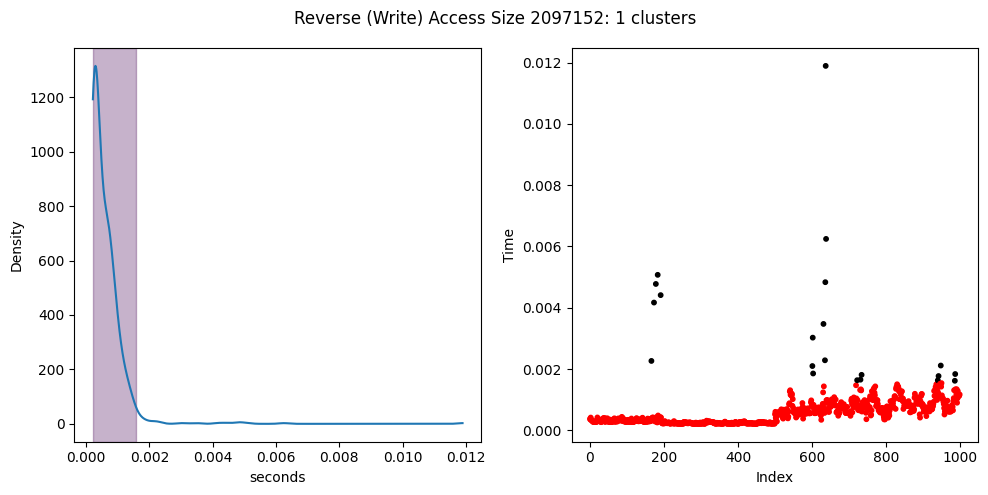

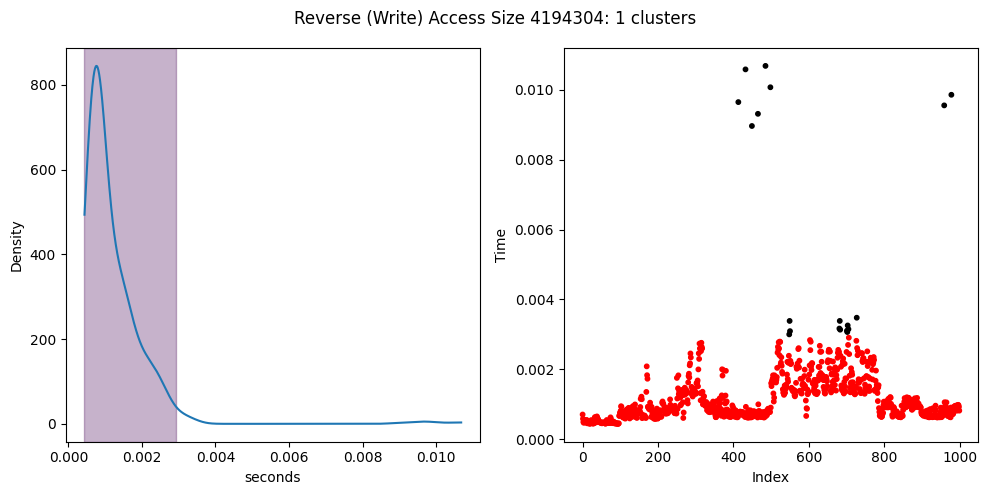

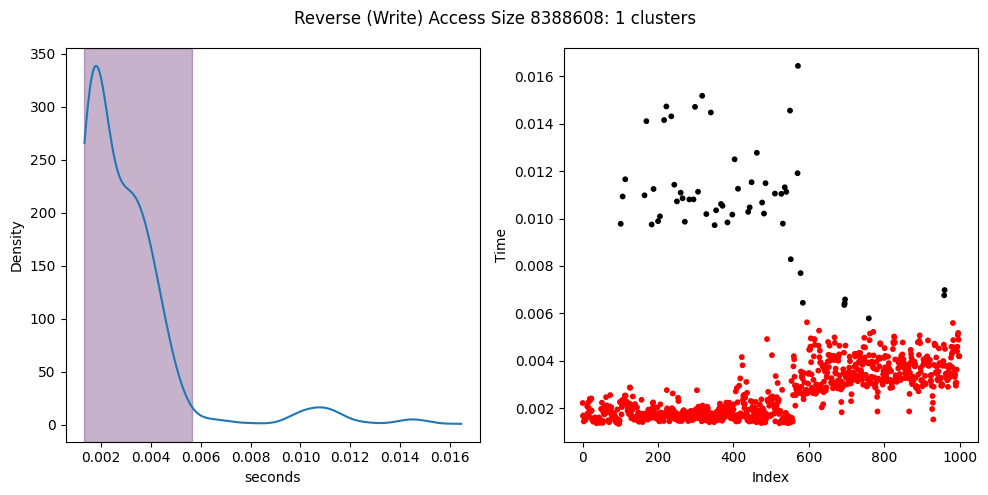

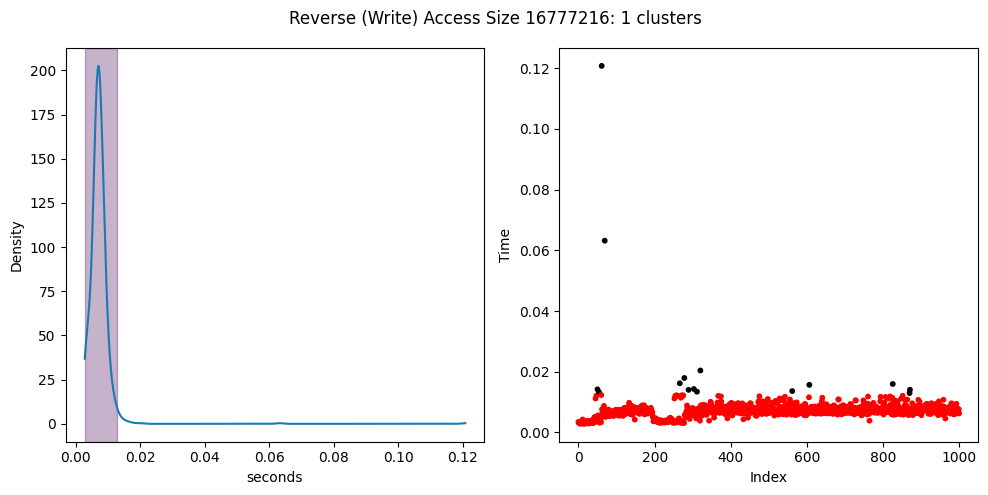

In [4]:
# flatten from (read, write) into one list
all_measurements_flattened = []
for read, write in ALL_MEASUREMENTS:
    all_measurements_flattened.extend([read, write])

for m in all_measurements_flattened:
    for access_size, benchmark in sorted(m.data.items()):
        io_op = "Read" if m.is_read else "Write"
        
        significant_clusters = find_significant_clusters_derivative(benchmark)[0]
        title = f"{read.name} ({io_op}) Access Size {access_size}: {len(significant_clusters)} clusters"

        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
        fig.suptitle(title)
        plot_kde_with_clusters(ax1, benchmark.kde, benchmark.min_val, benchmark.max_val, significant_clusters)
        scatter_plot_cluster(ax2, benchmark.raw_data, significant_clusters)
        plt.tight_layout()
        plt.show()

## All Linear Regression Models

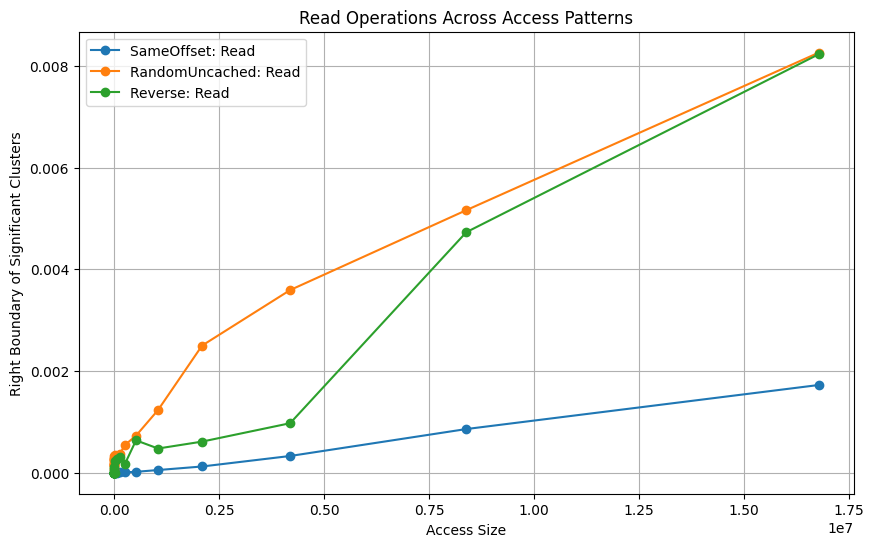

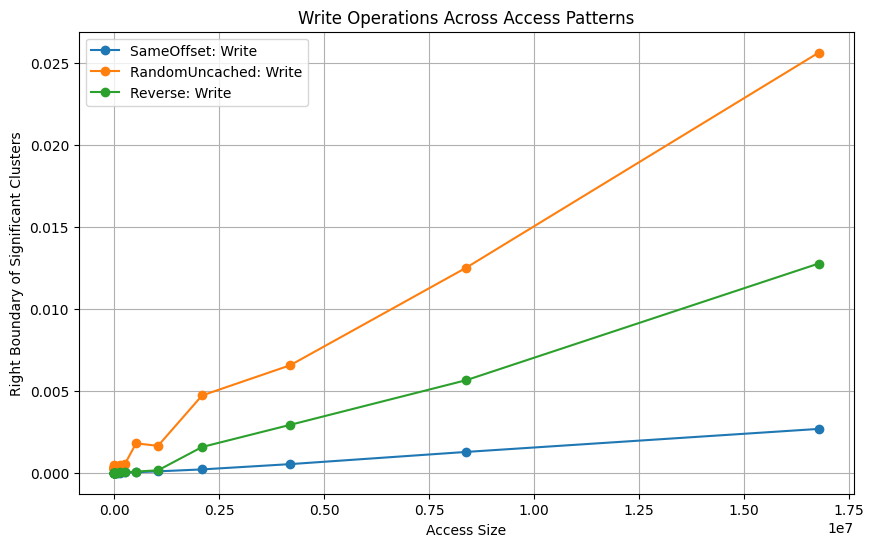

In [29]:
def plot_access_pattern_clusters(all_measurements):
    # Separate the measurements into reads and writes
    read_measurements = [m for m in all_measurements if m.is_read]
    write_measurements = [m for m in all_measurements if not m.is_read]

    # Plotting function
    def plot_measurements(measurements, title):
        plt.figure(figsize=(10, 6))
        for m in measurements:
            access_sizes = sorted(m.data.keys())
            right_boundaries = [find_significant_clusters_derivative(m.data[size])[1].right_boundary for size in access_sizes]
            plt.plot(access_sizes, right_boundaries, label=f"{m.name}: {'Read' if m.is_read else 'Write'}", marker="o")

        plt.title(title)
        plt.xlabel('Access Size')
        plt.ylabel('Right Boundary of Significant Clusters')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot reads and writes separately
    plot_measurements(read_measurements, 'Read Operations Across Access Patterns')
    plot_measurements(write_measurements, 'Write Operations Across Access Patterns')

plot_access_pattern_clusters(all_measurements_flattened)

In [24]:
def plot_models(models, until):
    # Separate models into reads and writes
    read_models = [model for model in models if model.is_read_op]
    write_models = [model for model in models if not model.is_read_op]

    # Plot settings
    x_values = np.linspace(1, until, 1000)

    # Function to plot a subset of models
    def plot_subset(models, title):
        for model in models:
            y_values = [model.slope * x + model.y_intercept for x in x_values]
            operation_type = "Read" if model.is_read_op else "Write"
            plt.plot(x_values, y_values, label=f"{model.benchmark_type}: ({operation_type})")
        plt.xlabel("X values")
        plt.ylabel("Y values")
        plt.title(title)
        plt.legend()
        plt.show()

    # Plot reads
    plot_subset(read_models, "Read Models")

    # Plot writes
    plot_subset(write_models, "Write Models")

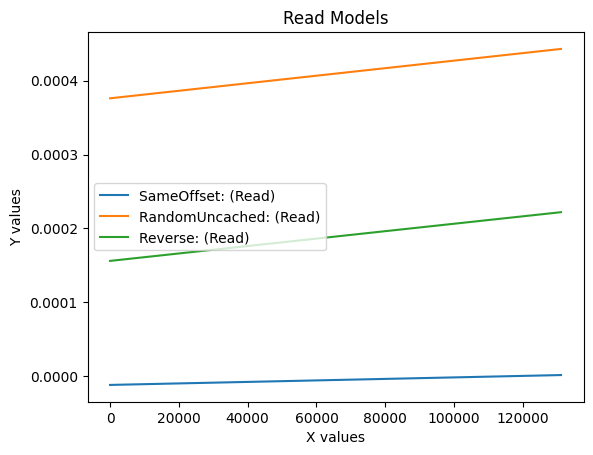

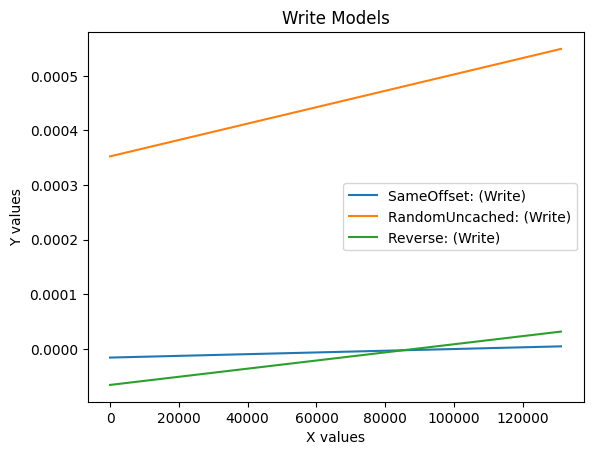

In [25]:
models= Model.all_from_csv("model.csv")
plot_models(models, 2**17)